# Init

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st 
from scipy.optimize import least_squares, curve_fit
import emcee

import os, time, json, math
from pathlib import Path
# from tqdm.autonotebook import tqdm
from tqdm.auto import tqdm
from copy import deepcopy

from mpl_toolkits.mplot3d import Axes3D

np.random.seed(42)

DAYS_PER_YEAR = 365.2425
DAYS_PER_MONTH = 30.4375
DAYS_PER_WEEK = 7.0
HOURS_PER_DAY = 24

# Liver

## Liver capacities $K$, $S$

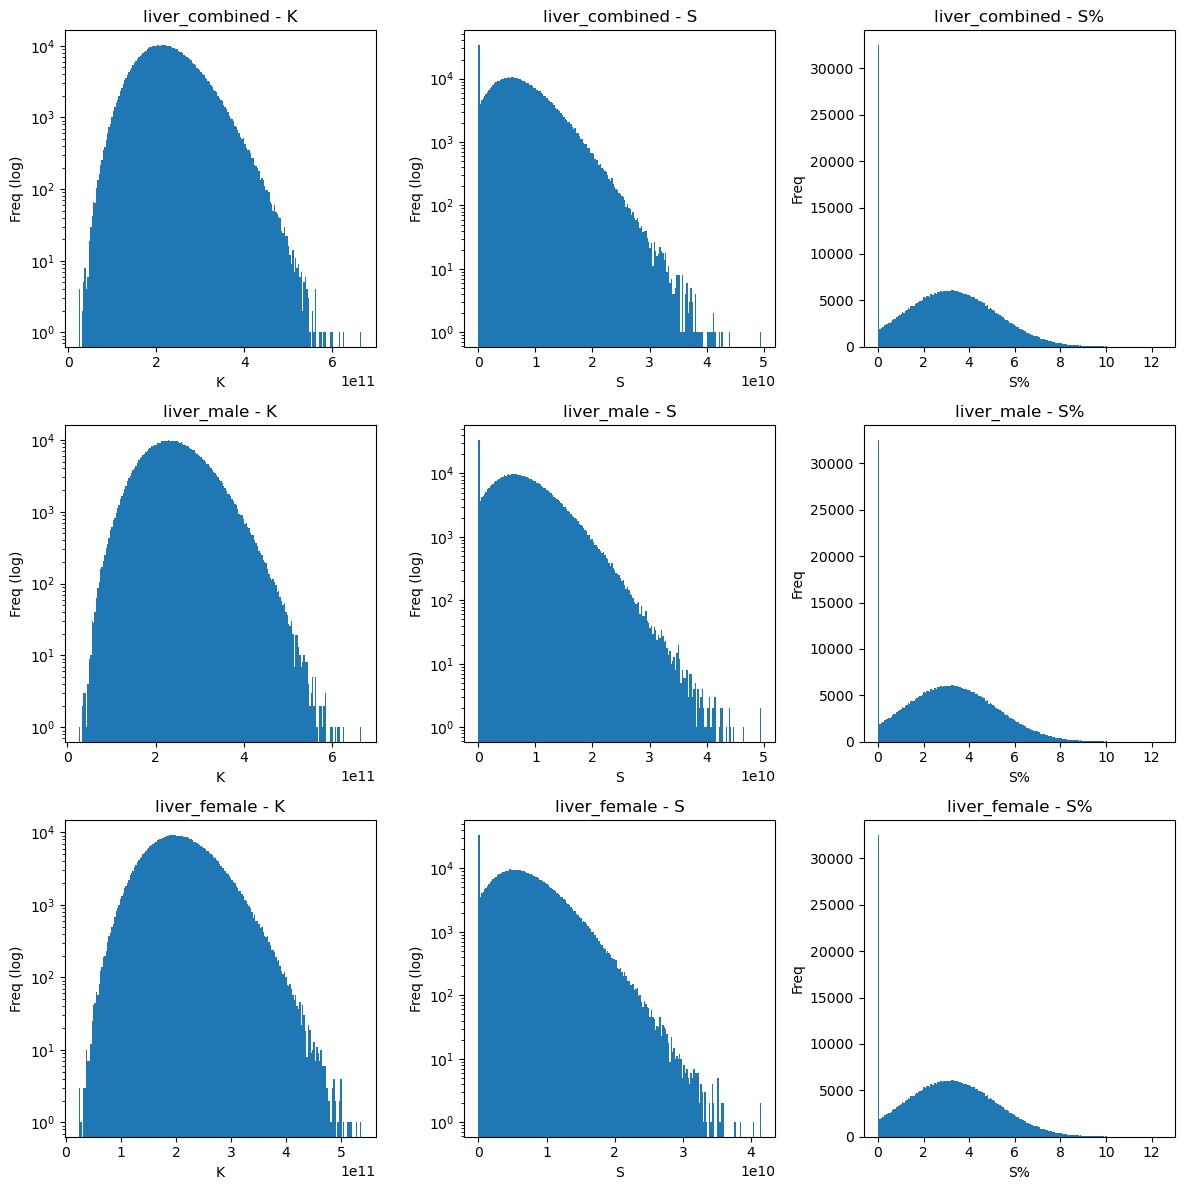

,liver_combined,liver_male,liver_female
metric,,,
K_mean,2.26e+11,2.44e+11,2.08e+11
K_low,1.15e+11,1.27e+11,1.08e+11
K_high,3.65e+11,3.85e+11,3.29e+11
S_mean,7.26e+09,7.82e+09,6.69e+09
S_low,2.21e+05,2.40e+05,2.05e+05
S_high,1.88e+10,2.00e+10,1.71e+10
S_pct_mean,3.21e+00,3.21e+00,3.21e+00
S_pct_low,1.06e-04,1.06e-04,1.06e-04
S_pct_high,7.15e+00,7.15e+00,7.15e+00


In [2]:
N = 5e5 # number of Monte-Carlo draws
out_dir = "./params/liver"
os.makedirs(out_dir, exist_ok=True)
p_low, p_high = 2.5, 97.5

# Parameters from studies
hep_per_g_mean = 139e6; hep_per_g_sd = 25e6
liver_male_median = 1754.0; liver_female_median = 1500.0 # liver mass in g
liver_male_sd = liver_male_median * 0.20; liver_female_sd = liver_female_median * 0.20
lsc_frac_mean = 0.0295; lsc_frac_sd = 0.0191

# Monte-Carlo draws
hep_per_g = np.random.normal(hep_per_g_mean, hep_per_g_sd, size=N); hep_per_g = np.clip(hep_per_g,1e6,None)
liver_male_mass = np.random.normal(liver_male_median, liver_male_sd, size=N); liver_male_mass = np.clip(liver_male_mass,500,None)
liver_female_mass = np.random.normal(liver_female_median, liver_female_sd, size=N); liver_female_mass = np.clip(liver_female_mass,400,None)
is_male = np.random.rand(N) < 0.5
liver_combined_mass = np.where(is_male, liver_male_mass, liver_female_mass)
lsc_frac = np.random.normal(lsc_frac_mean, lsc_frac_sd, size=N); lsc_frac = np.clip(lsc_frac,1e-6,0.30)

chol_frac = np.random.normal(0.04,0.01,size=N); chol_frac = np.clip(chol_frac,0.01,0.08)
hep_frac = np.random.normal(0.60,0.10,size=N); hep_frac = np.clip(hep_frac,0.40,0.80)
epithelial_multiplier = 1.0 + (chol_frac / hep_frac)

def summarize_with_se(draws):
    mean = float(np.mean(draws))
    sd = float(np.std(draws, ddof=1))
    q_lo = float(np.percentile(draws, p_low))
    q_hi = float(np.percentile(draws, p_high))
    se_mean = sd / math.sqrt(N)
    # density estimate using histogram around quantile
    counts, bins = np.histogram(draws, bins=2000)
    bin_width = bins[1] - bins[0]
    # for q_lo
    idx_lo = np.searchsorted(bins, q_lo) - 1
    idx_lo = max(0, min(len(counts)-1, idx_lo))
    f_lo = counts[idx_lo] / (N * bin_width) if counts[idx_lo] > 0 else np.nan
    se_q_lo = math.sqrt(p_low/100*(1-p_low/100)/(N * (f_lo**2))) if f_lo and f_lo>0 else float('nan')
    # for q_hi
    idx_hi = np.searchsorted(bins, q_hi) - 1
    idx_hi = max(0, min(len(counts)-1, idx_hi))
    f_hi = counts[idx_hi] / (N * bin_width) if counts[idx_hi] > 0 else np.nan
    se_q_hi = math.sqrt(p_high/100*(1-p_high/100)/(N * (f_hi**2))) if f_hi and f_hi>0 else float('nan')
    return {"mean":mean, "sd":sd, "se_mean":se_mean, "low":q_lo, "high":q_hi, "se_low":se_q_lo, "se_high":se_q_hi}

results = {}
for label, mass in [("liver_combined", liver_combined_mass), ("liver_male", liver_male_mass), ("liver_female", liver_female_mass)]:
    K = hep_per_g * mass
    epithelial = K * epithelial_multiplier
    S = epithelial * lsc_frac
    S_pct = (S / K) * 100.0
    results[label] = {"K": summarize_with_se(K), "S": summarize_with_se(S), "S_pct": summarize_with_se(S_pct)}

# Transposed DF
rows = []
for metric in ["K","S","S_pct"]:
    for stat in ["mean","low","high"]:
        key = f"{metric}_{stat}"
        row = {"metric": key,
               "liver_combined": results["liver_combined"][metric][stat],
               "liver_male": results["liver_male"][metric][stat],
               "liver_female": results["liver_female"][metric][stat]}
        rows.append(row)
df_transposed = pd.DataFrame(rows).set_index("metric")
csv_path = os.path.join(out_dir, "liver_sohlenius_500k_transposed.csv")
df_transposed.to_csv(csv_path)

# SE estimates DF
se_rows = []
for label in ["liver_combined","liver_male","liver_female"]:
    for metric in ["K","S","S_pct"]:
        d = results[label][metric]
        se_rows.append({"label":label,"metric":metric,"mean":d["mean"],"sd":d["sd"],"se_mean":d["se_mean"],
                        "low":d["low"],"low_se":d["se_low"],"high":d["high"],"high_se":d["se_high"]})
df_se = pd.DataFrame(se_rows)
df_se.to_csv(os.path.join(out_dir, "liver_sohlenius_500k_se_estimates.csv"), index=False)

# Multi-panel PDF
fig, axes = plt.subplots(3,3, figsize=(12,12))
labels = ["liver_combined","liver_male","liver_female"]
for i,label in enumerate(labels):
    mass = liver_combined_mass if label=="liver_combined" else (liver_male_mass if label=="liver_male" else liver_female_mass)
    K_draws = hep_per_g * mass
    epithelial_draws = K_draws * epithelial_multiplier
    S_draws = epithelial_draws * lsc_frac
    S_pct_draws = (S_draws / K_draws) * 100.0
    axes[i,0].hist(K_draws, bins=200, log=True); axes[i,0].set_title(f"{label} - K"); axes[i,0].set_xlabel("K"); axes[i,0].set_ylabel("Freq (log)")
    axes[i,1].hist(S_draws, bins=200, log=True); axes[i,1].set_title(f"{label} - S"); axes[i,1].set_xlabel("S"); axes[i,1].set_ylabel("Freq (log)")
    axes[i,2].hist(S_pct_draws, bins=200); axes[i,2].set_title(f"{label} - S%"); axes[i,2].set_xlabel("S%"); axes[i,2].set_ylabel("Freq")
plt.tight_layout()
pdf_path = os.path.join(out_dir, "liver_sohlenius_500k_multi_panel.pdf")
plt.savefig(pdf_path, dpi=150)
plt.show(fig)

# Save metadata
meta = {"N":N,"note":"500k draws; Sohlenius hepatocellularity; CAP medians; Liu lsc fraction; sampled chol_frac/hep_frac priors.","sources":{"sohlenius":"PMID 16930941","liu_2025":"PMID 40008906"}}
with open(os.path.join(out_dir,"metadata.json"),"w") as fh: json.dump(meta, fh, indent=2)

# Return paths and a small summary table for chat display
display_df = df_transposed.copy()
display_df = display_df.map(lambda x: f"{x:,.2e}")
# display_df.head(50).to_csv(os.path.join(out_dir,"liver_sohlenius_500k_transposed_preview.csv"))
csv_path, os.path.join(out_dir,"liver_sohlenius_500k_se_estimates.csv"), pdf_path

display_df

In [ ]:
df_transposed

## Replication rate $r$

### studies

In [3]:
# # Sable et al., 2018
# SABLE_2018_RAW = {
#     "times_days": np.array([1,3,5,6,7,2,5,7,10,11,12,14,5,10,12,15,18,20,21,22,40,40,41,42,43,46,75,120]),
#     "X_frac": np.array([38,47,65,51,90,36,63,70,89,92,82,94,45,67,68,74,88,120,90,128,70,82,81,80,72,84,111,74]) / 100.0,
#     "notes": "Approximate digitization from Figure 1. Times in days; X as fraction of TLV; no CIs."
# }
# # Convert exact data points into 2-day wide bins
# bin_width = 2.0
# bin_edges = np.arange(0.0, SABLE_2018_RAW['times_days'].max() + bin_width + 1e-8, bin_width)
# bin_centers = bin_edges[:-1] + bin_width/2.0
# bin_labels = pd.cut(SABLE_2018_RAW['times_days'], bins=bin_edges, right=False, labels=bin_centers)
# df = pd.DataFrame({"time": SABLE_2018_RAW['times_days'], "X": SABLE_2018_RAW['X_frac'], "bin_center": bin_labels})

# # Aggregate in vectorized way
# def ci95(arr):
#     n = arr.size
#     if n < 2:return np.nan
#     sem = arr.std(ddof=1) / np.sqrt(n)
#     return st.t.ppf(0.975, df=n-1) * sem

# sable_summary_full = df.groupby("bin_center").agg(
#     time_mean_days=("time", "mean"),
#     X_mean=("X", "mean"),
#     X_ci95=("X", ci95),
#     n_in_bin=("X", "size")
# ).reset_index().set_index("bin_center").reindex(pd.Index(bin_centers)).reset_index().rename(columns={"index":"bin_center"})
# sable_summary_full

In [5]:
# Sable et al., 2018
SABLE_2018 = {
    "times_days": np.array([1,3,5,6,7,2,5,7,10,11,12,14,5,10,12,15,18,20,21,22,40,40,41,42,43,46,75,120]),
    "X_frac": np.array([38,47,65,51,90,36,63,70,89,92,82,94,45,67,68,74,88,120,90,128,70,82,81,80,72,84,111,74]) / 100.0,
    "notes": "Approximate digitization from Figure 1. Times in days; X as fraction of TLV; no CIs."
}
# # Convert exact data points into 2-day wide bins
# bin_edges = np.arange(SABLE_2018['times_days'].min(), SABLE_2018['times_days'].max() + 2, 2)
# bin_ids = np.digitize(SABLE_2018['times_days'], bin_edges)
# sable_df = pd.DataFrame({"time": SABLE_2018['times_days'], "X": SABLE_2018['X_frac'], "bin": bin_ids})

# # Aggregate in vectorized way
# def ci95(series):
#     n = series.size
#     if n < 2: return np.nan
#     return st.t.ppf(0.975, n-1) * series.std(ddof=1) / np.sqrt(n)

# summary = sable_df.groupby("bin").agg(
#     time_mean_days=("time", "mean"),
#     X_mean=("X", "mean"),
#     X_ci95=("X", ci95),
#     n_in_bin=("X", "size")
# ).reset_index(drop=True)


# Kim et al., 2024
KIM_2024_GROUP_A = {
    "times_days": np.array([0, 1*DAYS_PER_WEEK, 3*DAYS_PER_MONTH]), # POW1 and POM3
    "X_frac": np.array([29.6, 56.1, 81.3])/100, # mean
    "X_frac_ci": np.array([1.8, 7.5, 13.4])/100,
    "notes": "Times in days; Group A: RTVR < 30% (n=9), means ± CI straight from paper."
}
KIM_2024_GROUP_B = {
    "times_days": np.array([0, 1*DAYS_PER_WEEK, 3*DAYS_PER_MONTH]),
    "X_frac": np.array([36.7, 56.3, 76.2])/100, # mean
    "X_frac_ci": np.array([4.8, 7.8, 10.7])/100,
    "notes": "Group B: RTVR >= 30% (n=45), means ± CI straight from paper."
}

# Wang et al., 2024
WANG_2024_REMNANT_RIGHT = {
    "times_days": np.array([0, 1, 6, 12])*DAYS_PER_MONTH,
    "X_frac": np.array([0.75, 0.78, 0.88, 0.90]), # median
    "X_frac_ci": np.array([0.07, 0.25, 0.14, 0.10]),
    "notes": "Approximate digitization from Figure 2 (red curve)."
}
WANG_2024_REMNANT_LEFT = {
    "times_days": np.array([0, 1, 6, 12])*DAYS_PER_MONTH,
    "X_frac": np.array([0.50, 0.76, 0.88, 0.90]), # median
    "X_frac_ci": np.array([0.10, 0.30, 0.27, 0.20]),
    "notes": "Approximate digitization from Figure 2 (blue curve)."
}

# Gong et al., 2019
GONG_2019 = {
    "times_days": np.array([0, 1, 5, 9, 13])*DAYS_PER_WEEK,
    "X_frac": np.array([660, 790, 825, 850, 855])/1005,  # median liver volume in cm3 divided by initial TLV (mean)
    "X_frac_ci": np.array([200, 180, 175, 165, 165])/1005,
    "notes": "Approximate digitization from Figure 3B (non-PHLF curve)."
}

# Ibis et al., 2017
IBIS_2017_RHH = {
    "time_labels": ["Postop0", "Postop7", "PostopLate"],
    "times_days": np.array([0.0, 7.0, 31.0]),  # PostopLate has no exact day, >30 days
    "X_frac": np.array([484, 900, 1004])/1369, # median
    "X_frac_ci": np.array([244, 255, 261.5])/1369,
    "notes": "RHH: TLV mean used as denominator; postop volumes reported as medians; range converted to approximate CI = range/2."
}
IBIS_2017_LLS = {
    "time_labels": ["Postop0", "Postop7", "PostopLate"],
    "times_days": np.array([0.0, 7.0, 31.0]),
    "X_frac": np.array([1222, 1470, 1363])/1505, # median
    "X_frac_ci": np.array([408, 399.5, 536])/1505,
    "notes": "LLS: same processing as RHH."
}

# # Yamamoto et al., 2016
# yamamoto_path = "./params/liver/yamamoto2016.xls"
# df = pd.read_excel(yamamoto_path, sheet_name='Supplementary table 1') # Group 1, non-recovery

# time_cols = ['1POD','7POD','30POD','60POD','150POD','365POD','730POD']
# time_days = np.array([1, 7, 30, 60, 150, 365, 730])
# preop_col = 'Liver Volume'

# # For each timepoint compute mean and SD of V/preop_TLV across patients with available values

# # ensure numeric (coerce non-numeric -> NaN)
# num_cols = [preop_col] + [c for c in time_cols if c in df.columns]
# df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')

# # drop rows with invalid or zero preop TLV (can't normalize)
# df = df[df[preop_col].notna() & (df[preop_col] > 0)].copy()

# # compute per-timepoint series of V(t)/preop
# series_list = [ df[col].div(df[preop_col]) .dropna() if col in df.columns else pd.Series(dtype=float)
#                 for col in time_cols ]

# mean_X = np.array([ float(s.mean()) if not s.empty else None for s in series_list ])
# # sd_X   = np.array([ float(s.std(ddof=1)) if s.size > 1 else (None if s.empty else float(np.nan))
# #            for s in series_list ])
# # ci_X = [ st.t.interval(0.95, df=len(s)-1, loc=s.mean(), scale=s.std(ddof=1) / np.sqrt(len(s))) if s.size > 1 else (None if s.empty else float(np.nan))
# #          for s in series_list]
# ci_X = np.array([ float(st.t.ppf(0.975, df=len(s)-1) * (s.std(ddof=1) / np.sqrt(len(s)))) if s.size > 1 else (None if s.empty else float(np.nan))
#          for s in series_list])
# n_obs  = np.array([ int(s.size) for s in series_list ])

# YAMAMOTO_2016 = {
#     "times_days": time_days,
#     "X_frac": mean_X,
#     # "X_frac_sd": sd_X,
#     "X_frac_ci": ci_X,
#     # "n_obs": n_obs,
#     "notes": "Aggregates for recovered patients; values are mean +- SD of V(t)/preop_TLV at standard postop timepoints."
# }

# Final dict
r_studies = {
    "SABLE_2018": SABLE_2018,
    "KIM_2024_GROUP_A": KIM_2024_GROUP_A,
    "KIM_2024_GROUP_B": KIM_2024_GROUP_B,
    "WANG_2024_REMNANT_RIGHT": WANG_2024_REMNANT_RIGHT,
    "WANG_2024_REMNANT_LEFT": WANG_2024_REMNANT_LEFT,
    "GONG_2019": GONG_2019,
    "IBIS_2017_RHH": IBIS_2017_RHH,
    "IBIS_2017_LLS": IBIS_2017_LLS,
    # "YAMAMOTO_2016": YAMAMOTO_2016
}

In [6]:
r_studies

{'SABLE_2018': {'times_days': array([  1,   3,   5,   6,   7,   2,   5,   7,  10,  11,  12,  14,   5,
          10,  12,  15,  18,  20,  21,  22,  40,  40,  41,  42,  43,  46,
          75, 120]),
  'X_frac': array([0.38, 0.47, 0.65, 0.51, 0.9 , 0.36, 0.63, 0.7 , 0.89, 0.92, 0.82,
         0.94, 0.45, 0.67, 0.68, 0.74, 0.88, 1.2 , 0.9 , 1.28, 0.7 , 0.82,
         0.81, 0.8 , 0.72, 0.84, 1.11, 0.74]),
  'notes': 'Approximate digitization from Figure 1. Times in days; X as fraction of TLV; no CIs.'},
 'KIM_2024_GROUP_A': {'times_days': array([ 0.    ,  7.    , 91.3125]),
  'X_frac': array([0.296, 0.561, 0.813]),
  'X_frac_ci': array([0.018, 0.075, 0.134]),
  'notes': 'Times in days; Group A: RTVR < 30% (n=9), means ± CI straight from paper.'},
 'KIM_2024_GROUP_B': {'times_days': array([ 0.    ,  7.    , 91.3125]),
  'X_frac': array([0.367, 0.563, 0.762]),
  'X_frac_ci': array([0.048, 0.078, 0.107]),
  'notes': 'Group B: RTVR >= 30% (n=45), means ± CI straight from paper.'},
 'WANG_2024_R

In [ ]:
# # Recompute fits using perturbation-based CIs: for each study create X_lo = X - 1.96*sd and X_hi = X + 1.96*sd
# # If sd unavailable, assume 5% relative (sd = 0.05*X). Fit logistic (K=1) and Hill (r,theta,n for SABLE; r,n for others with theta=1/3)
# import numpy as np, pandas as pd
# from scipy.optimize import curve_fit, least_squares
# from scipy.integrate import solve_ivp
# import warnings
# warnings.filterwarnings("ignore", category=RuntimeWarning)

# def aggregate_duplicates(t, X, sd=None):
#     uniq = np.array(sorted(np.unique(t)))
#     Xmean = np.array([np.mean(X[np.isclose(t, u)]) for u in uniq])
#     Xstd = np.array([np.std(X[np.isclose(t, u)], ddof=1) if np.sum(np.isclose(t,u))>1 else np.nan for u in uniq])
#     if sd is None:
#         sdmean = np.array([np.nan]*len(uniq))
#     else:
#         sd = np.asarray(sd)
#         sdmean = np.array([np.nanmean(sd[np.isclose(t, u)]) if np.any(np.isclose(t,u)) else np.nan for u in uniq])
#     return uniq, Xmean, Xstd, sdmean

# def logistic_solution(t, r, X0, K):
#     A = (K / X0) - 1.0
#     return K / (1.0 + A * np.exp(-r * np.asarray(t)))

# # def fit_logistic_K1_point(t, X, X0=None):
# #     if X0 is None: X0 = X[0]
# #     def fun_r(t, r): return logistic_solution(t, r, 1.0, X0)
# #     try:
# #         if len(t)>=2 and X[0]>0 and X[1]>0:
# #             rho = np.log(X[1]/X[0])/(t[1]-t[0])
# #             r0 = rho / (1 - X0/1.0) if abs(1 - X0/1.0)>1e-8 else max(1e-3, rho)
# #         else:
# #             r0 = 0.02
# #     except Exception:
# #         r0 = 0.02
# #     popt, pcov = curve_fit(fun_r, t, X, p0=[r0], bounds=([1e-8],[2.0]), maxfev=5000)
# #     return float(popt[0])

# def fit_r_for_group(t_raw, X_raw):
#     mask = np.isfinite(X_raw) & (X_raw <= 1.0)
#     if np.sum(mask) < 2:
#         return np.nan, "insufficient_points_after_filtering"
#     t = np.asarray(t_raw)[mask].astype(float)
#     X = np.asarray(X_raw)[mask].astype(float)
#     order = np.argsort(t)
#     t = t[order]; X = X[order]
#     X0 = float(X[0])
#     def fun_r(t, r): return logistic_solution(t, r, X0, K=1.0)
#     try:
#         if len(t) >= 2 and X[0] > 0 and X[1] > 0 and (t[1] - t[0])>0:
#             rho = np.log(X[1]/X[0])/(t[1]-t[0])
#             r0 = rho / (1 - X0/1.0) if abs(1 - X0) > 1e-8 else max(1e-3, rho)
#             r0 = max(1e-6, min(r0, 1.0))
#         else:
#             r0 = 0.02
#     except Exception:
#         r0 = 0.02
#     try:
#         popt, pcov = curve_fit(fun_r, t, X, p0=[r0], bounds=([1e-8],[2.0]), maxfev=10000)
#         return float(popt[0]), "ok"
#     except Exception as e:
#         return np.nan, f"fit_error: {str(e)}"

# def hill_ode(t, x, r, K, theta, n):
#     denom = 1.0 + ((x/K) / theta)**n
#     return (r * x) / denom

# def simulate_hill(t_eval, r, K, theta, n, X0):
#     t_eval_sorted = np.array(sorted(t_eval))
#     sol = solve_ivp(lambda tt,yy: hill_ode(tt, yy, r, K, theta, n),
#                     t_span=(t_eval_sorted[0], t_eval_sorted[-1]), y0=[X0], t_eval=t_eval_sorted,
#                     method='RK45', rtol=1e-6, atol=1e-8)
#     order = np.argsort(t_eval)
#     inv_order = np.argsort(order)
#     return sol.y[0][inv_order]

# def fit_hill_point(t, X, fit_theta=True, fit_n=True, Kfix=1.0):
#     # similar to previous but no sd and smaller iterations
#     X0 = X[0]
#     if len(t)>=2 and X[0]>0 and X[1]>0:
#         rho = np.log(X[1]/X[0])/(t[1]-t[0])
#     else:
#         rho = 0.02
#     theta0 = 1/3.0; n0 = 2.0
#     p0 = []; p_idx={}; idx=0; bounds_low=[]; bounds_high=[]
#     p0.append(max(1e-6, rho*(1 + (X0/Kfix/theta0)**n0))); bounds_low.append(1e-8); bounds_high.append(2.0); p_idx['r']=idx; idx+=1
#     if fit_theta:
#         p0.append(theta0); bounds_low.append(1e-4); bounds_high.append(10.0); p_idx['theta']=idx; idx+=1
#     if fit_n:
#         p0.append(n0); bounds_low.append(0.5); bounds_high.append(10.0); p_idx['n']=idx; idx+=1
#     p0 = np.array(p0)
#     bounds = (np.array(bounds_low), np.array(bounds_high))
#     def residuals(p):
#         ip=0; r=p[ip]; ip+=1
#         theta = p[p_idx['theta']] if 'theta' in p_idx else theta0
#         nval = p[p_idx['n']] if 'n' in p_idx else n0
#         sim = simulate_hill(t, r, Kfix, theta, nval, X0)
#         return sim - X
#     res = least_squares(residuals, p0, bounds=bounds, max_nfev=3000, xtol=1e-6)
#     out = {}
#     out['r'] = float(res.x[p_idx['r']])
#     if 'theta' in p_idx: out['theta'] = float(res.x[p_idx['theta']])
#     else: out['theta'] = 1/3.0
#     if 'n' in p_idx: out['n'] = float(res.x[p_idx['n']])
#     else: out['n'] = 2.0
#     out['success'] = bool(res.success)
#     return out

# # Now process studies: compute sd per timepoint (use provided sd or fallback 5% relative)
# studies = {
#  'SABLE_2018': {'times_days': np.array([  1,   3,   5,   6,   7,   2,   5,   7,  10,  11,  12,  14,   5,
#           10,  12,  15,  18,  20,  21,  22,  40,  40,  41,  42,  43,  46,
#           75, 120]),
#   'X_frac': np.array([0.38, 0.47, 0.65, 0.51, 0.9 , 0.36, 0.63, 0.7 , 0.89, 0.92, 0.82,
#          0.94, 0.45, 0.67, 0.68, 0.74, 0.88, 1.2 , 0.9 , 1.28, 0.7 , 0.82,
#          0.81, 0.8 , 0.72, 0.84, 1.11, 0.74]),
#   'notes': 'Times in days; X as fraction of TLV; no CIs provided.'},
#  'KIM_2024_GROUP_A': {'times_days': [0, 7.0, 91.3125],
#   'X_frac_mean': np.array([0.296, 0.561, 0.813]),
#   'X_frac_sd': np.array([0.018, 0.075, 0.134])},
#  'KIM_2024_GROUP_B': {'times_days': [0, 7.0, 91.3125],
#   'X_frac_mean': np.array([0.367, 0.563, 0.762]),
#   'X_frac_sd': np.array([0.048, 0.078, 0.107])},
#  'WANG_2024_REMNANT_RIGHT': {'times_days': np.array([  0.    ,  30.4375, 182.625 , 365.25  ]),
#   'X_frac_mean': np.array([0.75, 0.78, 0.88, 0.9]),
#   'X_frac_sd_est': np.array([0.07, 0.25, 0.14, 0.1])},
#  'WANG_2024_REMNANT_LEFT': {'times_days': np.array([  0.    ,  30.4375, 182.625 , 365.25  ]),
#   'X_frac_mean': np.array([0.5, 0.76, 0.88, 0.9]),
#   'X_frac_sd_est': np.array([0.1, 0.3, 0.27, 0.2])},
#  'GONG_2019': {'times_days': np.array([ 0.,  7., 35., 63., 91.]),
#   'X_frac_mean': np.array([0.65671642, 0.78606965, 0.82089552, 0.84577114, 0.85074627]),
#   'X_frac_sd_est': np.array([0.19900498, 0.17910448, 0.17412935, 0.1641791 , 0.1641791 ])},
#  'IBIS_2017_RHH': {'times_days': [0.0, 7.0, 31.0],
#   'X_frac_mean': np.array([0.35354273, 0.65741417, 0.73338203]),
#   'X_frac_sd_est': np.array([0.17823229, 0.18626735, 0.19101534])},
#  'IBIS_2017_LLS': {'times_days': [0.0, 7.0, 31.0],
#   'X_frac_mean': np.array([0.81196013, 0.97674419, 0.90564784]),
#   'X_frac_sd_est': np.array([0.27109635, 0.2654485 , 0.35614618])}
# }

# records = []
# for key, val in studies.items():
#     # get arrays
#     if key == 'SABLE_2018':
#         t_raw = np.array(val['times_days'], dtype=float)
#         X_raw = np.array(val['X_frac'], dtype=float)
#         sd_raw = None
#     else:
#         t_raw = np.array(val['times_days'], dtype=float)
#         if 'X_frac_mean' in val:
#             X_raw = np.array(val['X_frac_mean'], dtype=float)
#         else:
#             X_raw = np.array(val.get('X_frac'), dtype=float)
#         if 'X_frac_sd' in val:
#             sd_raw = np.array(val['X_frac_sd'], dtype=float)
#         elif 'X_frac_sd_est' in val:
#             sd_raw = np.array(val['X_frac_sd_est'], dtype=float)
#         else:
#             sd_raw = None
#     uniq_t, X_mean, X_std_dup, sdmean = aggregate_duplicates(t_raw, X_raw, sd_raw)
#     # determine per-time sd: prefer sdmean else X_std_dup else 5% relative
#     sd_use = np.array([sdmean[i] if not np.isnan(sdmean[i]) else (X_std_dup[i] if not np.isnan(X_std_dup[i]) else 0.05*X_mean[i]) for i in range(len(uniq_t))])
#     # build X_lo and X_hi by mean +/- 1.96*sd_use
#     X_lo = np.clip(X_mean - 1.96*sd_use, 1e-6, 2.0)
#     X_hi = np.clip(X_mean + 1.96*sd_use, 1e-6, 2.0)
#     # Fit logistic to mean, lo, hi
#     try:
#         r_log_mean = fit_r_for_group(uniq_t, X_mean)
#     except Exception:
#         r_log_mean = np.nan
#     try:
#         r_log_lo = fit_r_for_group(uniq_t, X_lo)
#     except Exception:
#         r_log_lo = np.nan
#     try:
#         r_log_hi = fit_r_for_group(uniq_t, X_hi)
#     except Exception:
#         r_log_hi = np.nan
#     # Fit hill: SABLE full (r,theta,n) otherwise r and n (theta fixed)
#     if key == 'SABLE_2018':
#         try:
#             hill_mean = fit_hill_point(uniq_t, X_mean, fit_theta=True, fit_n=True, Kfix=1.0)
#         except Exception:
#             hill_mean = fit_hill_point(uniq_t, X_mean, fit_theta=False, fit_n=True, Kfix=1.0); hill_mean['theta']=1/3.0
#         try:
#             hill_lo = fit_hill_point(uniq_t, X_lo, fit_theta=True, fit_n=True, Kfix=1.0)
#         except Exception:
#             hill_lo = fit_hill_point(uniq_t, X_lo, fit_theta=False, fit_n=True, Kfix=1.0); hill_lo['theta']=1/3.0
#         try:
#             hill_hi = fit_hill_point(uniq_t, X_hi, fit_theta=True, fit_n=True, Kfix=1.0)
#         except Exception:
#             hill_hi = fit_hill_point(uniq_t, X_hi, fit_theta=False, fit_n=True, Kfix=1.0); hill_hi['theta']=1/3.0
#     else:
#         # theta fixed
#         try:
#             hill_mean = fit_hill_point(uniq_t, X_mean, fit_theta=False, fit_n=True, Kfix=1.0)
#             hill_lo = fit_hill_point(uniq_t, X_lo, fit_theta=False, fit_n=True, Kfix=1.0)
#             hill_hi = fit_hill_point(uniq_t, X_hi, fit_theta=False, fit_n=True, Kfix=1.0)
#         except Exception:
#             hill_mean = hill_lo = hill_hi = {'r': np.nan, 'theta': 1/3.0, 'n': np.nan}
#     records.append({
#         'study': key,
#         'n_timepoints': len(uniq_t),
#         'logistic_r_mean': r_log_mean,
#         'logistic_r_lo': r_log_lo,
#         'logistic_r_hi': r_log_hi,
#         'hill_r_mean': float(hill_mean.get('r', np.nan)),
#         'hill_r_lo': float(hill_lo.get('r', np.nan)),
#         'hill_r_hi': float(hill_hi.get('r', np.nan)),
#         'hill_theta_mean': float(hill_mean.get('theta', np.nan)),
#         'hill_n_mean': float(hill_mean.get('n', np.nan))
#     })

# df_results = pd.DataFrame(records).set_index('study')
# df_results.round(6)


,n_timepoints,logistic_r_mean,logistic_r_lo,logistic_r_hi,hill_r_mean,hill_r_lo,hill_r_hi,hill_theta_mean,hill_n_mean
study,,,,,,,,,
SABLE_2018,22,"(0.15819850314214587, ok)","(0.05763699702877961, ok)","(0.17288710270213037, ok)",0.152635,0.088961,0.219164,0.621848,10.000000
KIM_2024_GROUP_A,3,"(0.15879888040533094, ok)","(0.013999739076864661, ok)","(0.22687025565414684, ok)",0.908722,0.180970,2.000000,0.333333,7.149066
KIM_2024_GROUP_B,3,"(0.11367278707440459, ok)","(0.013366684817759416, ok)","(0.15430050128338252, ok)",1.485132,0.167841,2.000000,0.333333,8.526203
WANG_2024_REMNANT_RIGHT,4,"(0.003759806070002196, ok)","(0.0005523426019355973, ok)","(nan, insufficient_points_after_filtering)",2.000000,0.000510,2.000000,0.333333,8.882322
WANG_2024_REMNANT_LEFT,4,"(0.0370783135564494, ok)","(0.002045226288962873, ok)","(nan, insufficient_points_after_filtering)",2.000000,0.002644,2.000000,0.333333,8.420559
GONG_2019,5,"(0.017042783425123328, ok)","(0.015490128596229195, ok)","(nan, insufficient_points_after_filtering)",2.000000,0.158811,2.000000,0.333333,7.483258
IBIS_2017_RHH,3,"(0.06468078052611083, ok)","(0.6546523293020525, ok)","(nan, insufficient_points_after_filtering)",2.000000,0.601446,2.000000,0.333333,7.489248
IBIS_2017_LLS,3,"(0.32382472279711394, ok)","(1.069508603865575e-08, ok)","(nan, insufficient_points_after_filtering)",2.000000,0.000000,2.000000,0.333333,6.127700


### chk1

,dataset,logistic_variant,logistic_r,logistic_tmid_or_shift,logistic_rss,hill_r,hill_theta,hill_n,hill_rss,X0_used,t0_used
0,SABLE_2018,logistic_solution_rel,0.188666,1.000000,0.733309,NaN,0.5,NaN,NaN,0.380000,1.0
1,KIM_2024_GROUP_A,logistic_tmid,0.158790,5.455991,0.034969,0.136796,0.5,9.0,0.000001,0.296000,0.0
2,KIM_2024_GROUP_B,logistic_tmid,0.113237,4.787843,0.056619,0.105789,0.5,10.0,0.000011,0.367000,0.0
3,WANG_2024_REMNANT_RIGHT,logistic_tmid,0.003517,-326.489287,0.000989,0.529799,0.5,13.0,0.000326,0.750000,0.0
4,WANG_2024_REMNANT_LEFT,logistic_tmid,0.036642,-0.318035,0.024138,1.013044,0.5,14.0,0.000290,0.500000,0.0
5,GONG_2019,logistic_tmid,0.011564,-80.865500,0.008118,2.000000,0.5,14.0,0.002962,0.656716,0.0
6,IBIS_2017_RHH,logistic_tmid,0.045956,4.240586,0.027028,0.658040,0.5,14.0,0.000001,0.353543,0.0
7,IBIS_2017_LLS,logistic_solution_rel,0.323825,0.000000,0.008900,1.999966,0.5,10.0,0.014390,0.811960,0.0


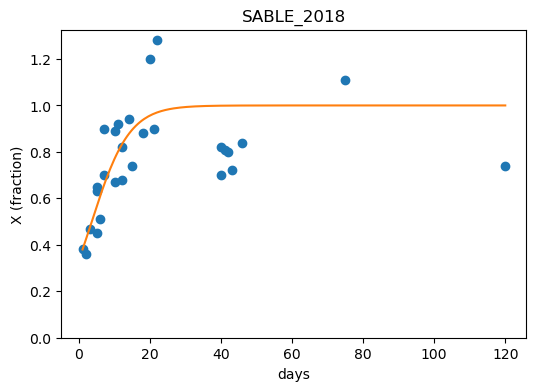

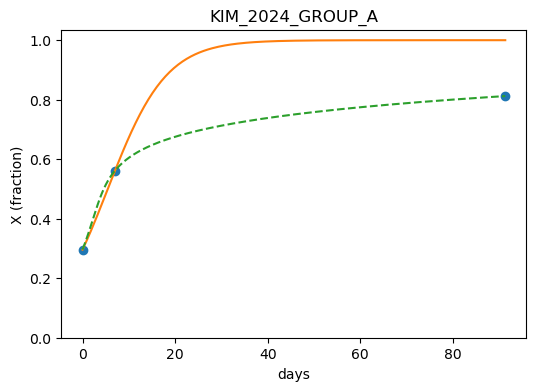

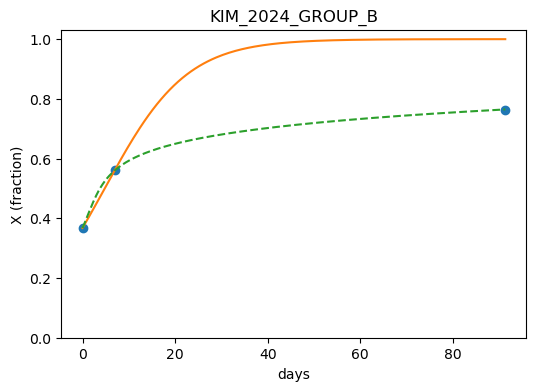

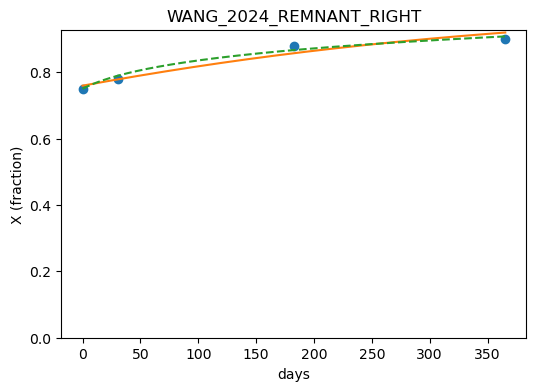

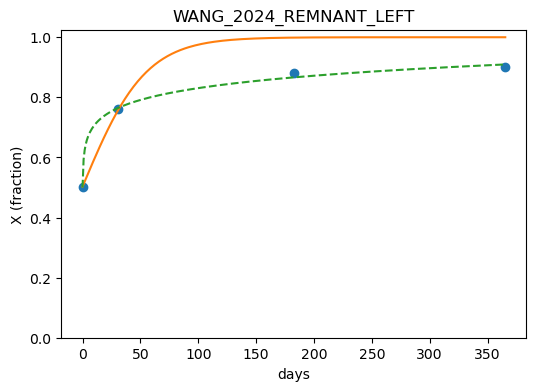

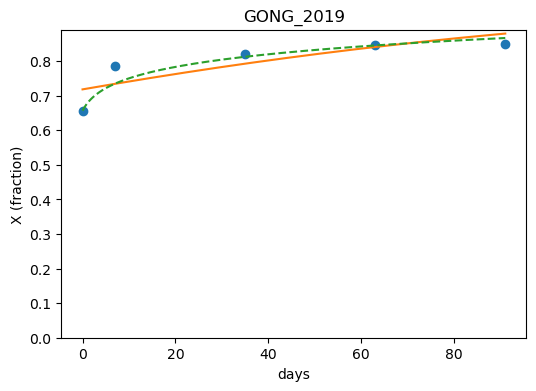

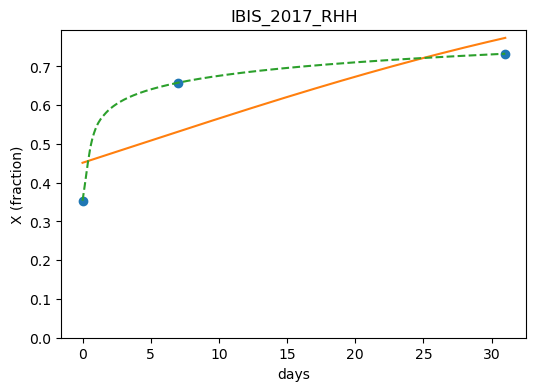

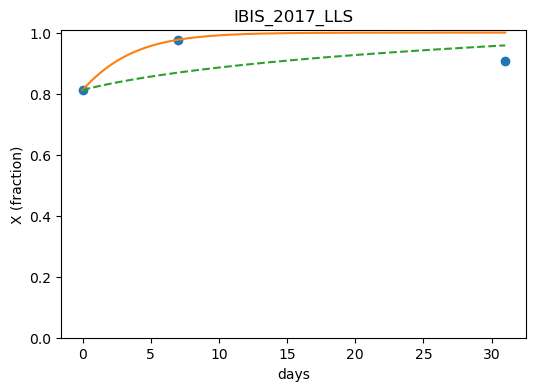

In [6]:
# Creating fits and plots for the datasets provided by the user.
# This will:
# - Fit simple logistic models (two variants) and Hill-type ODE models per instructions.
# - For SABLE_2018: fit logistic + full Hill (r, theta, n)
# - For other datasets: fit logistic + Hill with theta=0.5 and search n=1..10 (fit r only per n)
# - Filter X>1 when requested for logistic fits; if too few points, allow K free.
# - Produce plots for each dataset and a summary table of fit results.
# The code uses matplotlib (no seaborn) and will display a DataFrame via caas_jupyter_tools.display_dataframe_to_user.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, least_squares
from scipy.integrate import solve_ivp
import math

# Helper: logistic function (general t_mid form)
def logistic_tmid(t, r, t_mid):
    return 1.0 / (1.0 + np.exp(-r*(t - t_mid)))

# logistic solution with known X0 and K, allowing shift t0 by supplying t relative to first time
def logistic_solution_rel(t_rel, r, X0, K=1.0):
    A = (K / X0) - 1.0
    return K / (1.0 + A * np.exp(-r * t_rel))

# Hill ODE: dX/dt = r * (1/(1 + (X/K/theta)^n)) * X, with K fixed=1
def simulate_hill(times, r, theta, n, X0, K=1.0):
    def rhs(t, X):
        # Ensure scalar
        x = float(X)
        denom = 1.0 + (x / (K * theta))**n
        s = 1.0 / denom
        return r * s * x
    sol = solve_ivp(rhs, (times[0], times[-1]), [X0], t_eval=times, max_step=1.0)
    return sol.y[0]

# Hill with theta fixed (0.5) used in many fits:
def simulate_hill_theta_fixed(times, r, n, X0, theta=0.5, K=1.0):
    return simulate_hill(times, r, theta, n, X0, K=K)

# Fit functions
results = []  # collect dictionaries
plots = []

for name, data in r_studies.items():
    # extract times and X arrays robustly (keys differ)
    if 'X_frac' in data:
        times = np.array(data['times_days'])
        X = np.array(data['X_frac'])
    else:
        times = np.array(data['times_days'])
        X = np.array(data.get('X_frac_mean') if 'X_frac_mean' in data else data.get('X_frac_mean', data.get('X_frac')))
    # sort by time
    order = np.argsort(times)
    times = times[order]
    X = X[order]
    t0 = float(times[0])
    X0 = float(X[0])
    K = 1.0

    # Prepare plotting
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(times, X, marker='o', linestyle='none')  # raw data
    ax.set_xlabel('days')
    ax.set_ylabel('X (fraction)')
    ax.set_title(name)
    
    # ---------- Simple logistic fits ----------
    # Filter X<=1 for simple sigmoid fitting per instructions
    mask_le1 = X <= 1.0
    times_le1 = times[mask_le1]
    X_le1 = X[mask_le1]
    
    logistic_choice = None
    logistic_info = {}
    
    if len(times_le1) >= 3:
        # Try logistic_solution_rel (fit r only). Shift times relative to t0.
        t_rel = times_le1 - times_le1[0]
        try:
            popt_r, pcov = curve_fit(lambda tr, r: logistic_solution_rel(tr, r, X0=X_le1[0], K=K),
                                     t_rel, X_le1, p0=[0.1], bounds=([0.0001],[2.0]))
            r_fit_sol = float(popt_r[0])
            # compute residual
            pred_sol = logistic_solution_rel(times - times_le1[0], r_fit_sol, X0=X_le1[0], K=K)
            rss_sol = np.sum((pred_sol - X)**2)
        except Exception as e:
            r_fit_sol = np.nan
            rss_sol = np.inf
        
        # Try logistic_tmid (fit r and t_mid)
        try:
            p0 = [0.1, 7.0]
            bounds = ([0.0001, -1000], [2.0, 1000])
            popt2, pcov2 = curve_fit(logistic_tmid, times_le1, X_le1, p0=p0, bounds=bounds, maxfev=20000)
            r_fit_tmid = float(popt2[0])
            tmid_fit = float(popt2[1])
            pred_tmid = logistic_tmid(times, r_fit_tmid, tmid_fit)
            rss_tmid = np.sum((pred_tmid - X)**2)
        except Exception as e:
            r_fit_tmid = np.nan
            tmid_fit = np.nan
            rss_tmid = np.inf
        
        # Choose the logistic variant with lower RSS
        if rss_sol <= rss_tmid:
            logistic_choice = 'logistic_solution_rel'
            logistic_info['r'] = r_fit_sol
            logistic_info['t_shift_used'] = float(times_le1[0])
            logistic_info['rss'] = float(rss_sol)
            # plot
            t_plot = np.linspace(times[0], times[-1], 200)
            t_rel_plot = t_plot - times_le1[0]
            y_plot = logistic_solution_rel(t_rel_plot, r_fit_sol, X0=X_le1[0], K=K)
            ax.plot(t_plot, y_plot, linestyle='-')
        else:
            logistic_choice = 'logistic_tmid'
            logistic_info['r'] = r_fit_tmid
            logistic_info['t_mid'] = tmid_fit
            logistic_info['rss'] = float(rss_tmid)
            # plot
            t_plot = np.linspace(times[0], times[-1], 200)
            y_plot = logistic_tmid(t_plot, r_fit_tmid, tmid_fit)
            ax.plot(t_plot, y_plot, linestyle='-')
    else:
        # too few points after filtering: fit logistic_solution but allow K free (fit r and K)
        # Use original times, shift to t0 for numerical stability
        t_rel_full = times - t0
        def logistic_with_K(t_rel, r, Kparam):
            A = (Kparam / X0) - 1.0
            return Kparam / (1.0 + A * np.exp(-r * t_rel))
        try:
            popt_k, pcov_k = curve_fit(logistic_with_K, t_rel_full, X, p0=[0.1, 1.0], bounds=([0.0001,0.1],[2.0,10.0]), maxfev=20000)
            r_fit_k = float(popt_k[0])
            K_fit_k = float(popt_k[1])
            pred_k = logistic_with_K(t_rel_full, r_fit_k, K_fit_k)
            rss_k = np.sum((pred_k - X)**2)
            logistic_choice = 'logistic_K_free'
            logistic_info['r'] = r_fit_k
            logistic_info['K'] = K_fit_k
            logistic_info['rss'] = float(rss_k)
            # plot
            t_plot = np.linspace(times[0], times[-1], 200)
            y_plot = logistic_with_K(t_plot - t0, r_fit_k, K_fit_k)
            ax.plot(t_plot, y_plot, linestyle='-')
        except Exception as e:
            logistic_choice = 'logistic_failed'
            logistic_info['r'] = np.nan
            logistic_info['rss'] = np.nan
    
    # ---------- Hill-type fits ----------
    # For SABLE_2018: fit r, theta, n (all free)
    hill_info = {}
    # if name == 'SABLE_2018':
    #     # Use full dataset (don't filter for Hill)
    #     times_full = times
    #     X_full = X
    #     # Use earliest point as X0 and t0
    #     tspan = times_full
    #     def residuals_sable(params):
    #         r_p, theta_p, n_p = params
    #         if r_p <= 0 or theta_p <= 0 or n_p <= 0:
    #             return 1e6 * np.ones_like(X_full)
    #         pred = simulate_hill(times_full, r_p, theta_p, n_p, X0, K=K)
    #         return pred - X_full
    #     # initial guesses
    #     x0 = [0.1, 0.5, 2.0]
    #     lb = [1e-4, 1e-3, 0.1]
    #     ub = [2.0, 2.0, 10.0]
    #     try:
    #         res = least_squares(residuals_sable, x0, bounds=(lb, ub), xtol=1e-8, ftol=1e-8, max_nfev=5000)
    #         r_hill, theta_hill, n_hill = res.x
    #         pred_hill = simulate_hill(times_full, r_hill, theta_hill, n_hill, X0, K=K)
    #         rss_hill = np.sum((pred_hill - X_full)**2)
    #         hill_info['r'] = float(r_hill)
    #         hill_info['theta'] = float(theta_hill)
    #         hill_info['n'] = float(n_hill)
    #         hill_info['rss'] = float(rss_hill)
    #         # plot
    #         t_plot = np.linspace(times_full[0], times_full[-1], 400)
    #         y_plot = simulate_hill(t_plot, r_hill, theta_hill, n_hill, X0, K=K)
    #         ax.plot(t_plot, y_plot, linestyle='--')
    #     except Exception as e:
    #         hill_info['r'] = np.nan
    #         hill_info['theta'] = np.nan
    #         hill_info['n'] = np.nan
    #         hill_info['rss'] = np.nan
    # else:
    # For other datasets: theta fixed=0.5, screen n from 1..10, fit r for each n
    times_full = times
    X_full = X
    best = {'rss': np.inf}
    n_tries = np.linspace(1, 21, 40)
    for i, n_try in enumerate(n_tries):
        # Fit r only using least_squares (residual = simulate - data)
        def res_r(x):
            r_try = float(x[0])
            if r_try <= 0:
                return 1e6 * np.ones_like(X_full)
            pred = simulate_hill_theta_fixed(times_full, r_try, n_try, X0, theta=0.5, K=K)
            return pred - X_full
        try:
            res = least_squares(res_r, x0=[0.1], bounds=([1e-4],[2.0]), xtol=1e-8, ftol=1e-8, max_nfev=2000)
            r_try = float(res.x[0])
            pred_try = simulate_hill_theta_fixed(times_full, r_try, n_try, X0, theta=0.5, K=K)
            rss_try = np.sum((pred_try - X_full)**2)
            if rss_try < best['rss']:
                best = {'n': n_try, 'r': r_try, 'rss': rss_try, 'pred': pred_try}
        except Exception as e:
            pass
    if best['rss'] < np.inf:
        hill_info['r'] = float(best['r'])
        hill_info['n'] = int(best['n'])
        hill_info['theta'] = 0.5
        hill_info['rss'] = float(best['rss'])
        # plot best hill
        t_plot = np.linspace(times_full[0], times_full[-1], 400)
        y_plot = simulate_hill_theta_fixed(t_plot, best['r'], best['n'], X0, theta=0.5, K=K)
        ax.plot(t_plot, y_plot, linestyle='--')
    else:
        hill_info['r'] = np.nan
        hill_info['n'] = np.nan
        hill_info['theta'] = 0.5
        hill_info['rss'] = np.nan

    # finalize plot
    ax.set_ylim(bottom=0)
    plots.append(fig)
    
    # Save results
    res_entry = {
        'dataset': name,
        'logistic_variant': logistic_choice,
        'logistic_r': logistic_info.get('r', np.nan),
        'logistic_tmid_or_shift': logistic_info.get('t_mid', logistic_info.get('t_shift_used', np.nan)),
        'logistic_rss': logistic_info.get('rss', np.nan),
        'hill_r': hill_info.get('r', np.nan),
        'hill_theta': hill_info.get('theta', np.nan),
        'hill_n': hill_info.get('n', np.nan),
        'hill_rss': hill_info.get('rss', np.nan),
        'X0_used': X0,
        't0_used': t0
    }
    # If logistic had K free, include K
    if 'K' in logistic_info:
        res_entry['logistic_K'] = logistic_info['K']
    results.append(res_entry)

# Display a results DataFrame using caas_jupyter_tools helper
df = pd.DataFrame(results)
# Round some columns for readability
for col in ['logistic_r','logistic_tmid_or_shift','logistic_rss','hill_r','hill_theta','hill_n','hill_rss','logistic_K']:
    if col in df.columns:
        df[col] = df[col].apply(lambda x: np.round(x,6) if (not pd.isna(x) and np.isfinite(x)) else x)

df

# # Show plots inline (one figure per dataset)
# for fig in plots:
#     display(fig)
#     plt.close(fig)

# # Also print a short textual summary
# print("Completed fits. Table titled 'Fit results summary' displayed and individual dataset plots shown.")


### chk2

In [ ]:
# import numpy as np
# import pandas as pd
# from scipy.optimize import curve_fit
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Logistic function
# def logistic(t, r, t_mid):
#     return 1.0 / (1.0 + np.exp(-r*(t - t_mid)))

# params, r, tmid = {}, {}, {}
# for dataset in r_studies.keys():
#     times = r_studies[dataset]['times_days']
#     X = r_studies[dataset]['X_frac']
#     params[dataset], _ = curve_fit(logistic, times, X, p0=[0.01,0], bounds=([0,-300],[2,100]))
#     r[dataset], tmid[dataset] = params[dataset]

In [ ]:
# # Hill ODE: dX/dt = r * (1/(1 + (X/K/theta)^n)) * X, with K fixed=1
# def simulate_hill(times, r, theta, n, X0, K=1.0):
#     def rhs(t, X):
#         # Ensure scalar
#         x = float(X)
#         denom = 1.0 + (x / (K * theta))**n
#         s = 1.0 / denom
#         return r * s * x
#     sol = solve_ivp(rhs, (times[0], times[-1]), [X0], t_eval=times, max_step=1.0)
#     return sol.y[0]

# # Hill with theta fixed (0.5) used in all fits:
# def simulate_hill_theta_fixed(times, r, n, X0, theta=0.5, K=1.0):
#     return simulate_hill(times, r, theta, n, X0, K=K)

# params_hill = {}
# for dataset in r_studies.keys():
#     times = np.array(r_studies[dataset]['times_days'])
#     X = np.array(r_studies[dataset]['X_frac'])
#     mask_le1 = X <= 1.0
#     times_le1 = times[mask_le1]
#     X_le1 = X[mask_le1]
#     X0 = float(X[0])
#     K=1.0
#     hill_info = {}

#     best = {'rss': np.inf}
#     n_tries = np.linspace(1, 21, 40)
#     for i, n_try in enumerate(n_tries):
#         # Fit r only using least_squares (residual = simulate - data)
#         def res_r(x):
#             r_try = float(x[0])
#             if r_try <= 0:
#                 return 1e6 * np.ones_like(X_le1)
#             pred = simulate_hill_theta_fixed(times_le1, r_try, n_try, X0, theta=0.5, K=K)
#             return pred - X_le1
#         try:
#             res = least_squares(res_r, x0=[0.1], bounds=([1e-4],[2.0]), xtol=1e-8, ftol=1e-8, max_nfev=2000)
#             r_try = float(res.x[0])
#             pred_try = simulate_hill_theta_fixed(times_le1, r_try, n_try, X0, theta=0.5, K=K)
#             rss_try = np.sum((pred_try - X_le1)**2)
#             if rss_try < best['rss']:
#                 best = {'n': n_try, 'r': r_try, 'rss': rss_try, 'pred': pred_try}
#         except Exception as e:
#             pass
#     if best['rss'] < np.inf:
#         hill_info['r'] = float(best['r'])
#         hill_info['n'] = int(best['n'])
#         hill_info['theta'] = 0.5
#         hill_info['rss'] = float(best['rss'])
#     else:
#         hill_info['r'] = np.nan
#         hill_info['n'] = np.nan
#         hill_info['theta'] = 0.5
#         hill_info['rss'] = np.nan
    
#     params_hill[dataset] = hill_info

{'SABLE_2018': {'r': nan, 'n': nan, 'theta': 0.5, 'rss': nan},
 'KIM_2024_GROUP_A': {'r': 0.13679586866625948,
  'n': 9,
  'theta': 0.5,
  'rss': 8.943814491831461e-07},
 'KIM_2024_GROUP_B': {'r': 0.10578850513719232,
  'n': 10,
  'theta': 0.5,
  'rss': 1.1450865889597257e-05},
 'WANG_2024_REMNANT_RIGHT': {'r': 0.5297993682483175,
  'n': 13,
  'theta': 0.5,
  'rss': 0.00032576981283523413},
 'WANG_2024_REMNANT_LEFT': {'r': 1.013043553356847,
  'n': 14,
  'theta': 0.5,
  'rss': 0.0002900447587534641},
 'GONG_2019': {'r': 1.999999995515661,
  'n': 14,
  'theta': 0.5,
  'rss': 0.0029621757874531114},
 'IBIS_2017_RHH': {'r': 0.6580396618787783,
  'n': 14,
  'theta': 0.5,
  'rss': 5.925435015726371e-07},
 'IBIS_2017_LLS': {'r': 1.9999659450555343,
  'n': 10,
  'theta': 0.5,
  'rss': 0.014389679296223071},
 'YAMAMOTO_2016': {'r': 1.956394617158283,
  'n': 14,
  'theta': 0.5,
  'rss': 0.012968051549805851}}

In [ ]:
# res_df = pd.concat([pd.Series(r, name='r_logistic'), pd.DataFrame(params_hill).T], axis=1)
# res_df

,r_logistic,r,n,theta,rss
SABLE_2018,0.211126,NaN,NaN,0.5,NaN
KIM_2024_GROUP_A,0.021385,0.136796,9.0,0.5,8.943814e-07
KIM_2024_GROUP_B,0.015592,0.105789,10.0,0.5,1.145087e-05
WANG_2024_REMNANT_RIGHT,0.003757,0.529799,13.0,0.5,3.257698e-04
WANG_2024_REMNANT_LEFT,0.036641,1.013044,14.0,0.5,2.900448e-04
GONG_2019,0.011564,2.000000,14.0,0.5,2.962176e-03
IBIS_2017_RHH,0.045956,0.658040,14.0,0.5,5.925435e-07
IBIS_2017_LLS,0.323804,1.999966,10.0,0.5,1.438968e-02
YAMAMOTO_2016,0.008458,1.956395,14.0,0.5,1.296805e-02


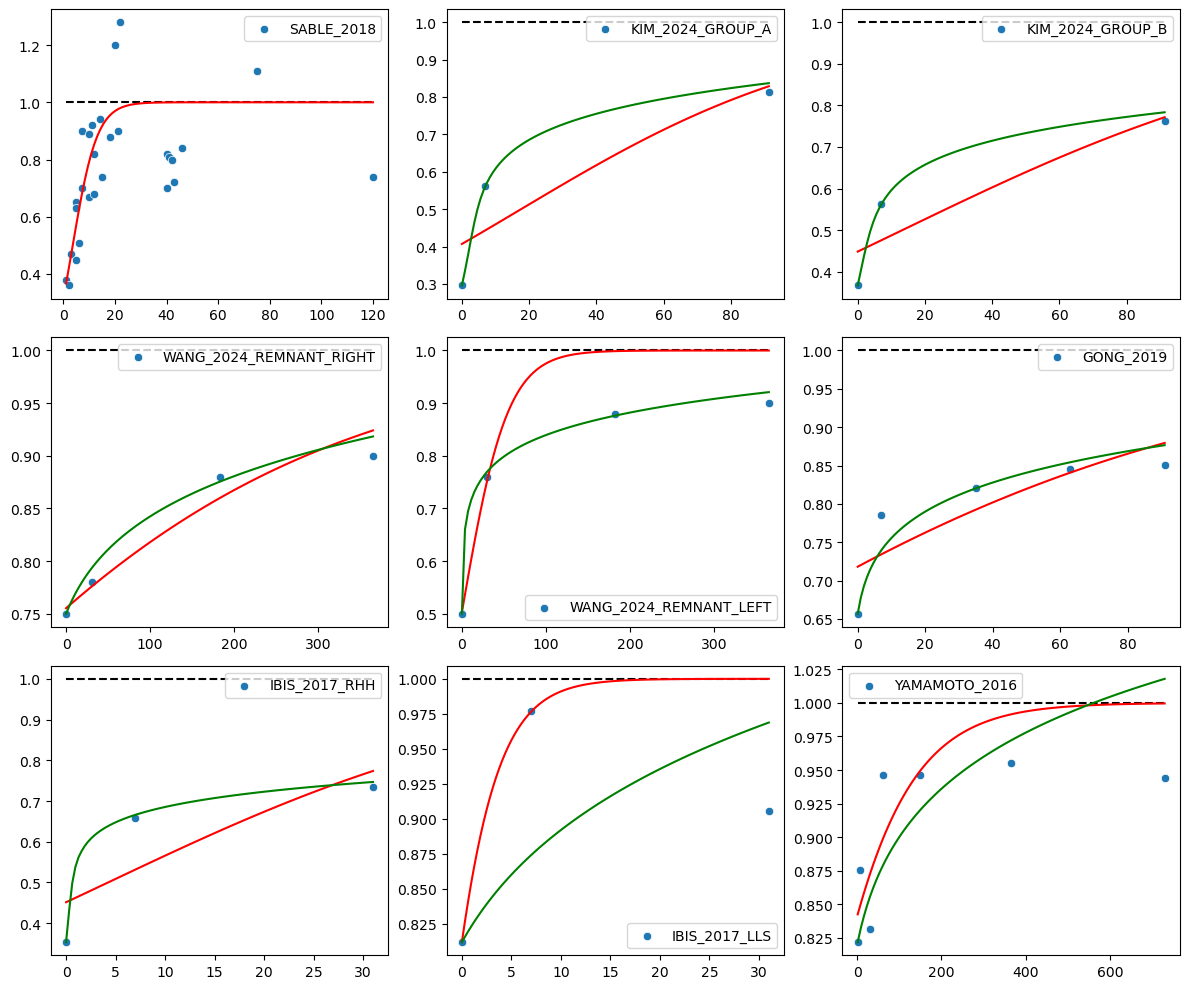

In [ ]:
# ncols = 3
# nrows = 3
# fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 10))
# axs = axs.ravel()
# for i, (dataset, ax) in enumerate(zip(r_studies.keys(), axs)):
#     x = np.array(r_studies[dataset]['times_days'])
#     y = np.array(r_studies[dataset]['X_frac'])
#     x_cont = np.linspace(x.min(),x.max(),10**2)
#     y_hat = logistic(x_cont, r[dataset], tmid[dataset])

#     ax.hlines(xmin=x_cont.min(), xmax=x_cont.max(), y=1, linestyles='--', colors='k')
    
#     sns.scatterplot(x=x, y=y, ax=ax, label=dataset)
#     sns.lineplot(x=x_cont, y=y_hat, c='r', ax=ax)

#     if str(params_hill[dataset]['r']) != 'nan':
#         # mask_le1 = y <= 1.0
#         # times_le1 = x[mask_le1]
#         # X_le1 = y[mask_le1]
#         # x_cont_hill = np.linspace(times_le1[0], times_le1[-1], 100)
#         y_hat_hill = simulate_hill_theta_fixed(x_cont, params_hill[dataset]['r'], params_hill[dataset]['n'], X0=y[0], theta=0.5, K=K)
#         sns.lineplot(x=x_cont, y=y_hat_hill, c='g', ax=ax)
# fig.tight_layout()
# plt.show()

### Fit r per severity group
$$\frac{dX}{dt} = r \cdot \frac{1}{1 + \left( \frac{X}{\theta K} \right)^n} \cdot X $$
$$ \theta = 0.5, n = const \text{ for all severity groups} $$

In [129]:
"""
Pooled Hill-model analysis (Frequentist + Bayesian)

This notebook-style Python script implements two end-to-end pipelines:
  1) Frequentist pooled fit (grid over Hill exponent `n`, pooled group r's + per-dataset X0,
     profile-likelihood CIs for group r's, and parametric bootstrap as a secondary check).
  2) Bayesian hierarchical fit (pure-Python via emcee) that infers group-level mu_r and
     dataset-level r_i and X0, for a fixed `n` (you can loop the grid if desired).

How to use:
  - Run the cells sequentially.
  - Tune the `n_grid`, bootstrap count, and emcee settings depending on your machine.
  - Save results to disk once you have them so you don't need to re-run costly sampling.

Notes and recommendations:
  - Mapping to groups is now done by the FIRST-OBSERVATION MEAN (X_frac[0]).
  - theta is fixed to 0.5 in all runs.
  - r bounds are [0, 10] (numerically enforced as [1e-8, 10.0]).
  - For Bayesian sampling we use emcee (no gradients).
  - The emcee posterior is computed for a fixed n. To scan n you can run the Bayesian block across the n-grid.

Dependencies:
  pip install numpy scipy pandas matplotlib seaborn emcee tqdm

"""

"\nPooled Hill-model analysis (Frequentist + Bayesian)\n\nThis notebook-style Python script implements two end-to-end pipelines:\n  1) Frequentist pooled fit (grid over Hill exponent `n`, pooled group r's + per-dataset X0,\n     profile-likelihood CIs for group r's, and parametric bootstrap as a secondary check).\n  2) Bayesian hierarchical fit (pure-Python via emcee) that infers group-level mu_r and\n     dataset-level r_i and X0, for a fixed `n` (you can loop the grid if desired).\n\nHow to use:\n  - Run the cells sequentially.\n  - Tune the `n_grid`, bootstrap count, and emcee settings depending on your machine.\n  - Save results to disk once you have them so you don't need to re-run costly sampling.\n\nNotes and recommendations:\n  - Mapping to groups is now done by the FIRST-OBSERVATION MEAN (X_frac[0]).\n  - theta is fixed to 0.5 in all runs.\n  - r bounds are [0, 10] (numerically enforced as [1e-8, 10.0]).\n  - For Bayesian sampling we use emcee (no gradients).\n  - The emcee po

In [130]:
# # -------------------------------
# # 1) Data: r_studies (embedded copy)
# # -------------------------------

# r_studies = {
#     'SABLE_2018': {
#         'times_days': np.array([  1,   3,   5,   6,   7,   2,   5,   7,  10,  11,  12,  14,   5,
#                                   10,  12,  15,  18,  20,  21,  22,  40,  40,  41,  42,  43,  46,
#                                   75, 120 ]),
#         'X_frac': np.array([0.38,0.47,0.65,0.51,0.90,0.36,0.63,0.70,0.89,0.92,0.82,0.94,0.45,0.67,0.68,
#                              0.74,0.88,1.20,0.90,1.28,0.70,0.82,0.81,0.80,0.72,0.84,1.11,0.74]),
#     },

#     'KIM_2024_GROUP_A': {
#         'times_days': np.array([0, 7.0, 91.3125]),
#         'X_frac': np.array([0.296, 0.561, 0.813]),
#         'X_frac_ci': np.array([0.018, 0.075, 0.134]),
#     },

#     'KIM_2024_GROUP_B': {
#         'times_days': np.array([0, 7.0, 91.3125]),
#         'X_frac': np.array([0.367, 0.563, 0.762]),
#         'X_frac_ci': np.array([0.048, 0.078, 0.107]),
#     },

#     'WANG_2024_REMNANT_RIGHT': {
#         'times_days': np.array([0.0, 30.4375, 182.625, 365.25]),
#         'X_frac': np.array([0.75, 0.78, 0.88, 0.9]),
#         'X_frac_ci': np.array([0.07, 0.25, 0.14, 0.1]),
#     },

#     'WANG_2024_REMNANT_LEFT': {
#         'times_days': np.array([0.0, 30.4375, 182.625, 365.25]),
#         'X_frac': np.array([0.5, 0.76, 0.88, 0.9]),
#         'X_frac_ci': np.array([0.1, 0.3, 0.27, 0.2]),
#     },

#     'GONG_2019': {
#         'times_days': np.array([0., 7., 35., 63., 91.]),
#         'X_frac': np.array([0.65671642, 0.78606965, 0.82089552, 0.84577114, 0.85074627]),
#         'X_frac_ci': np.array([0.19900498, 0.17910448, 0.17412935, 0.1641791 , 0.1641791 ]),
#     },

#     'IBIS_2017_RHH': {
#         'times_days': np.array([0.0, 7.0, 31.0]),
#         'X_frac': np.array([0.35354273, 0.65741417, 0.73338203]),
#         'X_frac_ci': np.array([0.17823229, 0.18626735, 0.19101534]),
#     },

#     'IBIS_2017_LLS': {
#         'times_days': np.array([0.0, 7.0, 31.0]),
#         'X_frac': np.array([0.81196013, 0.97674419, 0.90564784]),
#         'X_frac_ci': np.array([0.27109635, 0.2654485 , 0.35614618]),
#     },

#     'YAMAMOTO_2016': {
#         'times_days': np.array([1, 7, 30, 60, 150, 365, 730]),
#         'X_frac': np.array([0.82188466, 0.87539964, 0.83130982, 0.9466702 , 0.94646015, 0.95550741, 0.94372618]),
#         'X_frac_ci': np.array([0.02606226, 0.05370439, 0.06625629, 0.03977659, 0.02516157, 0.0352281 , 0.04189607]),
#     }
# }

### Helper functions

In [153]:
# ===== helper functions for data conversion / saving / loading =====

def _numpy_to_py(o):
    """Recursively convert numpy arrays to python lists in dicts."""
    if isinstance(o, np.ndarray):
        return o.tolist()
    if isinstance(o, dict):
        return {k: _numpy_to_py(v) for k, v in o.items()}
    if isinstance(o, (list, tuple)):
        return [_numpy_to_py(v) for v in o]
    return o

def _py_to_numpy(o):
    """Recursively convert lists to numpy arrays when appropriate."""
    if isinstance(o, dict):
        return {k: _py_to_numpy(v) for k, v in o.items()}
    if isinstance(o, list):
        # try to convert lists of numbers to numpy arrays
        try:
            arr = np.array([_py_to_numpy(v) for v in o])
            return arr
        except Exception:
            return [_py_to_numpy(v) for v in o]
    return o

def save_r_studies_json(path: str, r_studies: dict):
    """Save the r_studies dict (with numpy arrays) to JSON."""
    p = Path(path)
    p.parent.mkdir(parents=True, exist_ok=True)
    with open(p, 'w') as f:
        json.dump(_numpy_to_py(r_studies), f, indent=2)
    print(f'Saved r_studies to {p}')

def load_r_studies_json(path: str) -> dict:
    """Load r_studies from JSON and convert lists back to numpy arrays where possible."""
    with open(path, 'r') as f:
        raw = json.load(f)
    return _py_to_numpy(raw)


# ===== helper functions for: Hill-type sigmoid simulation, SABLE pre-processing, general data preprocessing =====

def simulate_hill(times: np.ndarray, r: float, theta: float, n: float, X0: float, K: float = 1.0) -> np.ndarray:
    times = np.asarray(times, dtype=float)
    if times.size == 0:
        return np.array([])
    Xvals = np.empty_like(times, dtype=float)
    Xvals[0] = X0
    for i in range(len(times) - 1):
        dt = times[i + 1] - times[i]
        m = max(1, int(np.ceil(dt / 0.5)))
        h = dt / m
        x = Xvals[i]
        for _ in range(m):
            denom = 1.0 + (x / (K * theta)) ** n
            dx = r * (1.0 / denom) * x
            x = x + h * dx
            if x <= 0:
                x = 1e-12
        Xvals[i + 1] = x
    return Xvals


def sable_binning_and_sigma(times_days: np.ndarray, X_frac: np.ndarray, bin_width: float = 2.0, early_phase_end: float = 20.0):
    times_days = np.asarray(times_days, dtype=float)
    X_frac = np.asarray(X_frac, dtype=float)
    max_t = float(times_days.max())
    bin_edges = np.arange(0.0, max_t + bin_width + 1e-9, bin_width)
    bin_idx = np.digitize(times_days, bin_edges) - 1
    early_mask = times_days <= early_phase_end
    if early_mask.sum() < 3:
        sd_resid = np.std(X_frac[early_mask], ddof=1) if early_mask.sum() > 1 else 0.05
        df_pool = max(1, early_mask.sum() - 1)
    else:
        try:
            from scipy.optimize import curve_fit
            t_early = times_days[early_mask]
            x_early = X_frac[early_mask]
            popt, _ = curve_fit(lambda t, r, t_shift: 1.0 / (1.0 + np.exp(-r * (t - t_shift))),
                                t_early, x_early, p0=[0.2, 7.0], bounds=([1e-6, -100], [2.0, 100]), maxfev=10000)
            resid_early = x_early - (1.0 / (1.0 + np.exp(-popt[0] * (t_early - popt[1]))))
            sd_resid = float(np.std(resid_early, ddof=1))
            df_pool = len(resid_early) - 1
        except Exception:
            sd_resid = float(np.std(X_frac[early_mask], ddof=1)) if X_frac[early_mask].size > 1 else 0.05
            df_pool = max(1, X_frac[early_mask].size - 1)
    try:
        from scipy.stats import t as tdist
        tcrit = float(tdist.ppf(0.975, df=max(1, df_pool)))
    except Exception:
        tcrit = 2.0
    bin_centers = []
    mean_times = []
    mean_X = []
    counts = []
    ci95_list = []
    for b in range(len(bin_edges) - 1):
        mask = bin_idx == b
        if mask.sum() == 0:
            continue
        bin_centers.append((bin_edges[b] + bin_edges[b + 1]) / 2.0)
        mean_times.append(times_days[mask].mean())
        mean_X.append(X_frac[mask].mean())
        n_points = int(mask.sum())
        counts.append(n_points)
        ci95 = tcrit * sd_resid / math.sqrt(n_points)
        ci95_list.append(float(ci95))
    df = pd.DataFrame({'bin_center': bin_centers, 'time': mean_times, 'X': mean_X, 'n': counts, 'ci95': ci95_list})
    df['sigma'] = df['ci95'] / 1.96
    return df


def prepare_datasets(r_studies: dict):
    studies = deepcopy(r_studies)
    sable = studies.get('SABLE_2018')
    if sable is not None:
        sable_df = sable_binning_and_sigma(sable['times_days'], sable['X_frac'], bin_width=2.0, early_phase_end=20.0)
        studies['SABLE_2018']['binned_time'] = sable_df['time'].to_numpy()
        studies['SABLE_2018']['binned_X'] = sable_df['X'].to_numpy()
        studies['SABLE_2018']['binned_sigma'] = sable_df['sigma'].to_numpy()
    dataset_list = []
    for name, data in studies.items():
        if name == 'SABLE_2018':
            times = np.asarray(data['binned_time'], dtype=float)
            X = np.asarray(data['binned_X'], dtype=float)
            sigma = np.asarray(data['binned_sigma'], dtype=float)
        else:
            times = np.asarray(data['times_days'], dtype=float)
            X = np.asarray(data['X_frac'], dtype=float)
            if 'X_frac_ci' in data:
                sigma = np.asarray(data['X_frac_ci'], dtype=float) / 1.96
            else:
                sigma = np.full_like(X, 0.05, dtype=float)
        order = np.argsort(times)
        times = times[order]; X = X[order]; sigma = sigma[order]
        mask_le1 = X <= 1.0
        times = times[mask_le1]; X = X[mask_le1]; sigma = sigma[mask_le1]
        dataset_list.append({'name': name, 'times': times, 'X': X, 'sigma': sigma})
    return dataset_list

# mapping by first-observation mean (user requested)
def map_to_group_by_mean(dataset: dict):
    X = dataset['X']
    if X.size == 0:
        return 'mid'
    x0 = float(X[0])
    if x0 < 0.4:
        return 'low'
    if x0 > 0.7:
        return 'high'
    return 'mid'

# ===== saving frequentist results =====

def save_freq_results(outdir: str, result: dict):
    p = Path(outdir)
    p.mkdir(parents=True, exist_ok=True)
    # grid df
    grid_df = pd.DataFrame([{'n':g['n'],'rss':g['rss'],'r_low':g['r'][0],'r_mid':g['r'][1],'r_high':g['r'][2]} for g in result['grid']])
    grid_df.to_csv(p / 'freq_grid.csv', index=False)
    # bootstrap
    result['bootstrap_df'].to_csv(p / 'freq_bootstrap.csv', index=False)
    # summary
    summary = {
        'best_n': result['best_n'],
        'best_r': list(map(float, result['best_r'])),
        'profile': result['profile']
    }
    with open(p / 'freq_summary.json', 'w') as f:
        json.dump(_numpy_to_py(summary), f, indent=2)
    print('Saved frequentist results to', p)

# ===== saving bayes results =====

def save_bayes_results(outdir: str, bayes_result: dict):
    """
    posterior_samples: dict of arrays to persist, e.g. {'mu_r': mu_samples, 'r_i': r_i_samples, 'X0': X0_samples}
    summary: dict with means/CI for mu_r, etc.
    """
    p = Path(outdir)
    p.mkdir(parents=True, exist_ok=True)
    # save summary
    with open(p / 'bayes_summary.json', 'w') as f:
        json.dump(_numpy_to_py(bayes_result['summary']), f, indent=2)
    # save posterior arrays
    np.savez_compressed(p / 'bayes_posterior.npz', **{k: np.asarray(v) for k, v in bayes_result['posterior_samples'].items()})
    # optional csv for mu_r samples
    if 'mu_r' in bayes_result['posterior_samples']:
        mu_samps = bayes_result['posterior_samples']['mu_r']
        pd.DataFrame(mu_samps, columns=['mu_low','mu_mid','mu_high']).to_csv(p / 'bayes_mu_r_samples.csv', index=False)
    print('Saved Bayesian results to', p)

# ===== loading frequentist results =====

def load_freq_results(outdir, r_studies=r_studies):
    outdir = Path(outdir)   # change to your folder
    grid_df = pd.read_csv(outdir / 'freq_grid.csv')             # n, rss, r_low, r_mid, r_high
    bootstrap_df = pd.read_csv(outdir / 'freq_bootstrap.csv')   # r_low, r_mid, r_high
    with open(outdir / 'freq_summary.json') as f:
        summary = json.load(f)
    # summary contains at least: best_n, best_r, profile
    best_n = float(summary.get('best_n'))
    best_r = np.array(summary.get('best_r'))  # shape (3,)
    # reconstruct grid_out (list-of-dicts) if any code expects it:
    grid_list = []
    for _, row in grid_df.iterrows():
        grid_list.append({'n': float(row['n']),
                        'rss': float(row['rss']),
                        'r': np.array([row['r_low'], row['r_mid'], row['r_high']])})
    datasets = prepare_datasets(r_studies)
    groups = [map_to_group_by_mean(d) for d in datasets]
    # best_X0 may NOT have been saved by default — set fallback to first observed X per dataset:
    best_X0 = [ (float(d['X'][0]) if d['X'].size>0 else 0.1) for d in datasets ]
    # assemble freq_result dict compatible with plotting helpers:
    freq_result = {
        'grid': grid_list,
        'grid_df': grid_df,
        'best_n': best_n,
        'best_r': best_r,           # can be array or list
        'best_X0': best_X0,
        'profile': summary.get('profile', {}),
        'bootstrap_df': bootstrap_df,
        'datasets': datasets,
        'group_map': groups
    }
    return freq_result

# ===== loading bayesian results =====

def load_bayes_results(outdir, r_studies=r_studies):
    outdir = Path(outdir)
    with open(outdir / 'bayes_summary.json') as f:
        bayes_summary = json.load(f)
    npz = np.load(outdir / 'bayes_posterior.npz', allow_pickle=True)
    print('npz keys:', list(npz.keys()))
    mu_r = npz['mu_r']        # shape (n_samples, 3)
    tau_r = npz['tau_r']      # shape (n_samples, 3)
    r_i = npz['r_i']          # shape (n_samples, n_datasets)
    X0_samples = npz['X0']    # shape (n_samples, n_datasets)
    mu_df = pd.read_csv(outdir / 'bayes_mu_r_samples.csv')
    datasets = prepare_datasets(r_studies)
    groups = [map_to_group_by_mean(d) for d in datasets]
    bayes_result = {
        'posterior_samples': {'mu_r': mu_r, 'tau_r': tau_r, 'r_i': r_i, 'X0': X0_samples},
        'mu_df': mu_df,
        'summary': bayes_summary,
        'datasets': datasets,
        'group_map': groups,
        'n_val': bayes_summary.get('n_val', None),
        'sampler': None   # sampler object isn't saved by default; you can pickle it if you want
    }
    return bayes_result

### Frequentist pooled pipeline (grid + profile + bootstrap)

In [132]:
# def r_estimation_frequentist(r_studies, n_grid=None, theta=0.5, r_bounds=(1e-8,5.0), bootstrap_n=50, 
#                              profile_pts=30, out_prefix='./r_out_freq', verbose=True):
#     datasets = prepare_datasets(r_studies)
#     names = [d['name'] for d in datasets]
#     groups = [map_to_group_by_mean(d) for d in datasets]
#     group_names = ['low','mid','high']
#     group_idx = np.array([group_names.index(g) for g in groups], dtype=int)

#     times_list = [d['times'] for d in datasets]
#     X_list = [d['X'] for d in datasets]
#     sigma_list = [d['sigma'] for d in datasets]
#     obs_times = np.concatenate(times_list)
#     obs_X = np.concatenate(X_list)
#     obs_sigma = np.concatenate(sigma_list)
#     init_X0 = np.array([float(d['X'][0]) if d['X'].size>0 else 0.1 for d in datasets])
#     M = len(datasets)

#     def resid_stack(params, n_val):
#         rvals = params[:3]
#         X0vals = params[3:3+M]
#         preds = []
#         for i,d in enumerate(datasets):
#             preds.append(simulate_hill(d['times'], rvals[group_idx[i]], theta, n_val, X0vals[i]))
#         pred_all = np.concatenate(preds)
#         return (obs_X - pred_all) / obs_sigma

#     def fit_n(n_val, x0=None):
#         if x0 is None:
#             p0 = np.concatenate(([0.2,0.2,0.2], init_X0))
#         else:
#             p0 = x0
#         lb = np.concatenate(([r_bounds[0]]*3, np.full(M,1e-6)))
#         ub = np.concatenate(([r_bounds[1]]*3, np.full(M,2.0)))
#         sol = least_squares(lambda p: resid_stack(p, n_val), x0=p0, bounds=(lb,ub), max_nfev=8000)
#         rss = float(np.sum(sol.fun**2))
#         r_est = sol.x[:3].copy(); X0_est = sol.x[3:3+M].copy()
#         # covariance approx
#         try:
#             J = sol.jac; Nobs = len(obs_X); nparams = len(sol.x); dof = max(1, Nobs-nparams)
#             JTJ = J.T.dot(J)
#             cov = np.linalg.inv(JTJ) * (rss/dof)
#             se = np.sqrt(np.maximum(np.diag(cov)[:3], 1e-12))
#         except Exception:
#             cov=None; se=np.array([np.nan]*3)
#         return {'success': sol.success, 'r': r_est, 'X0': X0_est, 'rss': rss, 'se': se, 'sol': sol}

#     if n_grid is None:
#         n_grid = np.round(np.arange(1.0, 30.0 + 0.25, 0.5),2)

#     grid_out = []
#     for n_val in tqdm(n_grid, desc='freq: grid n'):
#         res = fit_n(n_val)
#         grid_out.append({'n': float(n_val), 'r': res['r'], 'X0': res['X0'], 'rss': res['rss'], 'se': res['se'], 'success': res['success']})

#     grid_df = pd.DataFrame([{'n':g['n'],'rss':g['rss'],'r_low':g['r'][0],'r_mid':g['r'][1],'r_high':g['r'][2]} for g in grid_out])
#     grid_df.sort_values('rss', inplace=True)

#     best = min(grid_out, key=lambda g: g['rss'])
#     best_n = best['n']
#     best_fit = best

#     # profile likelihood per r group
#     cutoff = st.chi2.ppf(0.95, df=1)
#     profile = {}
#     for idx in range(3):
#         r_hat = best_fit['r'][idx]
#         if r_hat <= 0 or np.isnan(r_hat):
#             grid = np.linspace(1e-6, 1.0, profile_pts)
#         else:
#             low = max(1e-6, r_hat*0.05)
#             high = min(r_bounds[1], max(r_hat*5.0, r_hat+1.0))
#             grid = np.linspace(low, high, profile_pts)
#         rss_vals = []
#         for rfix in grid:
#             def resid_fix(p):
#                 # p: other two r's followed by X0s
#                 rvals = []
#                 it = 0
#                 for j in range(3):
#                     if j==idx:
#                         rvals.append(float(rfix))
#                     else:
#                         rvals.append(p[it]); it+=1
#                 X0vals = p[it:it+M]
#                 preds = []
#                 for i,d in enumerate(datasets):
#                     preds.append(simulate_hill(d['times'], rvals[group_idx[i]], theta, best_n, X0vals[i]))
#                 return (obs_X - np.concatenate(preds))/obs_sigma
#             p0 = []
#             for j in range(3):
#                 if j!=idx:
#                     p0.append(best_fit['r'][j])
#             p0 = np.concatenate((np.array(p0), init_X0))
#             lb_other = [r_bounds[0] for _ in range(2)]; ub_other = [r_bounds[1] for _ in range(2)]
#             lb = np.concatenate((np.array(lb_other), np.full(M,1e-6)))
#             ub = np.concatenate((np.array(ub_other), np.full(M,2.0)))
#             sol = least_squares(resid_fix, x0=p0, bounds=(lb,ub), max_nfev=3000)
#             rss_vals.append(float(np.sum(sol.fun**2)))
#         rss_vals = np.array(rss_vals)
#         delta = rss_vals - best_fit['rss']
#         mask = delta <= cutoff
#         if mask.any():
#             idxs = np.where(mask)[0]
#             profile[idx] = (float(grid[idxs[0]]), float(grid[idxs[-1]]))
#         else:
#             profile[idx] = (np.nan, np.nan)

#     # parametric bootstrap at best_n (secondary check)
#     preds_all = []
#     for i,d in enumerate(datasets):
#         preds_all.append(simulate_hill(d['times'], best_fit['r'][group_idx[i]], theta, best_n, best_fit['X0'][i]))
#     pred_all = np.concatenate(preds_all)
#     rng = np.random.default_rng(123456)
#     boot_r = []
#     for b in tqdm(range(bootstrap_n), desc='freq: bootstrap'):
#         sim_y = pred_all + rng.normal(scale=np.concatenate([d['sigma'] for d in datasets]))
#         def resid_sim(p):
#             rvals = p[:3]; X0vals = p[3:3+M]
#             preds = []
#             for i,d in enumerate(datasets):
#                 preds.append(simulate_hill(d['times'], rvals[group_idx[i]], theta, best_n, X0vals[i]))
#             return (sim_y - np.concatenate(preds))/np.concatenate([d['sigma'] for d in datasets])
#         p0 = np.concatenate(([0.2,0.2,0.2], init_X0))
#         lb = np.concatenate(([r_bounds[0]]*3, np.full(M,1e-6)))
#         ub = np.concatenate(([r_bounds[1]]*3, np.full(M,2.0)))
#         sol = least_squares(resid_sim, x0=p0, bounds=(lb,ub), max_nfev=3000)
#         boot_r.append(sol.x[:3])
#     boot_r = np.array(boot_r)
#     boot_df = pd.DataFrame(boot_r, columns=['r_low','r_mid','r_high'])

#     # Summaries & plots
#     print('\nFrequentist summary:')
#     print('best n =', best_n)
#     print('best r (low, mid, high) =', best_fit['r'])
#     print('profile CI (low, mid, high) =', profile[0], profile[1], profile[2])
#     print('\nBootstrap quantiles (2.5%, 50%, 97.5%):')
#     print(boot_df.quantile([0.025,0.5,0.975]))

#     # # plot best-fit curves
#     # plt.figure(figsize=(8,6))
#     # colors = {'low':'C0','mid':'C1','high':'C2'}
#     # for i,d in enumerate(datasets):
#     #     t = d['times']; y = d['X']; s = d['sigma']
#     #     plt.errorbar(t, y, yerr=s, fmt='o', color='k', alpha=0.6)
#     #     r_for_ds = best_fit['r'][group_idx[i]]
#     #     x0_for_ds = best_fit['X0'][i]
#     #     tplot = np.linspace(max(0, t.min()-2), t.max()+10, 200)
#     #     # simulate with same initial time alignment: use tplot anchored at first obs
#     #     ypred = simulate_hill(np.concatenate(([t[0]], tplot)), r_for_ds, theta, best_n, x0_for_ds)
#     #     plt.plot(tplot, ypred[1:], '-', color=colors[groups[i]], alpha=0.8)
#     # plt.xlabel('days'); plt.ylabel('X fraction'); plt.title(f'Freq pooled fit (n={best_n})')
#     # plt.show()

#     # return {
#     #     'grid_df': grid_df,                   # pandas DataFrame (n, rss, r_low, r_mid, r_high)
#     #     'best_n': best_n,                     # float
#     #     'best_r': best_fit['r'].tolist(),     # [r_low, r_mid, r_high]
#     #     'best_X0': best_fit['X0'].tolist(),   # per-dataset X0 array
#     #     'profile': profile,                   # dict {0:(low,high),1:...,2:...}
#     #     'bootstrap_df': boot_df,              # pandas DataFrame of bootstrap draws (r_low,r_mid,r_high)
#     #     'datasets': datasets,                 # keep for plotting (list of dicts with times,X,sigma)
#     #     'group_map': groups                   # list of group strings per dataset (same order)
#     # }
#     # assemble results dict
#     result = {
#         'grid_df': grid_df,                   # pandas DataFrame (n, rss, r_low, r_mid, r_high)
#         'best_n': best_n,                     # float
#         'best_r': best_fit['r'].tolist(),     # [r_low, r_mid, r_high]
#         'best_X0': best_fit['X0'].tolist(),   # per-dataset X0 array
#         'profile': profile,                   # dict {0:(low,high),1:...,2:...}
#         'bootstrap_df': boot_df,              # pandas DataFrame of bootstrap draws (r_low,r_mid,r_high)
#         'datasets': datasets,                 # keep for plotting (list of dicts with times,X,sigma)
#         'group_map': groups                   # list of group strings per dataset (same order)
#     }

#     save_freq_results(
#         out_prefix, result, 
#         pd.DataFrame([{'n':g['n'],'rss':g['rss'],'r_low':g['r'][0],'r_mid':g['r'][1],'r_high':g['r'][2]} for g in grid_out]), 
#         boot_df
#     )

#     return result


In [133]:
def r_estimation_frequentist(
        r_studies: dict,
        n_grid=None,
        theta=0.5,
        r_bounds=(1e-8,5.0),
        bootstrap_n=50,
        profile_grid_pts=30,
        out_prefix='r_freq_out') -> dict:
    """Run the pooled frequentist pipeline. Returns a results dict for plotting/saving.
    Important returns (in dict): 'grid', 'best_n', 'best_r', 'best_X0', 'profile', 'bootstrap_df', 'datasets', 'group_map'
    """
    
    datasets = prepare_datasets(r_studies)
    names = [d['name'] for d in datasets]
    groups = [map_to_group_by_mean(d) for d in datasets]
    group_names = ['low','mid','high']
    group_idx = np.array([group_names.index(g) for g in groups], dtype=int)

    # flatten observations
    times_list = [d['times'] for d in datasets]
    X_list = [d['X'] for d in datasets]
    sigma_list = [d['sigma'] for d in datasets]
    obs_times = np.concatenate(times_list) if len(times_list)>0 else np.array([])
    obs_X = np.concatenate(X_list) if len(X_list)>0 else np.array([])
    obs_sigma = np.concatenate(sigma_list) if len(sigma_list)>0 else np.array([])

    init_X0 = np.array([float(d['X'][0]) if d['X'].size>0 else 0.1 for d in datasets])
    M = len(datasets)

    def resid_stack(params, n_val):
        rvals = params[:3]
        X0vals = params[3:3+M]
        preds = []
        for i,d in enumerate(datasets):
            preds.append(simulate_hill(d['times'], rvals[group_idx[i]], theta, n_val, X0vals[i]))
        pred_all = np.concatenate(preds)
        return (obs_X - pred_all) / obs_sigma

    def fit_n(n_val, x0=None, max_nfev=4000):
        if x0 is None:
            p0 = np.concatenate(([0.2,0.2,0.2], init_X0))
        else:
            p0 = x0
        lb = np.concatenate(([r_bounds[0]]*3, np.full(M,1e-6)))
        ub = np.concatenate(([r_bounds[1]]*3, np.full(M,2.0)))
        sol = least_squares(lambda p: resid_stack(p, n_val), x0=p0, bounds=(lb,ub), max_nfev=max_nfev)
        rss = float(np.sum(sol.fun**2))
        r_est = sol.x[:3].copy(); X0_est = sol.x[3:3+M].copy()
        # covariance approx
        try:
            J = sol.jac; Nobs = len(obs_X); nparams = len(sol.x); dof = max(1, Nobs-nparams)
            JTJ = J.T.dot(J)
            cov = np.linalg.inv(JTJ) * (rss/dof)
            se = np.sqrt(np.maximum(np.diag(cov)[:3], 1e-12))
        except Exception:
            cov=None; se=np.array([np.nan]*3)
        return {'success': sol.success, 'r': r_est, 'X0': X0_est, 'rss': rss, 'se': se, 'sol': sol}

    if n_grid is None:
        n_grid = np.round(np.arange(1.0, 30.0 + 0.25, 0.5),2)

    grid_out = []
    for n_val in tqdm(n_grid, desc='freq: grid n'):
        res = fit_n(n_val)
        grid_out.append({'n': float(n_val), 'r': res['r'], 'X0': res['X0'], 'rss': res['rss'], 'se': res['se'], 'success': res['success']})

    grid_df = pd.DataFrame([{'n':g['n'],'rss':g['rss'],'r_low':g['r'][0],'r_mid':g['r'][1],'r_high':g['r'][2]} for g in grid_out])
    grid_df_sorted = grid_df.sort_values('rss').reset_index(drop=True)

    best = min(grid_out, key=lambda g: g['rss'])
    best_n = best['n']
    best_fit = best

    # profile likelihood per group r
    cutoff = st.chi2.ppf(0.95, df=1)
    profile = {}
    for idx in range(3):
        r_hat = best_fit['r'][idx]
        if r_hat <= 0 or np.isnan(r_hat):
            grid_vals = np.linspace(1e-6, 1.0, profile_grid_pts)
        else:
            low = max(1e-6, r_hat*0.05)
            high = min(r_bounds[1], max(r_hat*5.0, r_hat+1.0))
            grid_vals = np.linspace(low, high, profile_grid_pts)
        rss_vals = []
        for rfix in grid_vals:
            def resid_fix(p):
                rvals = []
                it = 0
                for j in range(3):
                    if j==idx:
                        rvals.append(float(rfix))
                    else:
                        rvals.append(p[it]); it+=1
                X0vals = p[it:it+M]
                preds = []
                for i,d in enumerate(datasets):
                    preds.append(simulate_hill(d['times'], rvals[group_idx[i]], theta, best_n, X0vals[i]))
                return (obs_X - np.concatenate(preds))/obs_sigma
            p0 = []
            for j in range(3):
                if j!=idx:
                    p0.append(best_fit['r'][j])
            p0 = np.concatenate((np.array(p0), init_X0))
            lb_other = [r_bounds[0] for _ in range(2)]; ub_other = [r_bounds[1] for _ in range(2)]
            lb = np.concatenate((np.array(lb_other), np.full(M,1e-6)))
            ub = np.concatenate((np.array(ub_other), np.full(M,2.0)))
            sol = least_squares(resid_fix, x0=p0, bounds=(lb,ub), max_nfev=3000)
            rss_vals.append(float(np.sum(sol.fun**2)))
        rss_vals = np.array(rss_vals)
        delta = rss_vals - best_fit['rss']
        mask = delta <= cutoff
        if mask.any():
            idxs = np.where(mask)[0]
            profile[idx] = (float(grid_vals[idxs[0]]), float(grid_vals[idxs[-1]]))
        else:
            profile[idx] = (np.nan, np.nan)

    # parametric bootstrap (secondary check)
    preds_all = []
    for i,d in enumerate(datasets):
        preds_all.append(simulate_hill(d['times'], best_fit['r'][group_idx[i]], theta, best_n, best_fit['X0'][i]))
    pred_all = np.concatenate(preds_all)
    obs_sigma_all = np.concatenate([d['sigma'] for d in datasets])
    rng = np.random.default_rng(123456)
    boot_r = []
    for b in tqdm(range(bootstrap_n), desc='freq: bootstrap'):
        sim_y = pred_all + rng.normal(scale=obs_sigma_all)
        def resid_sim(p):
            rvals = p[:3]; X0vals = p[3:3+M]
            preds = []
            for i,d in enumerate(datasets):
                preds.append(simulate_hill(d['times'], rvals[group_idx[i]], theta, best_n, X0vals[i]))
            return (sim_y - np.concatenate(preds))/obs_sigma_all
        p0 = np.concatenate(([0.2,0.2,0.2], init_X0))
        lb = np.concatenate(([r_bounds[0]]*3, np.full(M,1e-6)))
        ub = np.concatenate(([r_bounds[1]]*3, np.full(M,2.0)))
        sol = least_squares(resid_sim, x0=p0, bounds=(lb,ub), max_nfev=3000)
        boot_r.append(sol.x[:3])
    boot_r = np.array(boot_r)
    boot_df = pd.DataFrame(boot_r, columns=['r_low','r_mid','r_high'])

    # assemble results
    result = {
        'grid': grid_out,
        'grid_df': grid_df,
        'best_n': best_n,
        'best_r': best_fit['r'],
        'best_X0': best_fit['X0'],
        'profile': profile,
        'bootstrap_df': boot_df,
        'datasets': datasets,
        'group_map': groups
    }

    return result

In [134]:
# # --------------------------------------------------------
# # Bayesian hierarchical pipeline using emcee (python MCMC)
# # Model: mu_g > 0, tau_g > 0, r_i = mu_grp + tau_grp * r_raw_i, X0_i per dataset

# def r_estimation_bayesian(r_studies, n_val=15.0, theta=0.5, r_max=5.0, nwalkers=64, nsteps=2000, burn=500, thin=10, out_prefix='./r_out_bayes'):
#     # def run_bayesian(r_studies, n_grid=None, theta=0.5, chains=4, iter=1000, out_prefix='bayes_out'):

#     datasets = prepare_datasets(r_studies)
#     names = [d['name'] for d in datasets]
#     groups = [map_to_group_by_mean(d) for d in datasets]
#     group_names = ['low','mid','high']
#     grp_idx = np.array([group_names.index(g) for g in groups], dtype=int)

#     times_list = [d['times'] for d in datasets]
#     X_list = [d['X'] for d in datasets]
#     sigma_list = [d['sigma'] for d in datasets]
#     obs_times = np.concatenate(times_list)
#     obs_X = np.concatenate(X_list)
#     obs_sigma = np.concatenate(sigma_list)
#     init_X0 = np.array([float(d['X'][0]) if d['X'].size>0 else 0.1 for d in datasets])

#     M = len(datasets)

#     # Parameter vector layout:
#     # [mu_0, mu_1, mu_2, log_tau_0, log_tau_1, log_tau_2, r_raw_0..r_raw_{M-1}, X0_0..X0_{M-1}]
#     def unpack(theta_vec):
#         mu = theta_vec[0:3]
#         logtau = theta_vec[3:6]
#         idx = 6
#         r_raw = theta_vec[idx:idx+M]; idx += M
#         X0 = theta_vec[idx:idx+M]
#         tau = np.exp(logtau)
#         return mu, tau, r_raw, X0

#     # log-prior
#     def log_prior(theta_vec):
#         mu, tau, r_raw, X0 = unpack(theta_vec)
#         # mu >0, tau>0, X0>0, r in [0, r_max]
#         if np.any(mu <= 0) or np.any(tau <= 0) or np.any(X0 <= 0):
#             return -np.inf
#         # priors: mu ~ Normal(0.2,1.0) (truncated >0), logtau ~ Normal(log(0.1),1.0), r_raw ~ Normal(0,1), X0 ~ Normal(init_X0,0.2)
#         lp = 0.0
#         lp += np.sum(-0.5 * ((mu - 0.2) / 1.0) ** 2 - np.log(1.0 * np.sqrt(2*np.pi)))
#         lp += np.sum(-0.5 * ((np.log(tau) - np.log(0.1)) / 1.0) ** 2 - np.log(1.0 * np.sqrt(2*np.pi)))
#         lp += np.sum(-0.5 * (r_raw ** 2) - np.log(np.sqrt(2*np.pi)))
#         lp += np.sum(-0.5 * ((X0 - init_X0) / 0.2) ** 2 - np.log(0.2 * np.sqrt(2*np.pi)))
#         # ensure implied r_i inside [0,r_max]
#         r_i = np.empty(M)
#         for m in range(M):
#             g = grp_idx[m]
#             r_i[m] = mu[g] + tau[g] * r_raw[m]
#             if not (0.0 <= r_i[m] <= r_max):
#                 return -np.inf
#         return lp

#     # log-likelihood
#     def log_likelihood(theta_vec):
#         mu, tau, r_raw, X0 = unpack(theta_vec)
#         Mloc = M
#         # compute r_i per dataset
#         r_i = np.empty(Mloc)
#         for m in range(Mloc):
#             g = grp_idx[m]
#             r_i[m] = mu[g] + tau[g] * r_raw[m]
#         # simulate predictions per dataset and build loglik
#         total = 0.0
#         for m in range(Mloc):
#             times = datasets[m]['times']
#             if len(times) == 0:
#                 continue
#             pred = simulate_hill(times, r_i[m], theta, n_val, X0[m])
#             y = datasets[m]['X']
#             s = datasets[m]['sigma']
#             # normal log-likelihood
#             total += -0.5 * np.sum(((y - pred) / s) ** 2 + np.log(2*np.pi * (s ** 2)))
#         return total

#     def log_posterior(theta_vec):
#         lp = log_prior(theta_vec)
#         if not np.isfinite(lp):
#             return -np.inf
#         ll = log_likelihood(theta_vec)
#         return lp + ll

#     # initialize walkers near MAP-like starting point
#     # start mu ~ 0.2; logtau ~ log(0.1); r_raw ~ 0; X0 ~ init_X0
#     ndim = 6 + 2*M
#     p0 = np.zeros(ndim)
#     p0[0:3] = 0.2
#     p0[3:6] = math.log(0.1)
#     p0[6:6+M] = 0.0
#     p0[6+M:6+2*M] = init_X0
#     # small jitter for walkers
#     pos0 = p0 + 1e-4 * np.random.randn(nwalkers, ndim)

#     sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
#     print('Starting emcee sampling: nwalkers=%d, ndim=%d, steps=%d' % (nwalkers, ndim, nsteps))
#     start = time.time()
#     sampler.run_mcmc(pos0, nsteps, progress=True)
#     elapsed = time.time() - start
#     print('Sampling finished in %.1f s' % elapsed)

#     samples = sampler.get_chain(discard=burn, thin=thin, flat=True)
#     # unpack posterior samples of mu's
#     mu_r_samples = samples[:, 0:3]
#     mu_mean = mu_r_samples.mean(axis=0)
#     mu_ci = np.percentile(mu_r_samples, [2.5, 50, 97.5], axis=0)
#     print('Posterior mu (mean):', mu_mean)
#     print('Posterior mu (2.5,50,97.5):')
#     print(mu_ci)

#     # return sampler and summary
#     # return {'sampler': sampler, 'samples': samples, 'mu_mean': mu_mean, 'mu_ci': mu_ci}
#     # posterior_samples: dict of arrays
#     posterior_samples = {
#         'mu_r': mu_r_samples,   # shape (nsamples, 3)
#         'r_i': r_i_samples,     # shape (nsamples, M)
#         'X0': X0_samples        # shape (nsamples, M)
#     }

#     summary = {
#         'mu_mean': np.mean(mu_r_samples, axis=0).tolist(),
#         'mu_ci': np.percentile(mu_r_samples, [2.5,50,97.5], axis=0).tolist(),
#         'n_val': n_val
#     }

#     # save (optional)
#     save_bayes_results(out_prefix, summary, posterior_samples)

#     # return
#     return {
#         'posterior_samples': posterior_samples,
#         'summary': summary,
#         'datasets': datasets,
#         'group_map': groups,
#         'n_val': n_val,
#         'sampler': sampler
#     }

#     return {
#         'n_val': n_val,                       # fixed hill n used
#         'posterior_samples': {'mu_r': mu_samples, 'r_i': r_i_samples, 'X0': X0_samples}, # numpy arrays (n_samples x dims)
#         'summary': {'mu_mean': mu_mean, 'mu_ci': mu_ci, ...},  # JSON-serializable summary stats
#         'datasets': datasets,
#         'group_map': groups
#     }

# # %%
# # Example: run Bayesian emcee for one n (note: set nwalkers and nsteps as your machine allows)
# # Uncomment and run in Jupyter to execute.
# # res_bayes = bayesian_emcee(n_val=15.0, nwalkers=64, nsteps=1500, burn=300, thin=5)

# # %%
# # End of notebook
# # You can save results to disk, produce diagnostics, or loop over an n_grid and compare frequentist vs Bayesian outputs.


### Bayesian approach

In [135]:
def r_estimation_bayesian(
        r_studies: dict,
        n_val: float = 15.0,
        theta: float = 0.5,
        r_max: float = 5.0,
        nwalkers: int = 64,
        nsteps: int = 2000,
        burn: int = 500,
        thin: int = 10,
        out_prefix: str = 'bayes_out') -> dict:
    
    """Run hierarchical Bayesian pooling with emcee. Returns posterior samples & summary.
    Model (informal):
      r_i = mu[group_i] + tau[group_i] * r_raw_i
      r_raw_i ~ Normal(0,1)
      mu_g ~ Normal(0.2, 1.0) (truncated >0 in practice)
      tau_g ~ LogNormal(log(0.1), 1.0)
      X0_i ~ Normal(first_obs_X0, 0.2)
      Likelihood: obs ~ Normal(simulate_hill(...), obs_sigma)
    """

    datasets = prepare_datasets(r_studies)
    groups = [map_to_group_by_mean(d) for d in datasets]
    group_names = ['low','mid','high']
    grp_idx = np.array([group_names.index(g) for g in groups], dtype=int)

    M = len(datasets)
    init_X0 = np.array([float(d['X'][0]) if d['X'].size>0 else 0.1 for d in datasets])

    # parameter vector layout: [mu0,mu1,mu2, logtau0,logtau1,logtau2, r_raw_0..r_raw_{M-1}, X0_0..X0_{M-1}]
    ndim = 6 + 2*M

    def unpack(theta_vec):
        mu = theta_vec[0:3]
        logtau = theta_vec[3:6]
        idx = 6
        r_raw = theta_vec[idx:idx+M]; idx += M
        X0 = theta_vec[idx:idx+M]
        tau = np.exp(logtau)
        return mu, tau, r_raw, X0

    def log_prior(theta_vec):
        mu, tau, r_raw, X0 = unpack(theta_vec)
        # positivity checks
        if np.any(mu <= 0) or np.any(tau <= 0) or np.any(X0 <= 0):
            return -np.inf
        # priors
        lp = 0.0
        # mu ~ Normal(0.2,1)
        lp += -0.5 * np.sum(((mu - 0.2) / 1.0) ** 2) - 3 * np.log(1.0 * np.sqrt(2*np.pi))
        # logtau ~ Normal(log(0.1),1)
        lp += -0.5 * np.sum(((np.log(tau) - np.log(0.1)) / 1.0) ** 2) - 3 * np.log(1.0 * np.sqrt(2*np.pi))
        # r_raw ~ Normal(0,1)
        lp += -0.5 * np.sum(r_raw ** 2) - (M * np.log(np.sqrt(2*np.pi)))
        # X0 ~ Normal(init_X0,0.2)
        lp += -0.5 * np.sum(((X0 - init_X0) / 0.2) ** 2) - (M * np.log(0.2 * np.sqrt(2*np.pi)))
        # check implied r_i bounds
        for m in range(M):
            r_i = mu[grp_idx[m]] + tau[grp_idx[m]] * r_raw[m]
            if not (0.0 <= r_i <= r_max):
                return -np.inf
        return lp

    def log_likelihood(theta_vec):
        mu, tau, r_raw, X0 = unpack(theta_vec)
        total = 0.0
        for m in range(M):
            times = datasets[m]['times']
            if len(times) == 0:
                continue
            r_i = mu[grp_idx[m]] + tau[grp_idx[m]] * r_raw[m]
            pred = simulate_hill(times, r_i, theta, n_val, X0[m])
            y = datasets[m]['X']
            s = datasets[m]['sigma']
            total += -0.5 * np.sum(((y - pred) / s) ** 2 + np.log(2*np.pi * (s ** 2)))
        return total

    def log_posterior(theta_vec):
        lp = log_prior(theta_vec)
        if not np.isfinite(lp):
            return -np.inf
        ll = log_likelihood(theta_vec)
        return lp + ll

    # initialize walkers
    p0 = np.zeros(ndim)
    p0[0:3] = 0.2
    p0[3:6] = math.log(0.1)
    p0[6:6+M] = 0.0
    p0[6+M:6+2*M] = init_X0
    pos0 = p0 + 1e-4 * np.random.randn(nwalkers, ndim)

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
    print('Starting emcee: nwalkers=%d, ndim=%d, steps=%d' % (nwalkers, ndim, nsteps))
    t0 = time.time()
    sampler.run_mcmc(pos0, nsteps, progress=True)
    t1 = time.time()
    print('Sampling done in %.1f s' % (t1 - t0))

    samples = sampler.get_chain(discard=burn, thin=thin, flat=True)
    # unpack relevant posterior blocks
    mu_samples = samples[:, 0:3]
    tau_samples = np.exp(samples[:, 3:6])
    r_raw_samples = samples[:, 6:6+M]
    X0_samples = samples[:, 6+M:6+2*M]
    # compute r_i samples
    r_i_samples = np.empty_like(r_raw_samples)
    for i in range(M):
        grp = grp_idx[i]
        r_i_samples[:, i] = mu_samples[:, grp] + tau_samples[:, grp] * r_raw_samples[:, i]

    posterior_samples = {
        'mu_r': mu_samples,
        'tau_r': tau_samples,
        'r_i': r_i_samples,
        'X0': X0_samples
    }

    summary = {
        'mu_mean': list(np.mean(mu_samples, axis=0)),
        'mu_ci': np.percentile(mu_samples, [2.5,50,97.5], axis=0).tolist(),
        'n_val': n_val
    }

    result = {
        'posterior_samples': posterior_samples,
        'summary': summary,
        'datasets': datasets,
        'group_map': groups,
        'n_val': n_val,
        'sampler': sampler
    }

    return result

### Plotting

In [136]:
def plot_freq_grid_and_rvsn(freq_result):
    grid_df = freq_result['grid_df'] if isinstance(freq_result['grid_df'], pd.DataFrame) else pd.DataFrame(freq_result['grid_df'])
    plt.figure(figsize=(8,4))
    sns.lineplot(data=grid_df, x='n', y='rss', marker='o')
    plt.title('Weighted RSS vs n (freq pooled)')
    plt.xlabel('n (Hill exponent)'); plt.ylabel('Weighted RSS'); plt.tight_layout(); plt.show()

    df_long = pd.melt(grid_df, id_vars=['n'], value_vars=['r_low','r_mid','r_high'], var_name='group', value_name='r')
    plt.figure(figsize=(8,4))
    sns.lineplot(data=df_long, x='n', y='r', hue='group', marker='o')
    plt.title('Estimated r per group vs n (freq pooled)')
    plt.xlabel('n'); plt.ylabel('r'); plt.tight_layout(); plt.show()


def plot_freq_bestfit_overlay(freq_result):
    best_n = freq_result['best_n']; best_r = freq_result['best_r']; datasets = freq_result['datasets']; groups = freq_result['group_map']
    pal = {'low':'C0','mid':'C1','high':'C2'}
    plt.figure(figsize=(8,6))
    for i,d in enumerate(datasets):
        t = d['times']; y = d['X']; s = d['sigma']
        plt.errorbar(t, y, yerr=s, fmt='o', color='k', alpha=0.6)
        rds = float(best_r[['low','mid','high'].index(groups[i])]) if isinstance(best_r, (list, np.ndarray)) else best_r[i]
        x0 = freq_result['best_X0'][i]
        tplot = np.linspace(max(0, t.min()-2), t.max()+10, 200)
        ypred = simulate_hill(np.concatenate(([t[0]], tplot)), rds, 0.5, best_n, x0)
        plt.plot(tplot, ypred[1:], '-', color=pal[groups[i]], alpha=0.85)
    plt.xlabel('days'); plt.ylabel('X fraction'); plt.title(f'Freq pooled best fit (n={best_n})'); plt.show()


def plot_freq_bootstrap(freq_result):
    boot_df = freq_result['bootstrap_df']
    boot_long = boot_df.melt(var_name='group', value_name='r')
    plt.figure(figsize=(6,4))
    sns.violinplot(data=boot_long, x='group', y='r', inner='quartile')
    plt.title('Parametric bootstrap distributions (freq pooled)'); plt.show()


In [137]:
def plot_bayes_mu_posterior(bayes_result):
    mu_samples = bayes_result['posterior_samples']['mu_r']
    mu_df = pd.DataFrame(mu_samples, columns=['mu_low','mu_mid','mu_high'])
    plt.figure(figsize=(8,4))
    for col in mu_df.columns:
        sns.kdeplot(mu_df[col], fill=True, label=col)
    plt.xlabel('r'); plt.title('Posterior densities for group mean r (Bayes)'); plt.legend(); plt.show()


def plot_bayes_overlay(bayes_result):
    r_i_mean = bayes_result['posterior_samples']['r_i'].mean(axis=0)
    X0_mean = bayes_result['posterior_samples']['X0'].mean(axis=0)
    datasets = bayes_result['datasets']; groups = bayes_result['group_map']; n_val = bayes_result['n_val']
    pal = {'low':'C0','mid':'C1','high':'C2'}
    plt.figure(figsize=(8,6))
    for i,d in enumerate(datasets):
        t = d['times']; y = d['X']; s = d['sigma']
        plt.errorbar(t, y, yerr=s, fmt='o', color='k', alpha=0.6)
        rds = r_i_mean[i]
        x0 = X0_mean[i]
        tplot = np.linspace(max(0, t.min()-2), t.max()+10, 200)
        ypred = simulate_hill(np.concatenate(([t[0]], tplot)), rds, 0.5, n_val, x0)
        plt.plot(tplot, ypred[1:], '-', color=pal[groups[i]], alpha=0.85)
    plt.xlabel('days'); plt.ylabel('X fraction'); plt.title(f'Bayes pooled overlay (n={n_val})'); plt.show()


### Estimation itself

In [138]:
# Save r studies as json
save_r_studies_json('r_studies.json', r_studies)

Saved r_studies to r_studies.json


In [139]:
r_studies = load_r_studies_json('r_studies.json')

In [140]:
freq_result = r_estimation_frequentist(
    r_studies, 
    n_grid=np.round(np.arange(1, 31, 1), 1), 
    r_bounds=(1e-8, 10.0),
    bootstrap_n=200)
freq_result

freq: grid n:   0%|          | 0/30 [00:00<?, ?it/s]

freq: bootstrap:   0%|          | 0/200 [00:00<?, ?it/s]

{'grid': [{'n': 1.0,
   'r': array([0.01577148, 0.0038894 , 0.00047996]),
   'X0': array([0.60992128, 0.31360642, 0.40850467, 0.79149494, 0.5307744 ,
          0.74996483, 0.52491048, 0.89672899, 0.87866   ]),
   'rss': 153.25912237509064,
   'se': array([0.00329311, 0.00209496, 0.00020278]),
   'success': True},
  {'n': 2.0,
   'r': array([0.01917894, 0.00513534, 0.0007778 ]),
   'X0': array([0.62135133, 0.31060564, 0.40383083, 0.78734849, 0.52599404,
          0.75084359, 0.51435331, 0.89658329, 0.87719309]),
   'rss': 138.77976088818087,
   'se': array([0.00411245, 0.00282299, 0.00030775]),
   'success': True},
  {'n': 3.0,
   'r': array([0.02411893, 0.00715344, 0.00135797]),
   'X0': array([0.62521411, 0.30879569, 0.4013122 , 0.78171368, 0.52083836,
          0.750859  , 0.50011405, 0.89639477, 0.87534327]),
   'rss': 127.49671987487517,
   'se': array([0.00575138, 0.00423562, 0.00050539]),
   'success': True},
  {'n': 4.0,
   'r': array([0.03401895, 0.01046823, 0.00248587]),
   'X

In [144]:
save_freq_results(result=freq_result, outdir='r_freq_out')


Saved frequentist results to r_freq_out


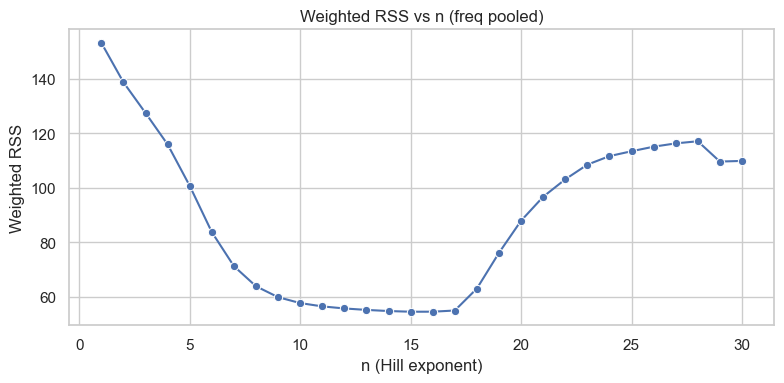

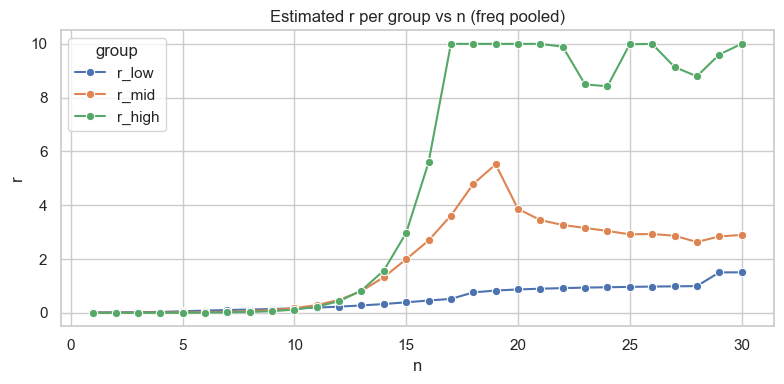

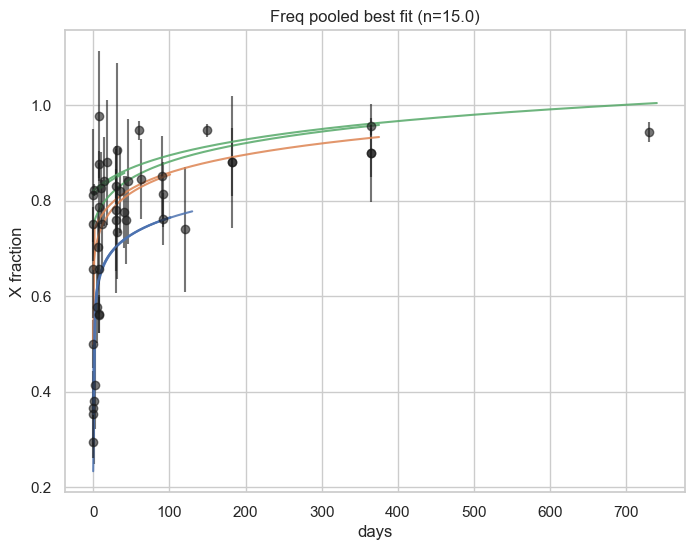

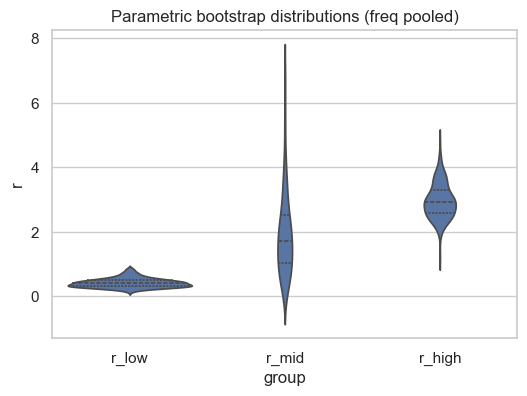

In [156]:
sns.set_theme(style='whitegrid')

freq_result = load_freq_results(outdir='r_freq_out', r_studies=r_studies)

plot_freq_grid_and_rvsn(freq_result)
plot_freq_bestfit_overlay(freq_result)
plot_freq_bootstrap(freq_result)

In [ ]:
# freq_result.keys()
freq_result['best_n'], freq_result['best_r'], freq_result['profile']

(15.0,
 array([0.39082065, 1.99190384, 2.97319129]),
 {'0': [0.21966815580692667, 0.6199224028907133],
  '1': [0.43959257223962067, 5.879550653704926],
  '2': [2.186867930565418, 4.2250762965048745]})

In [146]:
bayes_result = r_estimation_bayesian(r_studies, r_max=10.0, n_val=15.0, nwalkers=64, nsteps=2000, burn=500,
                                    #  thin=5, out_prefix='bayes_example'
                                     )
bayes_result

Starting emcee: nwalkers=64, ndim=24, steps=2000


100%|██████████| 2000/2000 [12:20<00:00,  2.70it/s]

Sampling done in 741.0 s


{'posterior_samples': {'mu_r': array([[0.51821539, 1.36842499, 1.56555463],
         [0.55828573, 0.47604365, 1.59701236],
         [0.46591315, 1.76649921, 1.87474203],
         ...,
         [0.32657721, 1.46958803, 2.05651897],
         [0.36406846, 0.97337566, 2.81134441],
         [0.22199236, 1.32949871, 2.26473825]]),
  'tau_r': array([[0.03415103, 0.09416625, 0.0512154 ],
         [0.05409706, 0.28468392, 0.37104365],
         [0.03054352, 0.08877843, 0.05936975],
         ...,
         [0.14486487, 0.07549878, 0.08859081],
         [0.06683033, 0.04152558, 0.19785479],
         [0.10548087, 0.04040059, 0.13823396]]),
  'r_i': array([[0.55171973, 0.57111701, 0.55580016, ..., 0.54099265, 1.60494692,
          1.55491577],
         [0.49220204, 0.54348562, 0.57968228, ..., 0.69188634, 1.26146772,
          1.92022688],
         [0.44375923, 0.47877543, 0.48129668, ..., 0.44829435, 1.94435892,
          1.93955574],
         ...,
         [0.6239686 , 0.52003503, 0.30141744, ..., 

In [148]:
save_bayes_results(outdir='r_bayes_out', bayes_result=bayes_result)

Saved Bayesian results to r_bayes_out


npz keys: ['mu_r', 'tau_r', 'r_i', 'X0']


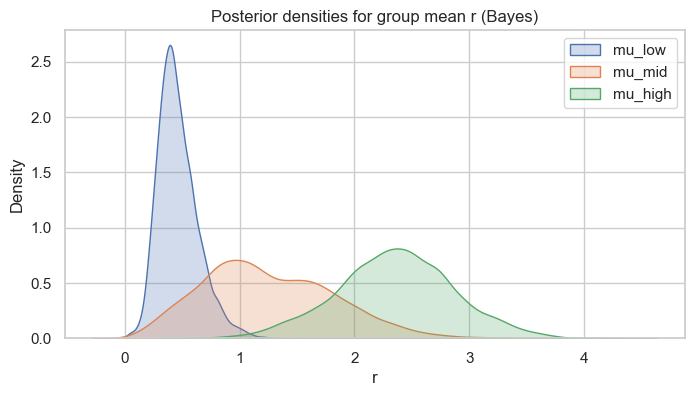

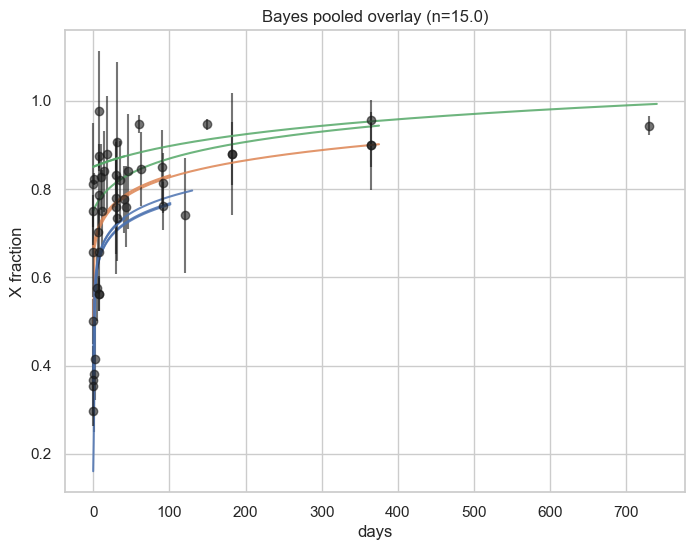

In [169]:
bayes_result = load_bayes_results(outdir='r_bayes_out', r_studies=r_studies)
# bayes_result#.keys()#['n_val'], bayes_result['best_r'], bayes_result['profile']

plot_bayes_mu_posterior(bayes_result)
plot_bayes_overlay(bayes_result)

#### Bayesian pipeline numeric results

In [170]:
### ===== retrieve per group r+-CI values from the Bayesian pipeline =====

def hpd_interval(samples, alpha=0.05):
    x = np.sort(np.asarray(samples))
    n = x.size
    if n == 0:
        return (np.nan, np.nan)
    interval_idx_inc = int(np.floor((1.0 - alpha) * n))
    if interval_idx_inc < 1:
        return (float(x[0]), float(x[-1]))
    n_intervals = n - interval_idx_inc
    widths = x[interval_idx_inc:] - x[:n_intervals]
    min_idx = np.argmin(widths)
    return (float(x[min_idx]), float(x[min_idx + interval_idx_inc]))

def summarize_and_plot_bayes_r(bayes_result,
                              lower_thresh=0.4,    # default: <40% -> low
                              upper_thresh=0.6,    # default: >60% -> high
                              ci=0.95,
                              figsize=(12, 8),
                              savefig=None):
    """
    Function to extract:
      - r_mean  = group-mean for 'mid' group (point + CI)
      - r_upper = upper-bound (use high group's upper CI endpoint)
      - r_lower = lower-bound (use low group's lower CI endpoint)
    plus plots (KDE of mu_r, predictive violins if tau present, and a summary point plot).
    
    Inputs:
      - bayes_result: dict with keys 'posterior_samples' and 'datasets' (as in notebook).
        posterior_samples must include 'mu_r' (nsamps x 3). If available, 'tau_r' and 'r_i' are used.
      - lower_thresh, upper_thresh: thresholds for mapping datasets by first-observation mean.
        If values > 1 are provided (e.g. 30, 60), they will be treated as percentages and divided by 100.
      - ci: credible interval mass (default 0.95).
      - figsize: matplotlib figure size.
      - savefig: path prefix to save figures (optional).
    
    Returns:
      summary_dict with r_mean, r_upper, r_lower each containing {'point','median','ci','hpd'}.
    """
    # ---- validate + extract samples ----
    ps = bayes_result['posterior_samples']
    if 'mu_r' not in ps:
        raise ValueError("bayes_result must contain posterior_samples['mu_r'] (nsamps x 3).")
    mu = np.asarray(ps['mu_r'])         # nsamps x 3 (low, mid, high)
    nsamps = mu.shape[0]
    # optional
    tau = np.asarray(ps.get('tau_r')) if 'tau_r' in ps else None
    r_i = np.asarray(ps.get('r_i')) if 'r_i' in ps else None

    # ---- thresholds handling (allow percent inputs) ----
    if lower_thresh > 1.0:
        lower_thresh = lower_thresh / 100.0
    if upper_thresh > 1.0:
        upper_thresh = upper_thresh / 100.0
    if not (0.0 <= lower_thresh < upper_thresh <= 1.0):
        raise ValueError("Thresholds must satisfy 0 <= lower_thresh < upper_thresh <= 1 (or be percentages).")

    # ---- dataset mapping by first-observation mean ----
    datasets = bayes_result.get('datasets', None)
    if datasets is None:
        raise ValueError("bayes_result must include 'datasets' (list of dicts with 'X' arrays).")
    group_map = []
    for d in datasets:
        X = np.asarray(d['X'])
        if X.size == 0:
            group_map.append('mid')
        else:
            x0 = float(X[0])
            if x0 < lower_thresh:
                group_map.append('low')
            elif x0 > upper_thresh:
                group_map.append('high')
            else:
                group_map.append('mid')

    # ---- compute summaries for mu (group means) ----
    alpha = 1.0 - ci
    groups = ['low', 'mid', 'high']
    mu_quantiles = {}
    mu_hpd = {}
    mu_mean = {}
    mu_median = {}
    for i,g in enumerate(groups):
        arr = mu[:, i]
        qlow = float(np.quantile(arr, alpha/2))
        qhigh = float(np.quantile(arr, 1 - alpha/2))
        mu_quantiles[g] = (qlow, qhigh)
        mu_hpd[g] = hpd_interval(arr, alpha=alpha)
        mu_mean[g] = float(arr.mean())
        mu_median[g] = float(np.median(arr))

    # define outputs requested:
    # r_mean -> mid group mean + CI
    r_mean = {
        'point': mu_mean['mid'],
        'median': mu_median['mid'],
        'ci': list(mu_quantiles['mid']),
        'hpd': list(mu_hpd['mid'])
    }
    # r_upper -> use the HIGH group's upper credible endpoint (equal-tail)
    r_upper = {
        'point': mu_mean['high'],
        'median': mu_median['high'],
        'ci': list(mu_quantiles['high']),
        'hpd': list(mu_hpd['high']),
        # explicit single-number upper bound:
        'upper_bound': mu_quantiles['high'][1]
    }
    # r_lower -> use the LOW group's lower credible endpoint
    r_lower = {
        'point': mu_mean['low'],
        'median': mu_median['low'],
        'ci': list(mu_quantiles['low']),
        'hpd': list(mu_hpd['low']),
        'lower_bound': mu_quantiles['low'][0]
    }

    # ---- prepare plots ----
    sns.set_theme(style='whitegrid')
    fig = plt.figure(constrained_layout=True, figsize=figsize)
    gs = fig.add_gridspec(2, 2)

    # (A) KDE of mu_r per group (top-left)
    ax0 = fig.add_subplot(gs[0, 0])
    labels = {'low':'low (<{:.0%})'.format(lower_thresh), 'mid':'mid', 'high':'high (>{:.0%})'.format(upper_thresh)}
    for i,g in enumerate(groups):
        arr = mu[:, i]
        sns.kdeplot(arr, fill=True, ax=ax0, label=f"{g}", alpha=0.5)
        ax0.axvline(mu_mean[g], color=f"C{i}", linestyle='-', linewidth=1)
        ax0.axvline(mu_quantiles[g][0], color=f"C{i}", linestyle='--', linewidth=1)
        ax0.axvline(mu_quantiles[g][1], color=f"C{i}", linestyle='--', linewidth=1)
    ax0.set_title("Posterior KDE: group mean r (mu_r)")
    ax0.set_xlabel("r")
    ax0.legend(title='group')

    # (B) predictive violin per group if tau present (top-right)
    ax1 = fig.add_subplot(gs[0, 1])
    if tau is not None:
        # draw predictive r_new per posterior sample: r_new = mu + tau * eps
        # use vectorized draws
        eps = np.random.normal(size=(nsamps, 3))
        r_new = mu + tau * eps
        rnew_df = (pd.DataFrame(r_new, columns=['low','mid','high'])
                       .melt(var_name='group', value_name='r'))
        sns.violinplot(data=rnew_df, x='group', y='r', inner='quartile', ax=ax1)
        ax1.set_title('Posterior predictive r for new dataset (mu + tau*ε)')
    else:
        ax1.text(0.5, 0.5, 'tau not available\n(posterior predictive skipped)', ha='center', va='center')
        ax1.set_axis_off()

    # (C) summary point plot (bottom row, spanning both columns)
    ax2 = fig.add_subplot(gs[1, :])
    # prepare three points: lower group's lower bound, mid mean, high upper bound
    pts = []
    names = []
    lower_err = []
    upper_err = []
    # r_lower uses low group's lower quantile as 'bound' (and full ci)
    pts.append(r_lower['point']); names.append('r_lower (low group)'); lower_err.append(r_lower['point'] - r_lower['ci'][0]); upper_err.append(r_lower['ci'][1] - r_lower['point'])
    # r_mean uses mid group's mean and ci
    pts.append(r_mean['point']); names.append('r_mean (mid group)'); lower_err.append(r_mean['point'] - r_mean['ci'][0]); upper_err.append(r_mean['ci'][1] - r_mean['point'])
    # r_upper uses high group's upper bound (we'll mark upper endpoint)
    pts.append(r_upper['point']); names.append('r_upper (high group)'); lower_err.append(r_upper['point'] - r_upper['ci'][0]); upper_err.append(r_upper['ci'][1] - r_upper['point'])
    x = np.arange(len(pts))
    ax2.errorbar(x, pts, yerr=[lower_err, upper_err], fmt='o', capsize=5)
    for xi,txt in enumerate(names):
        ax2.text(xi, pts[xi], f" {pts[xi]:.3f}", va='bottom', fontsize=9)
    ax2.set_xticks(x)
    ax2.set_xticklabels(names, rotation=10)
    ax2.set_title('Summary: r_lower (low), r_mean (mid), r_upper (high) with 95% CI')

    plt.tight_layout()
    if savefig:
        plt.savefig(savefig, dpi=300)
    plt.show()

    # ---- assemble machine-readable summary ----
    summary = {
        'r_mean': r_mean,
        'r_upper': r_upper,
        'r_lower': r_lower,
        'mu_mean': mu_mean,
        'mu_median': mu_median,
        'mu_quantiles': mu_quantiles,
        'mu_hpd': mu_hpd,
        'group_map_by_first_obs': group_map
    }
    return summary


C:\Users\skol\AppData\Local\Temp\ipykernel_11184\1560778116.py:173: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


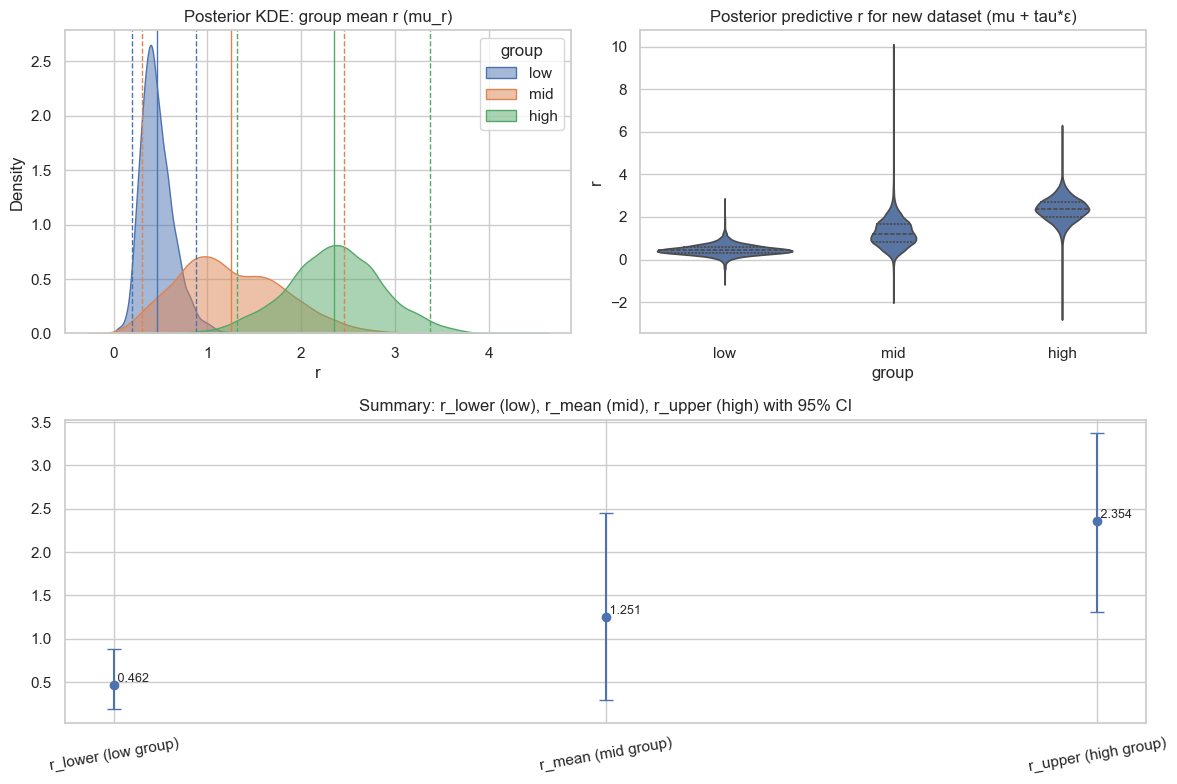

In [172]:
bayes_res = summarize_and_plot_bayes_r(bayes_result,
                                lower_thresh=30,
                                upper_thresh=70,
                                ci=0.95,
                                savefig='bayes_r_summary.png')

with open('bayes_r_summary.json','w') as f:
    json.dump(bayes_res, f, indent=2)


In [175]:
bayes_res['r_lower']['median'], bayes_res['r_mean']['median'], bayes_res['r_upper']['median']

(0.4328268936563241, 1.181773439454955, 2.360685452492361)

In [ ]:
bayes_res['r_lower']['ci'], bayes_res['r_mean']['ci'], bayes_res['r_upper']['ci']

([0.19122832264742187, 0.8788403766078287],
 [0.29721806419002866, 2.4519606526537023],
 [1.313868292922501, 3.3705012583057896])

## $r$ estimated

In [183]:
freq_result['profile']

{'0': [0.21966815580692667, 0.6199224028907133],
 '1': [0.43959257223962067, 5.879550653704926],
 '2': [2.186867930565418, 4.2250762965048745]}

In [ ]:
r_est = pd.DataFrame(
    index=['r_LB_freq', 'r_mean_freq', 'r_UB_freq', 'r_LB_bayes', 'r_mean_bayes', 'r_UB_bayes'],
    columns=['r_median', 'r_CI_low', 'r_CI_high'],
    data=[
        (freq_result['best_r'][0], freq_result['profile']['0'][0], freq_result['profile']['0'][1]),
        (freq_result['best_r'][1], freq_result['profile']['1'][0], freq_result['profile']['1'][1]),
        (freq_result['best_r'][2], freq_result['profile']['2'][0], freq_result['profile']['2'][1]),
        (bayes_res['r_lower']['median'], bayes_res['r_lower']['ci'][0], bayes_res['r_lower']['ci'][1]),
        (bayes_res['r_mean']['median'], bayes_res['r_mean']['ci'][0], bayes_res['r_mean']['ci'][1]),
        (bayes_res['r_upper']['median'], bayes_res['r_upper']['ci'][0], bayes_res['r_upper']['ci'][1]),
    ]
) * DAYS_PER_YEAR
r_est

,r_median,r_CI_low,r_CI_high
r_LB_freq,142.744310,80.232146,226.422008
r_mean_freq,727.527939,160.557890,2147.461780
r_UB_freq,1085.935821,798.737110,1543.177429
r_LB_bayes,158.086777,69.844711,320.989856
r_mean_bayes,431.633885,108.556669,895.560239
r_UB_bayes,862.222656,479.880540,1231.050306


## chk4

In [10]:
# %%
"""
Pooled Logistic-model analysis notebook (complete, reproducible)

Model: dX/dt = r * (1 - X/K) * X with m = 1 and K = 1.
Closed-form solution (logistic) used with a per-dataset time-shift t_shift:
    X(t) = 1 / (1 + exp(-r * (t - t_shift)))

This notebook implements two pipelines:
  1) Frequentist pooled fit: 3 group-level r's (low/mid/high) + per-dataset t_shift, grid/scan over nothing
     (theta/m not used because m=1 fixed). Weighted least squares, profile CIs, parametric bootstrap.
  2) Bayesian hierarchical fit (pure-Python emcee): hierarchical mu_r/tau_r, per-dataset r_i and t_shift_i.

Features:
 - Save/load helpers for r_studies (JSON)
 - SABLE 2-day binning and sigma estimation included
 - All functions accept r_studies as argument for reproducibility
 - Seaborn-based plotting utilities

Dependencies:
  pip install numpy scipy pandas matplotlib seaborn emcee tqdm

"""

# %%
# Imports
import os
import json
import math
import time
from pathlib import Path
from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from scipy.optimize import least_squares
from scipy.stats import chi2
from tqdm.auto import tqdm

import emcee

# %%
# -------------------------------
# IO helpers for r_studies
# -------------------------------

def _numpy_to_py(o):
    if isinstance(o, np.ndarray):
        return o.tolist()
    if isinstance(o, dict):
        return {k: _numpy_to_py(v) for k, v in o.items()}
    if isinstance(o, (list, tuple)):
        return [_numpy_to_py(v) for v in o]
    return o


def _py_to_numpy(o):
    if isinstance(o, dict):
        return {k: _py_to_numpy(v) for k, v in o.items()}
    if isinstance(o, list):
        try:
            return np.array([_py_to_numpy(v) for v in o])
        except Exception:
            return [_py_to_numpy(v) for v in o]
    return o


def save_r_studies_json(path: str, r_studies: dict):
    p = Path(path)
    p.parent.mkdir(parents=True, exist_ok=True)
    with open(p, 'w') as f:
        json.dump(_numpy_to_py(r_studies), f, indent=2)
    print(f'Saved r_studies to {p}')


def load_r_studies_json(path: str) -> dict:
    with open(path, 'r') as f:
        raw = json.load(f)
    return _py_to_numpy(raw)

# %%
# -------------------------------
# 1) Embedded data (r_studies)
# -------------------------------
# (You can replace by loading from JSON with load_r_studies_json)

r_studies = {
    'SABLE_2018': {
        'times_days': np.array([  1,   3,   5,   6,   7,   2,   5,   7,  10,  11,  12,  14,   5,
                                  10,  12,  15,  18,  20,  21,  22,  40,  40,  41,  42,  43,  46,
                                  75, 120 ]),
        'X_frac': np.array([0.38,0.47,0.65,0.51,0.90,0.36,0.63,0.70,0.89,0.92,0.82,0.94,0.45,0.67,0.68,
                             0.74,0.88,1.20,0.90,1.28,0.70,0.82,0.81,0.80,0.72,0.84,1.11,0.74]),
        'notes': 'Approximate digitization from Figure 1. Times in days; X as fraction of TLV; no CIs.'
    },

    'KIM_2024_GROUP_A': {
        'times_days': np.array([0, 7.0, 91.3125]),
        'X_frac': np.array([0.296, 0.561, 0.813]),
        'X_frac_ci': np.array([0.018, 0.075, 0.134]),
    },

    'KIM_2024_GROUP_B': {
        'times_days': np.array([0, 7.0, 91.3125]),
        'X_frac': np.array([0.367, 0.563, 0.762]),
        'X_frac_ci': np.array([0.048, 0.078, 0.107]),
    },

    'WANG_2024_REMNANT_RIGHT': {
        'times_days': np.array([0.0, 30.4375, 182.625, 365.25]),
        'X_frac': np.array([0.75, 0.78, 0.88, 0.9]),
        'X_frac_ci': np.array([0.07, 0.25, 0.14, 0.1]),
    },

    'WANG_2024_REMNANT_LEFT': {
        'times_days': np.array([0.0, 30.4375, 182.625, 365.25]),
        'X_frac': np.array([0.5, 0.76, 0.88, 0.9]),
        'X_frac_ci': np.array([0.1, 0.3, 0.27, 0.2]),
    },

    'GONG_2019': {
        'times_days': np.array([0., 7., 35., 63., 91.]),
        'X_frac': np.array([0.65671642, 0.78606965, 0.82089552, 0.84577114, 0.85074627]),
        'X_frac_ci': np.array([0.19900498, 0.17910448, 0.17412935, 0.1641791 , 0.1641791 ]),
    },

    'IBIS_2017_RHH': {
        'times_days': np.array([0.0, 7.0, 31.0]),
        'X_frac': np.array([0.35354273, 0.65741417, 0.73338203]),
        'X_frac_ci': np.array([0.17823229, 0.18626735, 0.19101534]),
    },

    'IBIS_2017_LLS': {
        'times_days': np.array([0.0, 7.0, 31.0]),
        'X_frac': np.array([0.81196013, 0.97674419, 0.90564784]),
        'X_frac_ci': np.array([0.27109635, 0.2654485 , 0.35614618]),
    },

    'YAMAMOTO_2016': {
        'times_days': np.array([1, 7, 30, 60, 150, 365, 730]),
        'X_frac': np.array([0.82188466, 0.87539964, 0.83130982, 0.9466702 , 0.94646015, 0.95550741, 0.94372618]),
        'X_frac_ci': np.array([0.02606226, 0.05370439, 0.06625629, 0.03977659, 0.02516157, 0.0352281 , 0.04189607]),
    }
}

# %%
# -------------------------------
# 2) Model: logistic closed-form with t_shift
# -------------------------------

def logistic_pred(times: np.ndarray, r: float, t_shift: float) -> np.ndarray:
    """Closed-form logistic: X(t) = 1 / (1 + exp(-r*(t - t_shift)))"""
    t = np.asarray(times, dtype=float)
    return 1.0 / (1.0 + np.exp(-r * (t - t_shift)))

# For completeness, an integrator (not used) is provided
def simulate_logistic(times: np.ndarray, r: float, t_shift: float):
    return logistic_pred(times, r, t_shift)

# -------------------------------
# 3) SABLE binning (same as before)
# -------------------------------

def sable_binning_and_sigma(times_days: np.ndarray,
                            X_frac: np.ndarray,
                            bin_width: float = 2.0,
                            early_phase_end: float = 20.0) -> pd.DataFrame:
    times_days = np.asarray(times_days, dtype=float)
    X_frac = np.asarray(X_frac, dtype=float)
    max_t = float(times_days.max())
    bin_edges = np.arange(0.0, max_t + bin_width + 1e-9, bin_width)
    bin_idx = np.digitize(times_days, bin_edges) - 1
    early_mask = times_days <= early_phase_end
    if early_mask.sum() < 3:
        sd_resid = np.std(X_frac[early_mask], ddof=1) if early_mask.sum() > 1 else 0.05
        df_pool = max(1, early_mask.sum() - 1)
    else:
        try:
            from scipy.optimize import curve_fit
            t_early = times_days[early_mask]
            x_early = X_frac[early_mask]
            popt, _ = curve_fit(lambda t, r, t_shift: 1.0 / (1.0 + np.exp(-r * (t - t_shift))),
                                t_early, x_early, p0=[0.2, 7.0], bounds=([1e-6, -100], [2.0, 100]), maxfev=10000)
            resid_early = x_early - (1.0 / (1.0 + np.exp(-popt[0] * (t_early - popt[1]))))
            sd_resid = float(np.std(resid_early, ddof=1))
            df_pool = len(resid_early) - 1
        except Exception:
            sd_resid = float(np.std(X_frac[early_mask], ddof=1)) if X_frac[early_mask].size > 1 else 0.05
            df_pool = max(1, X_frac[early_mask].size - 1)
    try:
        from scipy.stats import t as tdist
        tcrit = float(tdist.ppf(0.975, df=max(1, df_pool)))
    except Exception:
        tcrit = 2.0
    bin_centers = []
    mean_times = []
    mean_X = []
    counts = []
    ci95_list = []
    for b in range(len(bin_edges) - 1):
        mask = bin_idx == b
        if mask.sum() == 0:
            continue
        bin_centers.append((bin_edges[b] + bin_edges[b + 1]) / 2.0)
        mean_times.append(times_days[mask].mean())
        mean_X.append(X_frac[mask].mean())
        n_points = int(mask.sum())
        counts.append(n_points)
        ci95 = tcrit * sd_resid / math.sqrt(n_points)
        ci95_list.append(float(ci95))
    df = pd.DataFrame({'bin_center': bin_centers, 'time': mean_times, 'X': mean_X, 'n': counts, 'ci95': ci95_list})
    df['sigma'] = df['ci95'] / 1.96
    return df

# data prep

def prepare_datasets(r_studies: dict):
    studies = deepcopy(r_studies)
    sable = studies.get('SABLE_2018')
    if sable is not None:
        sable_df = sable_binning_and_sigma(sable['times_days'], sable['X_frac'], bin_width=2.0, early_phase_end=20.0)
        studies['SABLE_2018']['binned_time'] = sable_df['time'].to_numpy()
        studies['SABLE_2018']['binned_X'] = sable_df['X'].to_numpy()
        studies['SABLE_2018']['binned_sigma'] = sable_df['sigma'].to_numpy()
    dataset_list = []
    for name, data in studies.items():
        if name == 'SABLE_2018':
            times = np.asarray(data['binned_time'], dtype=float)
            X = np.asarray(data['binned_X'], dtype=float)
            sigma = np.asarray(data['binned_sigma'], dtype=float)
        else:
            times = np.asarray(data['times_days'], dtype=float)
            X = np.asarray(data['X_frac'], dtype=float)
            if 'X_frac_ci' in data:
                sigma = np.asarray(data['X_frac_ci'], dtype=float) / 1.96
            else:
                sigma = np.full_like(X, 0.05, dtype=float)
        order = np.argsort(times)
        times = times[order]; X = X[order]; sigma = sigma[order]
        mask_le1 = X <= 1.0
        times = times[mask_le1]; X = X[mask_le1]; sigma = sigma[mask_le1]
        dataset_list.append({'name': name, 'times': times, 'X': X, 'sigma': sigma})
    return dataset_list

# mapping by first-observation mean
def map_to_group_by_mean(dataset: dict):
    X = dataset['X']
    if X.size == 0:
        return 'mid'
    x0 = float(X[0])
    if x0 < 0.4:
        return 'low'
    if x0 > 0.6:
        return 'high'
    return 'mid'

# %%
# -------------------------------
# 4) Save results helpers
# -------------------------------

def save_freq_results(outdir: str, result: dict):
    p = Path(outdir)
    p.mkdir(parents=True, exist_ok=True)
    grid_df = pd.DataFrame([{'theta': g.get('theta', np.nan), 'n': g.get('n', np.nan), 'rss': g['rss'], 'r_low': g['r'][0], 'r_mid': g['r'][1], 'r_high': g['r'][2]} for g in result.get('grid', [])]) if 'grid' in result else pd.DataFrame()
    if not grid_df.empty:
        grid_df.to_csv(p / 'freq_grid.csv', index=False)
    result['bootstrap_df'].to_csv(p / 'freq_bootstrap.csv', index=False)
    summary = {'best_r': list(map(float, result['best_r'])), 'profile': result['profile'], 'best_parameter': result.get('best_theta', result.get('best_n', None))}
    with open(p / 'freq_summary.json', 'w') as f:
        json.dump(_numpy_to_py(summary), f, indent=2)
    print('Saved frequentist results to', p)


def save_bayes_results(outdir: str, bayes_result: dict):
    p = Path(outdir)
    p.mkdir(parents=True, exist_ok=True)
    with open(p / 'bayes_summary.json', 'w') as f:
        json.dump(_numpy_to_py(bayes_result['summary']), f, indent=2)
    np.savez_compressed(p / 'bayes_posterior.npz', **{k: np.asarray(v) for k,v in bayes_result['posterior_samples'].items()})
    print('Saved Bayesian results to', p)

# %%
# -------------------------------
# 5) Frequentist pooled logistic pipeline
# -------------------------------

def run_frequentist_logistic(r_studies: dict,
                             r_bounds=(1e-8, 5.0),
                             bootstrap_n=50,
                             profile_grid_pts=30,
                             out_prefix='freq_logistic') -> dict:
    """Pooled frequentist logistic fit.
    Model: X(t) = 1 / (1 + exp(-r_group * (t - t_shift_i)))
    Parameters fitted: r_low,r_mid,r_high (group-level) and t_shift_i per dataset.
    """
    datasets = prepare_datasets(r_studies)
    names = [d['name'] for d in datasets]
    groups = [map_to_group_by_mean(d) for d in datasets]
    group_names = ['low','mid','high']
    group_idx = np.array([group_names.index(g) for g in groups], dtype=int)

    times_list = [d['times'] for d in datasets]
    X_list = [d['X'] for d in datasets]
    sigma_list = [d['sigma'] for d in datasets]
    obs_times = np.concatenate(times_list) if len(times_list)>0 else np.array([])
    obs_X = np.concatenate(X_list) if len(X_list)>0 else np.array([])
    obs_sigma = np.concatenate(sigma_list) if len(sigma_list)>0 else np.array([])

    M = len(datasets)

    # initial t_shift guesses: dataset median times (or 0)
    init_tshift = np.array([float(np.median(d['times'])) if d['times'].size>0 else 0.0 for d in datasets])

    def resid_stack(params):
        rvals = params[:3]
        tshifts = params[3:3+M]
        preds = []
        for i,d in enumerate(datasets):
            preds.append(logistic_pred(d['times'], rvals[group_idx[i]], tshifts[i]))
        pred_all = np.concatenate(preds)
        return (obs_X - pred_all) / obs_sigma

    def fit_all(x0=None, max_nfev=5000):
        if x0 is None:
            p0 = np.concatenate(([0.2,0.2,0.2], init_tshift))
        else:
            p0 = x0
        lb = np.concatenate(([r_bounds[0]]*3, np.full(M, -1e3)))
        ub = np.concatenate(([r_bounds[1]]*3, np.full(M, 1e4)))
        sol = least_squares(lambda p: resid_stack(p), x0=p0, bounds=(lb,ub), max_nfev=max_nfev)
        rss = float(np.sum(sol.fun**2))
        r_est = sol.x[:3].copy(); tshifts_est = sol.x[3:3+M].copy()
        try:
            J = sol.jac; Nobs = len(obs_X); nparams = len(sol.x); dof = max(1, Nobs - nparams)
            JTJ = J.T.dot(J)
            cov = np.linalg.inv(JTJ) * (rss/dof)
            se = np.sqrt(np.maximum(np.diag(cov)[:3], 1e-12))
        except Exception:
            cov=None; se=np.array([np.nan]*3)
        return {'success': sol.success, 'r': r_est, 'tshift': tshifts_est, 'rss': rss, 'se': se, 'sol': sol}

    # fit
    all_res = fit_all()
    best_fit = all_res
    best_r = best_fit['r']

    # profile-likelihood for each group r
    cutoff = chi2.ppf(0.95, df=1)
    profile = {}
    for idx in range(3):
        r_hat = float(best_r[idx])
        if r_hat <= 0 or np.isnan(r_hat):
            grid_vals = np.linspace(1e-6, 1.0, profile_grid_pts)
        else:
            low = max(1e-6, r_hat * 0.05)
            high = min(r_bounds[1], max(r_hat * 5.0, r_hat + 1.0))
            grid_vals = np.linspace(low, high, profile_grid_pts)
        rss_vals = []
        for rfix in grid_vals:
            def resid_fix(p):
                # p contains other two r's followed by all tshifts
                rvals = []
                it = 0
                for j in range(3):
                    if j == idx:
                        rvals.append(float(rfix))
                    else:
                        rvals.append(p[it]); it += 1
                tshifts = p[it:it+M]
                preds = []
                for i,d in enumerate(datasets):
                    preds.append(logistic_pred(d['times'], rvals[group_idx[i]], tshifts[i]))
                return (obs_X - np.concatenate(preds)) / obs_sigma
            # initial p0: other r estimates + best tshifts
            p0 = []
            for j in range(3):
                if j != idx:
                    p0.append(best_r[j])
            p0 = np.concatenate((np.array(p0), best_fit['tshift']))
            lb_other = [r_bounds[0] for _ in range(2)]; ub_other = [r_bounds[1] for _ in range(2)]
            lb = np.concatenate((np.array(lb_other), np.full(M, -1e3)))
            ub = np.concatenate((np.array(ub_other), np.full(M, 1e4)))
            sol = least_squares(resid_fix, x0=p0, bounds=(lb,ub), max_nfev=3000)
            rss_vals.append(float(np.sum(sol.fun**2)))
        rss_vals = np.array(rss_vals)
        delta = rss_vals - best_fit['rss']
        mask = delta <= cutoff
        if mask.any():
            idxs = np.where(mask)[0]
            profile[idx] = (float(grid_vals[idxs[0]]), float(grid_vals[idxs[-1]]))
        else:
            profile[idx] = (np.nan, np.nan)

    # parametric bootstrap
    preds_all = []
    for i,d in enumerate(datasets):
        preds_all.append(logistic_pred(d['times'], best_fit['r'][group_idx[i]], best_fit['tshift'][i]))
    pred_all = np.concatenate(preds_all)
    obs_sigma_all = np.concatenate([d['sigma'] for d in datasets])
    rng = np.random.default_rng(123456)
    boot_r = []
    for b in tqdm(range(bootstrap_n), desc='freq: bootstrap'):
        sim_y = pred_all + rng.normal(scale=obs_sigma_all)
        def resid_sim(p):
            rvals = p[:3]; tshifts = p[3:3+M]
            preds = []
            for i,d in enumerate(datasets):
                preds.append(logistic_pred(d['times'], rvals[group_idx[i]], tshifts[i]))
            return (sim_y - np.concatenate(preds)) / obs_sigma_all
        p0 = np.concatenate(([0.2,0.2,0.2], best_fit['tshift']))
        lb = np.concatenate(([r_bounds[0]]*3, np.full(M, -1e3)))
        ub = np.concatenate(([r_bounds[1]]*3, np.full(M, 1e4)))
        sol = least_squares(resid_sim, x0=p0, bounds=(lb,ub), max_nfev=3000)
        boot_r.append(sol.x[:3])
    boot_r = np.array(boot_r)
    boot_df = pd.DataFrame(boot_r, columns=['r_low','r_mid','r_high'])

    result = {
        'best_r': best_fit['r'],
        'best_tshift': best_fit['tshift'],
        'rss': best_fit['rss'],
        'profile': profile,
        'bootstrap_df': boot_df,
        'datasets': datasets,
        'group_map': groups
    }

    save_freq_results(out_prefix, {'grid': [], 'best_r': result['best_r'], 'profile': profile, 'bootstrap_df': boot_df})
    return result

# %%
# -------------------------------
# 6) Bayesian hierarchical logistic (emcee)
# -------------------------------

def run_bayesian_emcee_logistic(r_studies: dict,
                                r_max: float = 5.0,
                                nwalkers: int = 64,
                                nsteps: int = 2000,
                                burn: int = 500,
                                thin: int = 10,
                                out_prefix: str = 'bayes_logistic') -> dict:
    """Hierarchical Bayesian fit using emcee. theta/m fixed at 1 (logistic), K=1.

    Parameters include group-level mu_r/tau_r and per-dataset r_i and t_shift_i.
    """
    datasets = prepare_datasets(r_studies)
    groups = [map_to_group_by_mean(d) for d in datasets]
    group_names = ['low','mid','high']
    grp_idx = np.array([group_names.index(g) for g in groups], dtype=int)
    M = len(datasets)
    init_tshift = np.array([float(np.median(d['times'])) if d['times'].size>0 else 0.0 for d in datasets])

    # params layout: [mu0,mu1,mu2, logtau0,logtau1,logtau2, r_raw_0..r_raw_{M-1}, tshift_0..tshift_{M-1}]
    ndim = 6 + M + M

    def unpack(theta_vec):
        mu = theta_vec[0:3]
        logtau = theta_vec[3:6]
        idx = 6
        r_raw = theta_vec[idx:idx+M]; idx += M
        tshifts = theta_vec[idx:idx+M]
        tau = np.exp(logtau)
        return mu, tau, r_raw, tshifts

    def log_prior(theta_vec):
        mu, tau, r_raw, tshifts = unpack(theta_vec)
        # positivity for mu,tau
        if np.any(mu <= 0) or np.any(tau <= 0):
            return -np.inf
        # X0/tshift can be any real
        lp = 0.0
        # mu ~ Normal(0.2,1)
        lp += -0.5 * np.sum(((mu - 0.2) / 1.0) ** 2)
        # logtau ~ Normal(log(0.1),1)
        lp += -0.5 * np.sum(((np.log(tau) - np.log(0.1)) / 1.0) ** 2)
        # r_raw ~ Normal(0,1)
        lp += -0.5 * np.sum(r_raw ** 2)
        # tshifts prior: Normal(median_time, 50 days)
        med_times = np.array([np.median(d['times']) if d['times'].size>0 else 0.0 for d in datasets])
        lp += -0.5 * np.sum(((tshifts - med_times) / 50.0) ** 2)
        # implied r_i bounds
        for m in range(M):
            r_i = mu[grp_idx[m]] + tau[grp_idx[m]] * r_raw[m]
            if not (0.0 <= r_i <= r_max):
                return -np.inf
        return lp

    def log_likelihood(theta_vec):
        mu, tau, r_raw, tshifts = unpack(theta_vec)
        total = 0.0
        for m in range(M):
            times = datasets[m]['times']
            if len(times) == 0:
                continue
            r_i = mu[grp_idx[m]] + tau[grp_idx[m]] * r_raw[m]
            pred = logistic_pred(times, r_i, tshifts[m])
            y = datasets[m]['X']
            s = datasets[m]['sigma']
            total += -0.5 * np.sum(((y - pred) / s) ** 2 + np.log(2*np.pi * (s ** 2)))
        return total

    def log_posterior(theta_vec):
        lp = log_prior(theta_vec)
        if not np.isfinite(lp):
            return -np.inf
        ll = log_likelihood(theta_vec)
        return lp + ll

    # initialize walkers
    p0 = np.zeros(ndim)
    p0[0:3] = 0.2
    p0[3:6] = math.log(0.1)
    p0[6:6+M] = 0.0  # r_raw
    p0[6+M:6+2*M] = init_tshift
    pos0 = p0 + 1e-4 * np.random.randn(nwalkers, ndim)

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
    print('Starting emcee (logistic): nwalkers=%d, ndim=%d, steps=%d' % (nwalkers, ndim, nsteps))
    t0 = time.time()
    sampler.run_mcmc(pos0, nsteps, progress=True)
    t1 = time.time()
    print('Sampling done in %.1f s' % (t1 - t0))

    samples = sampler.get_chain(discard=burn, thin=thin, flat=True)
    mu_samples = samples[:, 0:3]
    tau_samples = np.exp(samples[:, 3:6])
    r_raw_samples = samples[:, 6:6+M]
    tshifts_samples = samples[:, 6+M:6+2*M]

    # compute r_i samples
    r_i_samples = np.empty_like(r_raw_samples)
    for i in range(M):
        grp = grp_idx[i]
        r_i_samples[:, i] = mu_samples[:, grp] + tau_samples[:, grp] * r_raw_samples[:, i]

    posterior_samples = {
        'mu_r': mu_samples,
        'tau_r': tau_samples,
        'r_i': r_i_samples,
        'tshift': tshifts_samples
    }

    summary = {
        'mu_mean': list(np.mean(mu_samples, axis=0)),
        'mu_ci': np.percentile(mu_samples, [2.5,50,97.5], axis=0).tolist(),
        'n_samples': mu_samples.shape[0]
    }

    result = {
        'posterior_samples': posterior_samples,
        'summary': summary,
        'datasets': datasets,
        'group_map': groups,
        'sampler': sampler
    }

    save_bayes_results(out_prefix, result)
    return result

# %%
# -------------------------------
# 7) Plotting utilities (seaborn)
# -------------------------------

def plot_freq_results(freq_res):
    # grid not used in logistic; show bootstrap and best-fit overlay
    boot_df = freq_res['bootstrap_df']
    datasets = freq_res['datasets']; groups = freq_res['group_map']
    print('Best r (low,mid,high):', freq_res['best_r'])
    plt.figure(figsize=(6,4))
    sns.violinplot(data=boot_df.melt(var_name='group', value_name='r'), x='group', y='r', inner='quartile')
    plt.title('Freq parametric bootstrap: r distributions'); plt.show()

    # overlay
    plt.figure(figsize=(8,6))
    pal = {'low':'C0','mid':'C1','high':'C2'}
    for i,d in enumerate(datasets):
        t = d['times']; y = d['X']; s = d['sigma']
        plt.errorbar(t, y, yerr=s, fmt='o', color='k', alpha=0.6)
        rds = freq_res['best_r'][['low','mid','high'].index(groups[i])] if isinstance(freq_res['best_r'], (list, np.ndarray)) else freq_res['best_r'][i]
        tsh = freq_res['best_tshift'][i]
        tplot = np.linspace(max(0, t.min()-2), t.max()+10, 200)
        ypred = logistic_pred(tplot, rds, tsh)
        plt.plot(tplot, ypred, '-', color=pal[groups[i]], alpha=0.85)
    plt.xlabel('days'); plt.ylabel('X fraction'); plt.title('Frequentist pooled logistic fits'); plt.show()


def plot_bayes_results(bayes_res):
    mu_samples = bayes_res['posterior_samples']['mu_r']
    mu_df = pd.DataFrame(mu_samples, columns=['mu_low','mu_mid','mu_high'])
    plt.figure(figsize=(8,4))
    for col in mu_df.columns:
        sns.kdeplot(mu_df[col], fill=True, label=col)
    plt.title('Posterior densities for group mean r (Bayes)'); plt.legend(); plt.show()

    # overlay using posterior mean r_i and tshifts
    r_i_mean = bayes_res['posterior_samples']['r_i'].mean(axis=0)
    tsh_mean = bayes_res['posterior_samples']['tshift'].mean(axis=0)
    datasets = bayes_res['datasets']; groups = bayes_res['group_map']
    plt.figure(figsize=(8,6))
    pal = {'low':'C0','mid':'C1','high':'C2'}
    for i,d in enumerate(datasets):
        t = d['times']; y = d['X']; s = d['sigma']
        plt.errorbar(t, y, yerr=s, fmt='o', color='k', alpha=0.6)
        rds = r_i_mean[i]
        tsh = tsh_mean[i]
        tplot = np.linspace(max(0, t.min()-2), t.max()+10, 200)
        ypred = logistic_pred(tplot, rds, tsh)
        plt.plot(tplot, ypred, '-', color=pal[groups[i]], alpha=0.85)
    plt.xlabel('days'); plt.ylabel('X fraction'); plt.title('Bayesian pooled logistic posterior-mean overlay'); plt.show()
    

C:\Users\skol\AppData\Local\Temp\ipykernel_13708\1489415094.py:158: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-r * (t - t_shift)))


freq: bootstrap:   0%|          | 0/200 [00:00<?, ?it/s]

Saved frequentist results to freq_logistic
Best r (low,mid,high): [0.14101998 0.01025979 0.00800876]


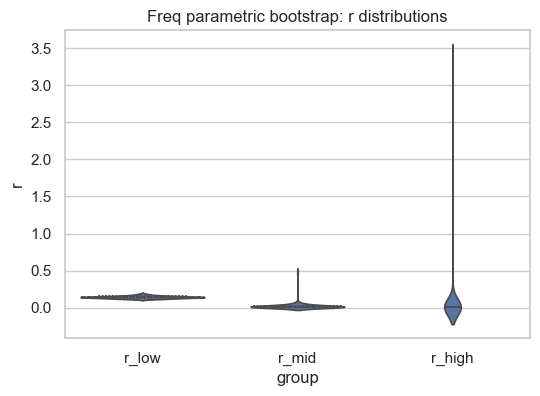

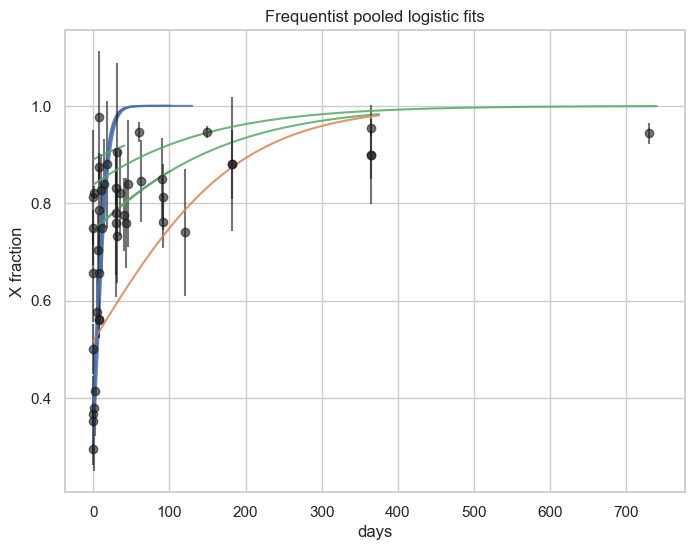

In [12]:
freq_res = run_frequentist_logistic(r_studies, bootstrap_n=200)
plot_freq_results(freq_res)

Starting emcee (logistic): nwalkers=48, ndim=24, steps=1200


100%|██████████| 1200/1200 [01:01<00:00, 19.46it/s]


Sampling done in 61.8 s
Saved Bayesian results to bayes_logistic


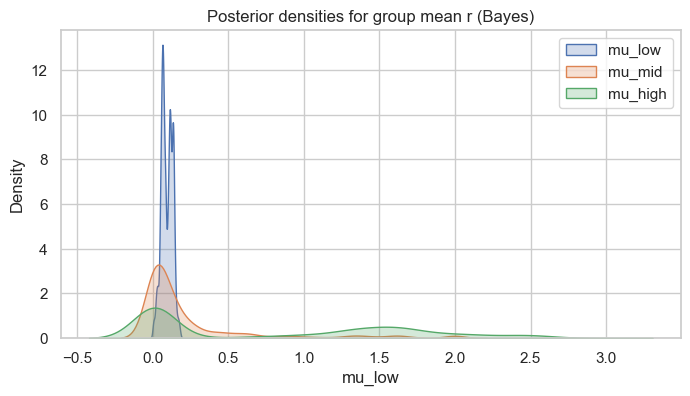

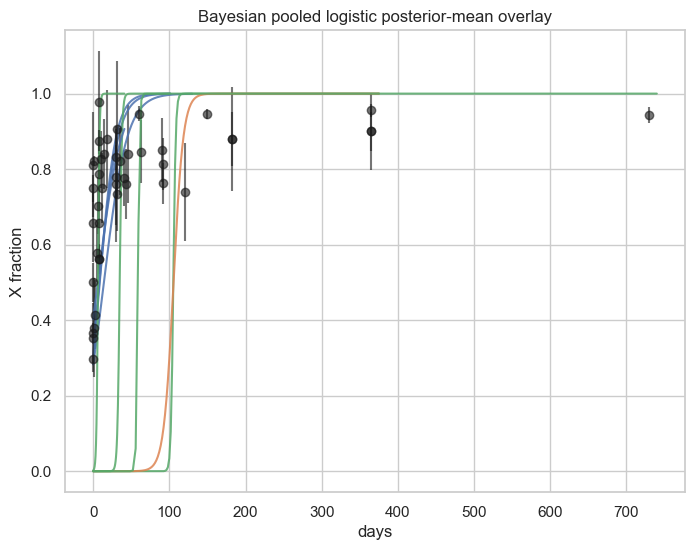

In [13]:
bayes_res = run_bayesian_emcee_logistic(r_studies, nwalkers=48, nsteps=1200, burn=300, thin=5)
plot_bayes_results(bayes_res)

In [14]:
save_r_studies_json('r_studies_logistic.json', r_studies)

Saved r_studies to r_studies_logistic.json


## chk5

In [70]:
# Revised Jupyter-ready pipeline (Frequentist + Bayesian using emcee) 
# - Uses scipy for optimization and chi2; emcee for Bayesian sampling (group-level joint posterior where r is shared).
# - Produces 6 plots arranged in 3 rows x 2 cols (left: Frequentist group fits; right: Bayesian group fits).
# - Lightweight default sampler settings (knobs at top). Increase for better accuracy.
#
# Notes/knobs you can change at the top:
#  - RES_R: resolution for r-grid used by frequentist profile/CI (vectorized).
#  - BAYES_NWALKERS, BAYES_NSTEPS, BAYES_BURN: emcee sampler settings (small defaults for speed).
#  - R_BOUNDS: prior/bounds on r (1/day).
#  - X0_BOUNDS: bounds for dataset-specific x0.
#
# Outputs:
#  - results_df: pandas DataFrame with group estimates (Frequentist & Bayesian) in 1/day and 1/year.
#  - 6-panel figure (3x2) with data+CI, dataset fits, and combined curve for each approach.
#
# Please ensure emcee and scipy are installed in your environment (pip install emcee scipy).

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.optimize import minimize
# from scipy.stats import chi2
import emcee, math, time
from typing import Dict, Tuple, List

# ----------------------
# User data (same as before)
# ----------------------
r_studies = {
    'SABLE_2018': {
        'times_days': np.array([  1,   3,   5,   6,   7,   2,   5,   7,  10,  11,  12,  14,   5,
                                  10,  12,  15,  18,  20,  21,  22,  40,  40,  41,  42,  43,  46,
                                  75, 120 ]),
        'X_frac': np.array([0.34,0.47,0.65,0.51,0.90,0.36,0.63,0.70,0.89,0.92,0.82,0.94,0.45,0.67,0.68,
                             0.74,0.88,1.20,0.90,1.28,0.70,0.82,0.81,0.80,0.72,0.84,1.11,0.74]),
        'notes': 'Approximate digitization from Figure 1. Times in days; X as fraction of TLV; no CIs.'
    },

    'KIM_2024_GROUP_A': {
        'times_days': np.array([0, 7.0, 91.3125]),
        'X_frac': np.array([0.296, 0.561, 0.813]),
        'X_frac_ci': np.array([0.018, 0.075, 0.134]),
    },

    'KIM_2024_GROUP_B': {
        'times_days': np.array([0, 7.0, 91.3125]),
        'X_frac': np.array([0.367, 0.563, 0.762]),
        'X_frac_ci': np.array([0.048, 0.078, 0.107]),
    },

    'WANG_2024_REMNANT_RIGHT': {
        'times_days': np.array([0.0, 30.4375, 182.625, 365.25]),
        'X_frac': np.array([0.75, 0.78, 0.88, 0.9]),
        'X_frac_ci': np.array([0.07, 0.25, 0.14, 0.1]),
    },

    'WANG_2024_REMNANT_LEFT': {
        'times_days': np.array([0.0, 30.4375, 182.625, 365.25]),
        'X_frac': np.array([0.5, 0.76, 0.88, 0.9]),
        'X_frac_ci': np.array([0.1, 0.3, 0.27, 0.2]),
    },

    'GONG_2019': {
        'times_days': np.array([0., 7., 35., 63., 91.]),
        'X_frac': np.array([0.65671642, 0.78606965, 0.82089552, 0.84577114, 0.85074627]),
        'X_frac_ci': np.array([0.19900498, 0.17910448, 0.17412935, 0.1641791 , 0.1641791 ]),
    },

    'IBIS_2017_RHH': {
        'times_days': np.array([0.0, 7.0, 31.0]),
        'X_frac': np.array([0.35354273, 0.65741417, 0.73338203]),
        'X_frac_ci': np.array([0.17823229, 0.18626735, 0.19101534]),
    },

    'IBIS_2017_LLS': {
        'times_days': np.array([0.0, 7.0, 31.0]),
        'X_frac': np.array([0.81196013, 0.97674419, 0.90564784]),
        'X_frac_ci': np.array([0.27109635, 0.2654485 , 0.35614618]),
    },

    'YAMAMOTO_2016': {
        'times_days': np.array([1, 7, 30, 60, 150, 365, 730]),
        'X_frac': np.array([0.82188466, 0.87539964, 0.83130982, 0.9466702 , 0.94646015, 0.95550741, 0.94372618]),
        'X_frac_ci': np.array([0.02606226, 0.05370439, 0.06625629, 0.03977659, 0.02516157, 0.0352281 , 0.04189607]),
    }
}

# ----------------------
# Knobs
# ----------------------
K = 1.0
R_BOUNDS = (1e-4, 0.7) # 1/day
X0_BOUNDS = (0.05, 0.99)
RES_R = 1000 # grid resolution for the frequentist approach
RES_X0 = 500
SIGMA_FLOOR = 1e-3
# DAYS_PER_YEAR = 365.25

# emcee knobs
BAYES_NWALKERS = 32
BAYES_NSTEPS = 1000
BAYES_BURN = 250

# ----------------------
# Helpers
# ----------------------

def logistic_solution(t, r, x0, K=1.0):
    A = (K - x0) / np.maximum(x0, 1e-12)
    return K / (1.0 + A * np.exp(-r * t))

def prepare_dataset(d):
    t = np.asarray(d['times_days'], dtype=float)
    x = np.asarray(d['X_frac'], dtype=float)
    x = np.minimum(x, K)  # truncate above K
    order = np.argsort(t)
    t = t[order]; x = x[order]
    if 'X_frac_ci' in d and d.get('X_frac_ci') is not None:
        ci = np.asarray(d['X_frac_ci'], dtype=float)[order]
        sigma = np.maximum(ci / 1.96, SIGMA_FLOOR)
    else:
        sigma = None
    return dict(t=t, x=x, sigma=sigma)

prepared = {name: prepare_dataset(d) for name,d in r_studies.items()}

# Grouping based on earliest observed X0
group_LB, group_MEAN, group_UB = [], [], []
for name, ds in prepared.items():
    x0_obs = float(ds['x'][0])
    if 0.7 <= x0_obs <= 1.0:
        group_LB.append(name)
    elif 0.0 <= x0_obs <= 0.35:
        group_UB.append(name)
    else:
        group_MEAN.append(name)
groups = {'LB': group_LB, 'MEAN': group_MEAN, 'UB': group_UB}

# ----------------------
# Frequentist: per-dataset and group profile likelihood (vectorized)
# ----------------------

r_grid = np.linspace(R_BOUNDS[0], R_BOUNDS[1], RES_R)
x0_grid = np.linspace(X0_BOUNDS[0], X0_BOUNDS[1], RES_X0)
CHI2_95_1DF = st.chi2.ppf(0.95, df=1.0)

def profile_loglike_over_r(t, x, sigma, r_grid, x0_grid, K=1.0):
    # returns profile log-likelihood over r (maximized over x0)
    if sigma is None:
        sigma = np.ones_like(x)
    # compute predictions for all combos r,x0,t
    # shapes: (R, X0, T)
    R = r_grid.size; X0N = x0_grid.size; T = t.size
    rt = r_grid[:, None, None] * t[None, None, :]
    x0m = x0_grid[None, :, None]
    A = (K - x0m) / np.maximum(x0m, 1e-12)
    pred = K / (1.0 + A * np.exp(-rt))
    resid = (x[None, None, :] - pred) / sigma[None, None, :]
    ll = -0.5 * np.sum(resid**2, axis=2)  # shape (R, X0)
    argmax_x0_idx = np.argmax(ll, axis=1)
    ll_profile = ll[np.arange(R), argmax_x0_idx]
    x0_at_max = x0_grid[argmax_x0_idx]
    return ll_profile, x0_at_max

def profile_ci_r(r_grid, ll_profile, alpha=0.05):
    llmax = np.max(ll_profile)
    threshold = llmax - 0.5 * st.chi2.ppf(1-alpha, df=1)
    mask = ll_profile >= threshold
    if not np.any(mask):
        return r_grid[0], r_grid[-1]
    idx = np.where(mask)[0]
    return float(r_grid[idx[0]]), float(r_grid[idx[-1]])

# compute per-dataset frequentist fits
per_dataset_freq = {}
for name, ds in prepared.items():
    sigma_eff = None if (name == 'SABLE_2018') else ds['sigma']
    ll_profile, x0_at_max = profile_loglike_over_r(ds['t'], ds['x'], sigma_eff, r_grid, x0_grid, K)
    idx = int(np.argmax(ll_profile))
    r_hat = float(r_grid[idx])
    x0_hat = float(x0_at_max[idx])
    r_lo, r_hi = profile_ci_r(r_grid, ll_profile)
    per_dataset_freq[name] = dict(r_hat=r_hat, r_lo=r_lo, r_hi=r_hi, x0_hat=x0_hat, ll_profile=ll_profile)

# Group frequentist: sum profile log-likelihoods across datasets (independent)
group_freq = {}
for gname, dnames in groups.items():
    if len(dnames) == 0:
        continue
    ll_sum = np.zeros_like(r_grid)
    for dn in dnames:
        sigma_eff = None if (dn == 'SABLE_2018') else prepared[dn]['sigma']
        ll_profile, _ = profile_loglike_over_r(prepared[dn]['t'], prepared[dn]['x'], sigma_eff, r_grid, x0_grid, K)
        ll_sum += ll_profile
    idx = int(np.argmax(ll_sum))
    r_hat = float(r_grid[idx])
    r_lo, r_hi = profile_ci_r(r_grid, ll_sum)
    # representative x0: weighted median of per-dataset x0_hat weighted by peak likelihood at r_hat
    x0s = np.array([per_dataset_freq[dn]['x0_hat'] for dn in dnames])
    weights = np.array([np.exp(np.max(profile_loglike_over_r(prepared[dn]['t'], prepared[dn]['x'], None if (dn=='SABLE_2018') else prepared[dn]['sigma'], np.array([r_hat]), x0_grid, K)[0])) for dn in dnames])
    # weighted median
    order = np.argsort(x0s); x0s_s = x0s[order]; w_s = weights[order]
    csum = np.cumsum(w_s)/np.sum(w_s)
    idx_m = np.searchsorted(csum, 0.5)
    x0_rep = float(x0s_s[min(idx_m, x0s_s.size-1)])
    group_freq[gname] = dict(r_hat=r_hat, r_lo=r_lo, r_hi=r_hi, x0_rep=x0_rep, ll_sum=ll_sum)

# ----------------------
# Bayesian: per-dataset posterior (emcee) and group-level joint posterior (shared r, dataset-specific x0s)
# ----------------------

# def log_prior(theta, n_datasets):
#     """Uniform priors: r in [1e-4,5], each x0 in [0.05,0.99]."""
#     r = theta[0]
#     x0s = theta[1:]
#     if not (1e-4 <= r <= 5.0):
#         return -np.inf
#     if np.any((x0s < 0.05) | (x0s > 0.99)):
#         return -np.inf
#     return 0.0

# def log_likelihood(theta, datasets):
#     """Gaussian likelihood given measurement errors (sigma)."""
#     r = theta[0]
#     x0s = theta[1:]
#     ll = 0.0
#     for (ds, x0) in zip(datasets, x0s):
#         pred = logistic_solution(ds['t'], r, x0, K)
#         resid = (ds['x'] - pred) / ds['sigma']
#         ll += -0.5 * np.sum(resid**2 + np.log(2*np.pi*ds['sigma']**2))
#     return ll

# def log_posterior(theta, datasets):
#     """Posterior = prior + likelihood."""
#     lp = log_prior(theta, len(datasets))
#     if not np.isfinite(lp):
#         return -np.inf
#     return lp + log_likelihood(theta, datasets)

# def fit_group_bayes_emcee(dnames, prepared, nwalkers=20, nsteps=500, burn=100):
#     """
#     Fit Bayesian group model:
#       - shared r across datasets
#       - dataset-specific x0
#       - tiny sampler settings for speed
#     """
#     datasets = [prepared[dn] for dn in dnames if dn != 'SABLE_2018']
#     ndim = 1 + len(dnames)  # r + one x0 per dataset

#     # start near frequentist estimates
#     init_r = np.mean([per_dataset_freq[dn]['r_hat'] for dn in dnames])
#     init_x0s = [per_dataset_freq[dn]['x0_hat'] for dn in dnames]

#     p0 = []
#     for _ in range(nwalkers):
#         r0 = init_r * (1 + 0.01*np.random.randn())
#         x0s0 = [x * (1 + 0.01*np.random.randn()) for x in init_x0s]
#         p0.append(np.concatenate([[r0], x0s0]))

#     sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[datasets])
#     sampler.run_mcmc(p0, nsteps, progress=False)

#     flat_samples = sampler.get_chain(discard=burn, flat=True)
#     r_samples = flat_samples[:,0]
#     x0_samples = flat_samples[:,1:]

#     return {
#         "r_mean": np.mean(r_samples),
#         "r_ci": np.percentile(r_samples, [2.5,97.5]),
#         "x0_meds": np.median(x0_samples, axis=0),
#         "sampler": sampler
#     }

# # ----------------------
# # Run group-level Bayesian fits: joint posterior with shared r and dataset-specific x0_i
# # ----------------------
# group_bayes = {}
# for g, dnames in groups.items():
#     if len(dnames) == 0: 
#         continue
#     group_bayes[g] = fit_group_bayes_emcee(dnames, prepared,
#                                            nwalkers=20, nsteps=500, burn=100)

def log_prior_r_x0(r, x0):
    if not (R_BOUNDS[0] <= r <= R_BOUNDS[1] and X0_BOUNDS[0] <= x0 <= X0_BOUNDS[1]):
        return -np.inf
    return 0.0

def log_likelihood_dataset(params, t, x, sigma):
    # params = [r, x0]
    r, x0 = params
    pred = logistic_solution(t, r, x0, K)
    if sigma is None:
        # unweighted: assume small sigma floor
        sigma = np.ones_like(x) * 0.05
    resid = (x - pred) / sigma
    return -0.5 * np.sum(resid**2)

def run_emcee_dataset(name, ds, nwalkers=BAYES_NWALKERS, nsteps=BAYES_NSTEPS, burn=BAYES_BURN):
    t, x, sigma = ds['t'], ds['x'], ds['sigma']
    # log-posterior over (r,x0)
    def log_prob(theta):
        r, x0 = theta
        lp = log_prior_r_x0(r, x0)
        if not np.isfinite(lp): return -np.inf
        return lp + log_likelihood_dataset((r,x0), t, x, sigma)
    ndim = 2
    # initialize walkers in small ball around frequentist estimates if available
    r0 = per_dataset_freq[name]['r_hat'] if name in per_dataset_freq else 0.01
    x00 = per_dataset_freq[name]['x0_hat'] if name in per_dataset_freq else float(ds['x'][0])
    p0 = np.vstack([
        np.random.normal(r0, 0.1*r0+1e-4, size=nwalkers),
        np.random.normal(x00, 0.05, size=nwalkers)
    ]).T
    # ensure within bounds
    for i in range(nwalkers):
        if not (R_BOUNDS[0] <= p0[i,0] <= R_BOUNDS[1]):
            p0[i,0] = np.clip(p0[i,0], R_BOUNDS[0], R_BOUNDS[1])
        p0[i,1] = np.clip(p0[i,1], X0_BOUNDS[0], X0_BOUNDS[1])
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)
    sampler.run_mcmc(p0, nsteps, progress=False)
    samples = sampler.get_chain(discard=burn, flat=True)
    logprob = sampler.get_log_prob(discard=burn, flat=True)
    return samples, logprob, sampler

# Run per-dataset emcee
per_dataset_bayes = {}
for name, ds in prepared.items():
    if name == 'SABLE_2018':
        # SABLE no CI -> treat as unweighted but still sample
        pass
    samples, logprob, sampler = run_emcee_dataset(name, ds)
    r_samples = samples[:,0]
    x0_samples = samples[:,1]
    # compute mean and 95% credible interval (equal-tailed)
    r_mean = float(np.mean(r_samples))
    r_lo = float(np.quantile(r_samples, 0.025))
    r_hi = float(np.quantile(r_samples, 0.975))
    per_dataset_bayes[name] = dict(r_samples=r_samples, x0_samples=x0_samples, r_mean=r_mean, r_lo=r_lo, r_hi=r_hi, sampler=sampler)

# Group-level Bayesian: joint posterior with shared r and dataset-specific x0_i
group_bayes = {}
for gname, dnames in groups.items():
    if len(dnames) == 0:
        continue
    # dimension: 1 (shared r) + n_datasets (x0 for each dataset)
    nd = len(dnames); ndim = 1 + nd
    # log prior
    def log_prior_group(theta):
        r = theta[0]
        if not (R_BOUNDS[0] <= r <= R_BOUNDS[1]):
            return -np.inf
        x0s = theta[1:]
        if np.any(x0s < X0_BOUNDS[0]) or np.any(x0s > X0_BOUNDS[1]):
            return -np.inf
        return 0.0
    # log likelihood: sum over datasets
    def log_likelihood_group(theta):
        r = theta[0]; x0s = theta[1:]
        ll = 0.0
        for i, dn in enumerate(dnames):
            ds = prepared[dn]
            pred = logistic_solution(ds['t'], r, x0s[i], K)
            sigma = ds['sigma'] if ds['sigma'] is not None else np.ones_like(ds['x'])*0.05
            resid = (ds['x'] - pred)/sigma
            ll += -0.5 * np.sum(resid**2)
        return ll
    def log_prob_group(theta):
        lp = log_prior_group(theta)
        if not np.isfinite(lp): return -np.inf
        return lp + log_likelihood_group(theta)
    # init walkers around frequentist group result and per-dataset x0_hat
    r0 = group_freq[gname]['r_hat'] if gname in group_freq else 0.01
    x0_inits = np.array([per_dataset_freq[dn]['x0_hat'] for dn in dnames])
    p0 = np.zeros((BAYES_NWALKERS, ndim))
    for i in range(BAYES_NWALKERS):
        p0[i,0] = np.clip(np.random.normal(r0, 0.2*max(r0,1e-4)), R_BOUNDS[0], R_BOUNDS[1])
        p0[i,1:] = np.clip(np.random.normal(x0_inits, 0.05), X0_BOUNDS[0], X0_BOUNDS[1])
    sampler = emcee.EnsembleSampler(BAYES_NWALKERS, ndim, log_prob_group)
    sampler.run_mcmc(p0, BAYES_NSTEPS, progress=False)
    samples = sampler.get_chain(discard=BAYES_BURN, flat=True)
    r_samples = samples[:,0]
    r_mean = float(np.mean(r_samples))
    r_lo = float(np.quantile(r_samples, 0.025))
    r_hi = float(np.quantile(r_samples, 0.975))
    # representative x0: mean across posterior
    x0_means = np.mean(samples[:,1:], axis=0)
    # for combined Bayesian curve we use r_mean and x0_means averaged (or weighted) -> use simple mean
    x0_rep = float(np.mean(x0_means))
    group_bayes[gname] = dict(r_mean=r_mean, r_lo=r_lo, r_hi=r_hi, r_samples=r_samples, x0_means=x0_means, x0_rep=x0_rep, sampler=sampler)

# ----------------------
# Build results DataFrame
# ----------------------
rows = []
for g in ['LB','MEAN','UB']:
    if g in group_freq:
        rf = group_freq[g]['r_hat']; rfl = group_freq[g]['r_lo']; rfh = group_freq[g]['r_hi']
        rows.append({'group':g,'method':'Frequentist','r_1_per_day':rf,'r_lo':rfl,'r_hi':rfh,
                     'r_1_per_year':rf*DAYS_PER_YEAR,'r_1_per_year_lo':rfl*DAYS_PER_YEAR,'r_1_per_year_hi':rfh*DAYS_PER_YEAR})
    if g in group_bayes:
        rb = group_bayes[g]['r_mean']; rbl = group_bayes[g]['r_lo']; rbh = group_bayes[g]['r_hi']
        rows.append({'group':g,'method':'Bayesian','r_1_per_day':rb,'r_lo':rbl,'r_hi':rbh,
                     'r_1_per_year':rb*DAYS_PER_YEAR,'r_1_per_year_lo':rbl*DAYS_PER_YEAR,'r_1_per_year_hi':rbh*DAYS_PER_YEAR})
results_df = pd.DataFrame(rows).sort_values(['group','method']).reset_index(drop=True)


In [71]:
results_df

,group,method,r_1_per_day,r_lo,r_hi,r_1_per_year,r_1_per_year_lo,r_1_per_year_hi
0,LB,Bayesian,0.009030,0.004887,0.015051,3.298205,1.784999,5.497255
1,LB,Frequentist,0.007807,0.005004,0.012711,2.851305,1.827748,4.642528
2,MEAN,Bayesian,0.020411,0.012537,0.032208,7.454934,4.579156,11.763563
3,MEAN,Frequentist,0.018316,0.012711,0.027423,6.689641,4.642528,10.016200
4,UB,Bayesian,0.176113,0.149210,0.206212,64.323911,54.497814,75.317251
5,UB,Frequentist,0.158436,0.114298,0.204675,57.867464,41.746450,74.756146


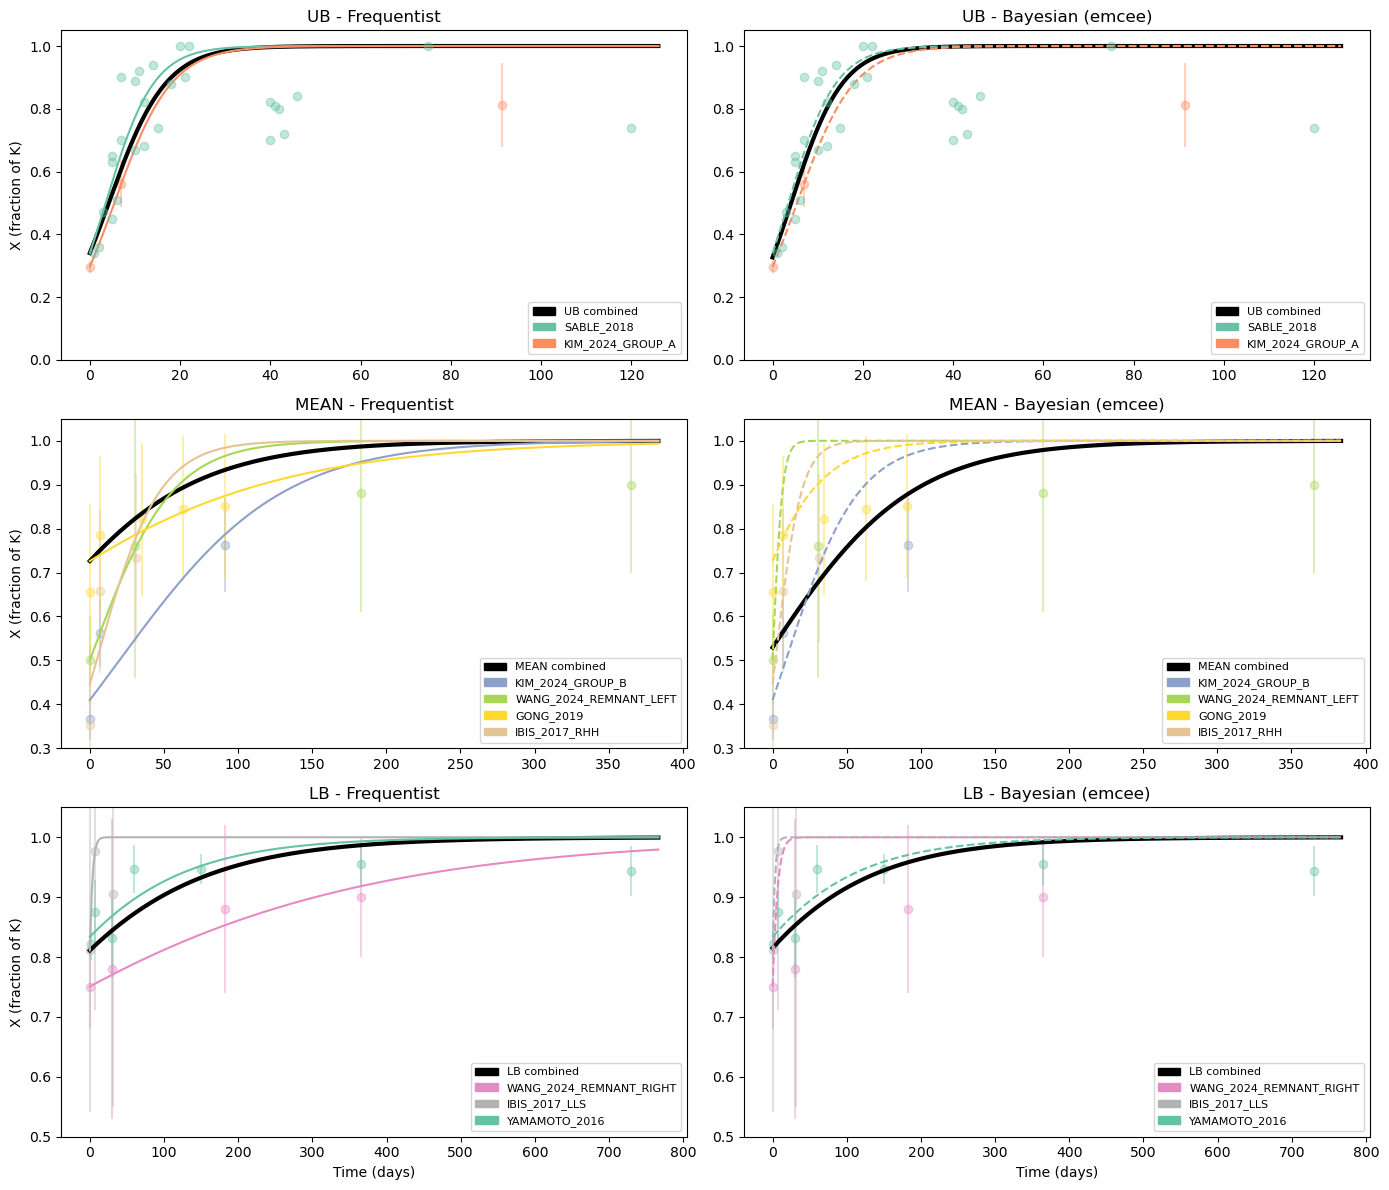

In [72]:
import matplotlib.patches as mpatches
# import seaborn as sns

# ----------------------
# Plotting: 3 rows x 2 cols (left Frequentist, right Bayesian)
# ----------------------
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12), sharex=False, sharey=False)
group_order = ['UB','MEAN','LB']

# consistent color palette for all datasets
all_dnames = list(prepared.keys())
palette = dict(zip(all_dnames, sns.color_palette("Set2", len(all_dnames))))

group_ylims = {'LB':[0.5, 1.05], 'MEAN':[0.3, 1.05], 'UB':[0, 1.05]}

for i, g in enumerate(group_order):
    dnames = groups[g]

    # Frequentist (left)
    ax = axes[i,0]
    if len(dnames)>0 and g in group_freq:
        patches = []
        tt = np.linspace(0, max([prepared[dn]['t'][-1] for dn in dnames])*1.05, 300)

        # combined freq curve
        r_comb = group_freq[g]['r_hat']; x0_comb = group_freq[g]['x0_rep']
        ax.plot(tt, logistic_solution(tt, r_comb, x0_comb, K),
                color="black", linewidth=3, label=f"{g} combined")
        patches.append(mpatches.Patch(color="black", label=f"{g} combined"))

        for dn in dnames:
            ds = prepared[dn]
            col = palette[dn]
            # dataset points (lighter)
            if ds['sigma'] is not None:
                ax.errorbar(ds['t'], ds['x'], yerr=1.96*ds['sigma'], fmt='o',
                            color=col, alpha=0.4, zorder=1)
            else:
                ax.plot(ds['t'], ds['x'], 'o', color=col, alpha=0.4, zorder=3)
            # curve fit
            r_hat = per_dataset_freq[dn]['r_hat']
            x0_hat = per_dataset_freq[dn]['x0_hat']
            ax.plot(tt, logistic_solution(tt, r_hat, x0_hat, K),
                    color=col, linewidth=1.5, zorder=2)
            # legend patch
            patches.append(mpatches.Patch(color=col, label=dn))

        ax.set_title(f"{g} - Frequentist")
        ax.set_ylim(group_ylims[g])
        ax.legend(handles=patches, fontsize=8, loc='lower right')

    else:
        ax.text(0.5,0.5,"No data",ha='center',va='center')
        ax.set_title(f"{g} - Frequentist")

    # Bayesian (right)
    ax = axes[i,1]
    if len(dnames)>0 and g in group_bayes:
        patches = []
        tt = np.linspace(0, max([prepared[dn]['t'][-1] for dn in dnames])*1.05, 300)

        # combined bayes curve
        r_b = group_bayes[g]['r_mean']; x0_b = group_bayes[g]['x0_rep']
        ax.plot(tt, logistic_solution(tt, r_b, x0_b, K),
                color="black", linewidth=3, label=f"{g} combined")
        patches.append(mpatches.Patch(color="black", label=f"{g} combined"))

        for dn in dnames:
            ds = prepared[dn]
            col = palette[dn]
            # dataset points (lighter)
            if ds['sigma'] is not None:
                ax.errorbar(ds['t'], ds['x'], yerr=1.96*ds['sigma'], fmt='o',
                            color=col, alpha=0.4, zorder=1)
            else:
                ax.plot(ds['t'], ds['x'], 'o', color=col, alpha=0.4, zorder=3)
            # bayes mean fit
            if dn in per_dataset_bayes:
                r_m = per_dataset_bayes[dn]['r_mean']
                x0_hat = per_dataset_freq[dn]['x0_hat']
                ax.plot(tt, logistic_solution(tt, r_m, x0_hat, K),
                        color=col, linewidth=1.5, linestyle='--', zorder=2)
            # legend patch
            patches.append(mpatches.Patch(color=col, label=dn))

        ax.set_title(f"{g} - Bayesian (emcee)")
        ax.set_ylim(group_ylims[g])
        ax.legend(handles=patches, fontsize=8, loc='lower right')

    else:
        ax.text(0.5,0.5,"No data",ha='center',va='center')
        ax.set_title(f"{g} - Bayesian")
    
for ax in axes[-1,:]:
    ax.set_xlabel("Time (days)")
axes[0,0].set_ylabel("X (fraction of K)")
axes[1,0].set_ylabel("X (fraction of K)")
axes[2,0].set_ylabel("X (fraction of K)")

plt.tight_layout()
plt.show()


## tests

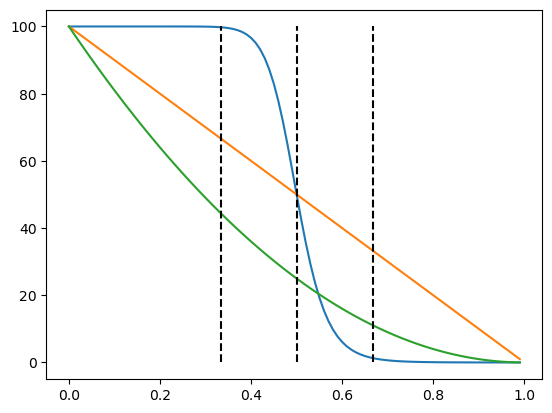

In [8]:
x = np.arange(0,1,0.01)

r = 100
rho_hill = r * (1 / (1 + (x / 0.5)**15))
rho_log = r * (1 - x)
rho_logadj = r * (1 - x)**(1/(1/3)-1)
# y = np.arange()
sns.lineplot(x=x, y=rho_hill)
sns.lineplot(x=x, y=rho_log)
sns.lineplot(x=x, y=rho_logadj)
plt.vlines(x=[1/3, 1/2, 2/3], ymin=0, ymax=r, linestyles='--', colors='k')

In [9]:
(1/(1/3)-1)

2.0

## LSC replication rate $r_s$

In [64]:
r_s_lower = 1e-4

t_doubling = {'AdultLPCs':62, 'FetalLPCs':46, 'BecLPCs':28.5, 'reLPCs':21.6, 'HepLPCs':25.8}
r_s_upper = {}
for i, (k, t) in enumerate(t_doubling.items()):
    r_s_upper[k] = np.log(2) / (t / HOURS_PER_DAY)
r_s_upper

{'AdultLPCs': np.float64(0.2683150376361078),
 'FetalLPCs': np.float64(0.3616420072486671),
 'BecLPCs': np.float64(0.5837028888925855),
 'reLPCs': np.float64(0.7701635339554948),
 'HepLPCs': np.float64(0.644788074939484)}

In [65]:
r_s_mean = st.gmean([1e-4] + [r_s_upper['AdultLPCs'], r_s_upper['reLPCs']])
r_s_mean

np.float64(0.027441593177841117)

In [69]:
r_s_year = np.array([r_s_mean, r_s_lower, r_s_upper['reLPCs']]) * DAYS_PER_YEAR
r_s_year

array([1.00228361e+01, 3.65242500e-02, 2.81296455e+02])

## LSC division types

We model stem cell division probabilities via a softmax over linear utilities.  

This part builds the linear-softmax model for LSC division types, fits
the utilities to three calibration points, and plots the
resulting probability surfaces:

$$f_{ss}(s,x), \quad f_{xx}(s,x), \quad f_{xs}(s,x)$$

Let
$$s = S/Q \text{ and } x = X/K \text{ (both normalized to [0,1])}.$$

Utilities:
\begin{equation*}
U_{ss}(s,x) = a_1 + b_1 s + c_1 x, \quad U_{xx}(s,x) = a_2 + b_2 s + c_2 x, \quad U_{xs}(s,x) = 0 \text{ (baseline)}.
\end{equation*}
Probabilities:
\begin{align*}
 f_{ss}(s,x) &= \frac{e^{U_{ss}(s,x)}}{e^{U_{ss}(s,x)} + e^{U_{xx}(s,x)} + e^{U_{xs}}} = \frac{e^{U_{ss}(s,x)}}{e^{U_{ss}(s,x)} + e^{U_{xx}(s,x)} + 1}, \\
 f_{xx}(s,x) &= \frac{e^{U_{xx}(s,x)}}{e^{U_{ss}(s,x)} + e^{U_{xx}(s,x)} + e^{U_{xs}}} = \frac{e^{U_{xx}(s,x)}}{e^{U_{ss}(s,x)} + e^{U_{xx}(s,x)} + 1}, \\
 f_{xs}(s,x) &= \frac{e^{U_{xs}}}{e^{U_{ss}(s,x)} + e^{U_{xx}(s,x)} + e^{U_{xs}}} = \frac{1}{e^{U_{ss}(s,x)} + e^{U_{xx}(s,x)} + 1}.
\end{align*}
This guarantees $f_{ss}+f_{xx}+f_{xs}=1$.

Calibration points (inferred from Qin et al., 2022):
- Homeostasis (s=1, x=1): (0.1, 0.1, 0.8)
- Severe injury, stem wave (s=1/3, x=1/3): (0.75, 0.1, 0.15)
- Renewal decline, differentiation wave (s=2/3, x=1/3): (0.1, 0.75, 0.15)

  parameter     value
0        a1  3.453878
1        b1 -6.044709
2        c1  0.511390
3        a2  0.431523
4        b2  6.044709
5        c2 -8.555674
s=1.000, x=1.000 → (fss,fxx,fxs)=(0.100,0.100,0.800), target=[0.1 0.1 0.8]
s=0.333, x=0.333 → (fss,fxx,fxs)=(0.750,0.100,0.150), target=[0.75 0.1  0.15]
s=0.667, x=0.333 → (fss,fxx,fxs)=(0.100,0.750,0.150), target=[0.1  0.75 0.15]


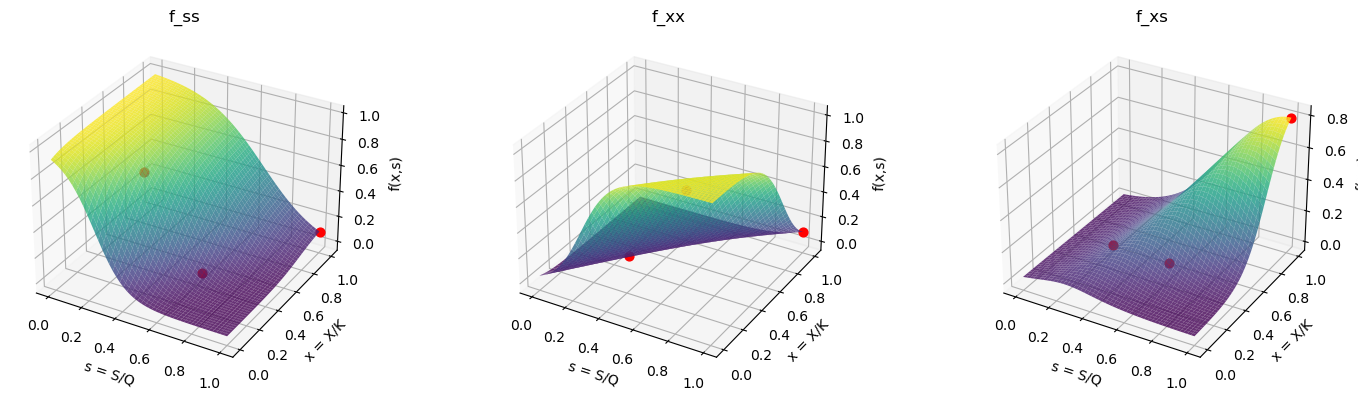

In [ ]:
# Calibration data
states = np.array([
    [1.0, 1.0], # s, x at homeostasis
    [1/3, 1/3], # s, x after injury
    [2/3, 1/3]  # s, x after self-renewal peaked
])
# f_ss, f_xx, f_xs
targets = np.array([
    [0.1, 0.1, 0.8],
    [0.75, 0.1, 0.15],
    [0.1, 0.75, 0.15]
])

# Softmax helper
def softmax_utils(Uss, Uxx):
    exp_ss, exp_xx, exp_xs = np.exp(Uss), np.exp(Uxx), 1.0
    den = exp_ss + exp_xx + exp_xs
    return exp_ss/den, exp_xx/den, exp_xs/den

# Build linear system for log-odds
A_rows, y_vec = [], []
for (s,x), (p_ss, p_xx, p_xs) in zip(states, targets):
    y1 = np.log(p_ss/p_xs)
    y2 = np.log(p_xx/p_xs)
    A_rows.append([1, s, x, 0, 0, 0])
    y_vec.append(y1)
    A_rows.append([0, 0, 0, 1, s, x])
    y_vec.append(y2)

A, y = np.array(A_rows), np.array(y_vec)
params, *_ = np.linalg.lstsq(A, y, rcond=None)
a1,b1,c1,a2,b2,c2 = params

# Save parameters
param_df = pd.DataFrame({
    'parameter': ['a1','b1','c1','a2','b2','c2'],
    'value': params
})
print(param_df)

# Calibration check
for (s,x), targ in zip(states, targets):
    fss, fxx, fxs = softmax_utils(a1+b1*s+c1*x, a2+b2*s+c2*x)
    print(f"s={s:.3f}, x={x:.3f} → (fss,fxx,fxs)=({fss:.3f},{fxx:.3f},{fxs:.3f}), target={targ}")

# Plot surfaces
S, X = np.meshgrid(np.linspace(0,1,50), np.linspace(0,1,50))
Uss = a1 + b1*S + c1*X
Uxx = a2 + b2*S + c2*X
Fss, Fxx, Fxs = softmax_utils(Uss, Uxx)

fig, axes = plt.subplots(1,3,figsize=(15,4),subplot_kw={'projection':'3d'})
for ax, Z, title in zip(axes, [Fss,Fxx,Fxs], ["f_ss","f_xx","f_xs"]):
    ax.plot_surface(S, X, Z, cmap='viridis', alpha=0.8)
    ax.set_xlabel("s = S/Q")
    ax.set_ylabel("x = X/K")
    ax.set_zlabel("f(x,s)")
    ax.set_title(title)
    # Plot calibration points
    for (s,x), (fss,fxx,fxs) in zip(states, targets):
        if title=="f_ss": ax.scatter(s, x, fss, c='r', s=40)
        if title=="f_xx": ax.scatter(s, x, fxx, c='r', s=40)
        if title=="f_xs": ax.scatter(s, x, fxs, c='r', s=40)

fig.tight_layout()
plt.show()

# Lung

## BBC capacity $K$

In [2]:
# Let's assume:
# - The airway surface area (proximal bronchi, both lungs) is around 2000 cm² (published estimates range from 1500–3000 cm²)
# - Basal cells make up roughly 40% of the pseudostratified epithelium in large airways 
# - Epithelial cell density ≈ 10^6 cells/cm² (a reasonable estimate for airway surfaces)

# BBC surface density estimate
total_surface_cm2 = 2000
epithelial_cell_density_per_cm2 = 1e6
basal_fraction = 0.4

# Total BBCs
B_max = total_surface_cm2 * epithelial_cell_density_per_cm2 * basal_fraction

# Confidence range: based on ±25% variation in area and basal fraction
surface_range = [1500, 2500]  # cm²
basal_fraction_range = [0.25, 0.35]

# Bounds
B_min = min(surface_range) * epithelial_cell_density_per_cm2 * min(basal_fraction_range)
B_max_upper = max(surface_range) * epithelial_cell_density_per_cm2 * max(basal_fraction_range)

{
    "B_max_median": B_max,
    "B_max_range": (B_min, B_max_upper),
    "unit": "cells"
}


{'B_max_median': 800000000.0,
 'B_max_range': (375000000.0, 875000000.0),
 'unit': 'cells'}

In [3]:
# Monte-Carlo draws
N = 500_000  # number of MC samples

# --- Input variables ---

# Mercer 1994 morphometry: 
# "Total airway surface area from trachea to bronchioles was 2,471 +/- 320 cm^2" ... "The total number of airway epithelial cells were 10.5 x 10^9 for human"
mercer_area_mean_cm2 = 2471.0
mercer_area_sd_cm2   = 320.0
epi_cells_mean = 10.5e9
# we assume epithelial-cell count uncertainty scales with measured area CV
epi_cells_sd = epi_cells_mean * (mercer_area_sd_cm2 / mercer_area_mean_cm2)

# Basal-cell proportions by airway-size class (from Boers 1998 + review)
# Keys are the diameter bins; values are mean proportion and an estimated SD (uncertainty).
basal_pct = {
    '>=4mm':  (0.31, 0.07),   # "largest (>=4mm) 31% basal" (Boers 1998)
    '2-4mm':  (0.30, 0.07),   # literature-consensus intermediate bin
    '0.5-2mm':(0.10, 0.04),   # small bronchi/large bronchioles range
    '<0.5mm': (0.06, 0.02),   # "smallest (<0.5mm) ~6% basal" (Boers 1998)
}

# Weibel-style geometry parameter:
h = 0.79  # diameter reduction ratio per generation in conducting airways (Weibel/morphometry)

# Length-to-diameter ratio used to convert D -> length per generation (morphometry literature)
LD_mean, LD_sd = 1.46, 0.15  # typical L/D for human conducting airways

# TLV (total lung volume) means & SDs used to scale epithelial counts by sex (PLOS ONE CT-derived TLV)
# We use TLV to scale whole-lung epithelial abundance (assumption: epithelial number scales with lung size)
TLV_ref_mean = 0.5 * (6.2 + 4.7)  # reference mean TLV (average of male & female means) in liters
# Sex-grouped parameters (tracheal length and tracheal volume come from Kamel et al. 2009)
sex_params = {
    'male': {
        'L_mean_mm': 105.1, 'L_sd_mm': 9.8,   # mean tracheal length (mm)
        'V_mean_cm3': 35.6, 'V_sd_cm3': 6.8,  # tracheal luminal volume (cm^3)
        'TLV_mean_L': 6.2, 'TLV_sd_L': 1.2    # mean TLV used for epithelial scaling (L)
    },
    'female': {
        'L_mean_mm': 98.3, 'L_sd_mm': 8.7,
        'V_mean_cm3': 24.7, 'V_sd_cm3': 6.1,
        'TLV_mean_L': 4.7, 'TLV_sd_L': 0.9
    },
    'combined': {  # combined cohort reported in Kamel et al.
        'L_mean_mm': 102.8, 'L_sd_mm': 9.9,
        'V_mean_cm3': 32.0, 'V_sd_cm3': 8.3,
        'TLV_mean_L': TLV_ref_mean, 'TLV_sd_L': 1.05  # synthetic SD for combined TLV
    }
}

# --- Helper function: truncated-normal sampler ---
def trunc_normal_draw(mean, sd, size, lower=None, upper=None):
    """Draw 'size' samples from a truncated normal with given bounds (inclusive).
       If lower is None, set to mean - 4*sd; if upper None, mean + 4*sd.
       Uses scipy.stats.truncnorm parameterization.
    """
    if lower is None:
        lower = mean - 4 * sd
    if upper is None:
        upper = mean + 4 * sd
    a, b = (lower - mean) / sd, (upper - mean) / sd
    return st.truncnorm.rvs(a, b, loc=mean, scale=sd, size=size, random_state=None)

# --- Monte-Carlo draws of uncertain inputs ---
# Draw epithelial cell anchor (combined) from normal (approximate) - ensure positivity via truncation
epi_cells_draw = trunc_normal_draw(epi_cells_mean, epi_cells_sd, N, lower=1e8, upper=1e11)

# Draw basal percentages per class (vector of length N for each class)
basal_draws = {}
for k, (mu, sd) in basal_pct.items():
    basal_draws[k] = np.clip(np.random.normal(mu, sd, N), 0.0, 1.0)  # small Gaussian uncertainty, clipped

# Draw LD_ratio per draw (length-to-diameter)
LD_ratio = np.random.normal(LD_mean, LD_sd, N)

# prepare generation arrays (we model generations 0..24)
gens = np.arange(0, 25)
pow_h = h ** gens            # h^n
branches = 2 ** gens         # 2^n branches per generation (symmetric branching)

# --- Core geometry & area computation per each sex group ---
def compute_for_sex(sex_key):
    """Compute basal cell K distribution for a given sex_key in sex_params.
       Returns arrays of basal cell totals and diagnostics.
    """
    p = sex_params[sex_key]
    # Draw truncated-normal tracheal length (mm) and volume (cm^3) for this sex
    L_mm = trunc_normal_draw(p['L_mean_mm'], p['L_sd_mm'], N, lower=10.0, upper=p['L_mean_mm'] + 4*p['L_sd_mm'])
    V_cm3 = trunc_normal_draw(p['V_mean_cm3'], p['V_sd_cm3'], N, lower=0.1, upper=p['V_mean_cm3'] + 4*p['V_sd_cm3'])
    # Convert length to cm for area calc (L in mm -> cm)
    L_cm = L_mm / 10.0
    # Equivalent circular diameter based on measured lumen volume and length: D = sqrt(4*(V/L)/pi)
    D0_cm = np.sqrt(4.0 * (V_cm3 / L_cm) / np.pi)
    D0_mm = D0_cm * 10.0  # convert back to mm
    # compute generation diameters D_n (N x G)
    D_n = D0_mm[:, None] * pow_h[None, :]        # mm
    D_n_cm = D_n / 10.0                          # cm
    # cylindrical lateral area per branch approximated as: pi * D * length, with length = LD_ratio * D
    area_branch_cm2 = np.pi * LD_ratio[:, None] * (D_n_cm ** 2)  # shape (N, G)
    # total area per generation = area per branch * branch count
    area_gen_total = area_branch_cm2 * branches[None, :]
    # model_total_area is the unscaled sum across generations (varies per draw)
    model_total_area = area_gen_total.sum(axis=1)  # shape (N,)
    # scale factor to enforce Mercer's measured total airway area (preserve relative distribution)
    scale = mercer_area_mean_cm2 / model_total_area
    scaled_area_gen = area_gen_total * scale[:, None]  # scaled so sum per draw == mercer_area_mean_cm2
    # bin generation areas into diameter classes (use D_n in mm)
    mask_ge4   = (D_n >= 4.0)
    mask_2_4   = (D_n >= 2.0) & (D_n < 4.0)
    mask_05_2  = (D_n >= 0.5) & (D_n < 2.0)
    mask_lt05  = (D_n < 0.5)
    area_ge4   = (scaled_area_gen * mask_ge4).sum(axis=1)
    area_2_4   = (scaled_area_gen * mask_2_4).sum(axis=1)
    area_05_2  = (scaled_area_gen * mask_05_2).sum(axis=1)
    area_lt05  = (scaled_area_gen * mask_lt05).sum(axis=1)
    # area fractions per draw (sum to 1 because scaled to Mercer's area)
    area_frac = np.vstack([area_ge4, area_2_4, area_05_2, area_lt05]).T / mercer_area_mean_cm2
    # sample basal fractions per class from draws prepared earlier
    basal_vec = np.vstack([basal_draws['>=4mm'], basal_draws['2-4mm'],
                           basal_draws['0.5-2mm'], basal_draws['<0.5mm']]).T  # shape (N,4)
    # compute area-weighted basal fraction per draw
    f_basal = (area_frac * basal_vec).sum(axis=1)   # shape (N,)
    # sex-scale epithelial cell counts by TLV ratio (assumption: epithelial number scales with TLV)
    TLV_draws = trunc_normal_draw(p['TLV_mean_L'], p['TLV_sd_L'], N,
                                  lower=max(0.5, p['TLV_mean_L'] - 3*p['TLV_sd_L']),
                                  upper=p['TLV_mean_L'] + 4*p['TLV_sd_L'])
    epi_cells_sex = epi_cells_draw * (TLV_draws / TLV_ref_mean)
    # total basal cells per draw
    basal_cells = epi_cells_sex * f_basal
    # diagnostics to inspect model behavior
    diag = {
        'D0_mm_mean': float(D0_mm.mean()),
        'model_area_mean_before_scaling_cm2': float(model_total_area.mean()),
        'scale_mean': float(scale.mean()),
        'f_basal_mean': float(f_basal.mean()),
        'area_frac_means': area_frac.mean(axis=0)
    }
    return basal_cells, diag

# Run for each sex key and collect results
results = {}
diagnostics = {}
for sex in sex_params.keys():
    basal_cells, diag = compute_for_sex(sex)
    results[sex] = basal_cells
    diagnostics[sex] = diag

# --- Summaries ---
def summarize_arr(arr):
    return {'mean': float(arr.mean()), 'median': float(np.median(arr)),
            '2.5%': float(np.percentile(arr, 2.5)), '97.5%': float(np.percentile(arr, 97.5))}

summary_df = pd.DataFrame({sex: summarize_arr(results[sex]) for sex in results}).T
summary_df = summary_df.map(lambda x: f"{x:,.2e}")

summary_df

,mean,median,2.5%,97.5%
male,8.73e+08,8.43e+08,3.75e+08,1.54e+09
female,6.45e+08,6.23e+08,2.70e+08,1.15e+09
combined,7.61e+08,7.35e+08,3.24e+08,1.35e+09


In [4]:
diagnostics

{'male': {'D0_mm_mean': 20.740429416720033,
  'model_area_mean_before_scaling_cm2': 20453.71289507375,
  'scale_mean': 0.12834877440819373,
  'f_basal_mean': 0.07303578606007423,
  'area_frac_means': array([0.01679767, 0.0190362 , 0.10645262, 0.85771351])},
 'female': {'D0_mm_mean': 17.7893186249851,
  'model_area_mean_before_scaling_cm2': 15147.032297419852,
  'scale_mean': 0.1794722440177569,
  'f_basal_mean': 0.0711366299649169,
  'area_frac_means': array([0.01395736, 0.01645363, 0.09223547, 0.87735355])},
 'combined': {'D0_mm_mean': 19.79751125307231,
  'model_area_mean_before_scaling_cm2': 18804.263509406668,
  'scale_mean': 0.14649910653666173,
  'f_basal_mean': 0.07242753639863377,
  'area_frac_means': array([0.01588126, 0.01820355, 0.10194748, 0.86396771])}}

Summary for max_gen=25 (default):
 male   : mean=1.216e+09, median=1.194e+09, 95% CI=(6.791e+08, 1.874e+09)
 female : mean=9.228e+08, median=9.066e+08, 95% CI=(5.194e+08, 1.433e+09)
 all    : mean=1.068e+09, median=1.046e+09, 95% CI=(6.041e+08, 1.645e+09)


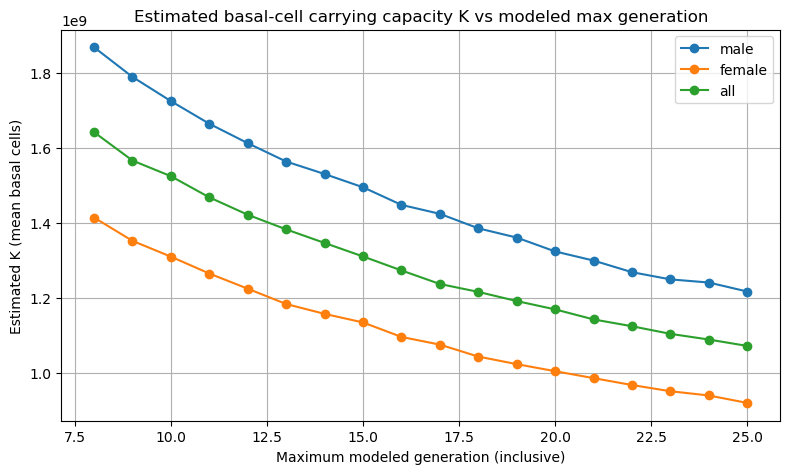

Saved summary CSV to basal_K_vs_gens_summary_final.csv and plot to ./basal_K_vs_gens_plot_final.png

Diagnostics (generation 15):
 male   D0_mean_mm=20.68, model_area_before_scaling_mean=25411.5, scale_mean=0.103
   mean area fractions per gen (first few): [0.0008 0.001  0.0012 0.0015 0.0019 0.0024] ... last: 0.1995
   p_means (per-gen): [0.4        0.31       0.29958333 0.28916667 0.27875    0.26833333
 0.25791667 0.2475     0.23708333 0.22666667 0.21625    0.20583333
 0.19541667 0.185      0.17458333 0.16416667 0.15375    0.14333333
 0.13291667 0.1225     0.11208333 0.10166667 0.09125    0.08083333
 0.07041667 0.06      ]

 female D0_mean_mm=17.81, model_area_before_scaling_mean=18979.8, scale_mean=0.144
   mean area fractions per gen (first few): [0.0008 0.001  0.0012 0.0015 0.0019 0.0024] ... last: 0.1995
   p_means (per-gen): [0.4        0.31       0.29958333 0.28916667 0.27875    0.26833333
 0.25791667 0.2475     0.23708333 0.22666667 0.21625    0.20583333
 0.19541667 0.185      

<Figure size 640x480 with 0 Axes>

In [70]:
# Basal-cell carrying-capacity pipeline (single Jupyter cell)
# Reproducible, vectorized, Monte-Carlo uncertainty propagation
# Paste this whole cell into a Jupyter notebook and run.

import numpy as np
import pandas as pd
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
np.random.seed(42)

# ----------------------- PAPER-RETRIEVED ANCHORS -----------------------
# Mercer 1994 morphometry anchor:
mercer_area_mean_cm2 = 2471.0        # "Total airway surface area ... 2,471 +/- 320 cm^2" (Mercer et al.)
mercer_area_sd_cm2   = 320.0

# Total airway epithelial cells (Mercer): 10.5 x 10^9
epi_cells_mean = 10.5e9              # Mercer: "The total number of airway epithelial cells were 10.5 x 10^9 for human"
# Assume epithelial-cell-count uncertainty scales with Mercer area CV
epi_cells_sd = epi_cells_mean * (mercer_area_sd_cm2 / mercer_area_mean_cm2)

# Kamel et al. (CT) tracheal measurements (means ± SD) - sex-stratified
# (used as volume/length anchor to compute D0 = sqrt(4*(V/L)/pi))
sex_params = {
    'male': {
        'L_mean_mm': 105.1, 'L_sd_mm': 9.8,    # tracheal length (mm) - Kamel 2009
        'V_mean_cm3': 35.6, 'V_sd_cm3': 6.8,   # tracheal lumen volume (cm^3) - Kamel 2009
        'TLV_mean_L': 6.2, 'TLV_sd_L': 1.2     # mean TLV (L) used to scale epithelial totals (population CT)
    },
    'female': {
        'L_mean_mm': 98.3, 'L_sd_mm': 8.7,
        'V_mean_cm3': 24.7, 'V_sd_cm3': 6.1,
        'TLV_mean_L': 4.7, 'TLV_sd_L': 0.9
    },
    'all': {  # combined cohort anchors (Kamel "all" column)
        'L_mean_mm': 102.8, 'L_sd_mm': 9.9,
        'V_mean_cm3': 32.0,  'V_sd_cm3': 8.3,
        'TLV_mean_L': 0.5*(6.2 + 4.7), 'TLV_sd_L': 1.05
    }
}
TLV_ref_mean = 0.5*(6.2 + 4.7)  # reference TLV used for scaling epithelial counts

# Weibel-style geometry & morphometry inputs
h = 0.79                    # diameter reduction factor per generation (Weibel style)
LD_mean, LD_sd = 1.46, 0.15 # length-to-diameter ratio mean and SD (morphometry literature)

# Basal fraction anchoring:
# generation 0 (trachea): use murine trachea value as requested (Hogan et al., PMC4518462)
p0_mean, p0_sd = 0.40, 0.05    # tracheal basal fraction mean ± sd (murine data)
# generation 1 baseline (proximal bronchi) from human histology (Boers 1998)
p1_mean = 0.31                 # "largest conducting airways (>=4mm) 31% basal" (Boers)
# distal generation 15 (terminal bronchiole anchor)
pN_mean = 0.06                 # "smallest (<0.5 mm) ~6% basal" (Boers)
# per-generation sd for gens 1..N
p_gen_sd = 0.03

# Monte-Carlo settings
N_draws = 8000   # MC draws (adjust if you want smoother tails; larger -> more memory/time)
max_gen_default = 15   # default terminal generation (we stop at generation 15)
# -----------------------------------------------------------------------

# helper: truncated-normal sampler wrapper
def trunc_normal_draw(mean, sd, size, lower=None, upper=None):
    """Truncated-normal draws using scipy.stats.truncnorm parameterization."""
    # default truncation to ±4 sd if bounds not provided
    if lower is None:
        lower = mean - 4*sd
    if upper is None:
        upper = mean + 4*sd
    a, b = (lower - mean) / sd, (upper - mean) / sd
    return truncnorm.rvs(a, b, loc=mean, scale=sd, size=size)

# Vectorized compute function: compute K distributions for a chosen max_gen
def compute_K_distribution(max_gen=max_gen_default, N=N_draws,
                           p0=p0_mean, p0_sd_in=p0_sd, p1=p1_mean, pN=pN_mean, p_sd=p_gen_sd):
    """
    Compute Monte-Carlo sampled distributions of K (basal cell counts) per sex,
    given:
      - max_gen: inclusive max generation index (0..max_gen)
      - N: number of MC draws
      - p0: basal fraction at generation 0 (trachea)
      - p1: basal fraction at generation 1
      - pN: basal fraction at generation max_gen
    Returns:
      results: dict mapping sex -> ndarray shape (N,) with basal-cell counts samples
      diagnostics: dict of diagnostic arrays / means (D0 mean, scale mean, area fractions etc.)
    """
    gens = np.arange(0, max_gen+1)
    G = len(gens)
    pow_h = h ** gens             # shape (G,)
    branches = (2 ** gens).astype(float)

    # draw common anchors
    epi_cells_draw = trunc_normal_draw(epi_cells_mean, epi_cells_sd, N, lower=1e8, upper=1e11)
    LD_ratio = np.random.normal(LD_mean, LD_sd, N)  # length-to-diameter per draw

    # build per-generation basal means: p0 at gen 0, linear interpolation for gens 1..max_gen
    p_means = np.empty(G)
    p_sds   = np.empty(G)
    p_means[0] = p0
    p_sds[0]   = p0_sd_in
    if G > 1:
        # linear interpolation for gens 1..max_gen: p1 at n=1, pN at n=max_gen
        p_means[1:] = p1 + (pN - p1) * ((gens[1:] - 1) / float(max_gen - 1))
        p_sds[1:]   = p_sd

    results = {}
    diagnostics = {}

    # loop sexes (only 3 keys) but heavy work is vectorized internally
    for sex_key, params in sex_params.items():
        # truncated draws for tracheal length and volume for this sex
        L_mm = trunc_normal_draw(params['L_mean_mm'], params['L_sd_mm'], N,
                                 lower=10.0, upper=params['L_mean_mm'] + 4*params['L_sd_mm'])
        V_cm3 = trunc_normal_draw(params['V_mean_cm3'], params['V_sd_cm3'], N,
                                  lower=0.1, upper=params['V_mean_cm3'] + 4*params['V_sd_cm3'])
        # convert length to cm
        L_cm = L_mm / 10.0
        # equivalent circular diameter from volume/length
        D0_cm = np.sqrt(4.0 * (V_cm3 / L_cm) / np.pi)    # cm
        D0_mm = D0_cm * 10.0                              # mm

        # generation diameters (broadcasted): shape (N, G)
        D_n = D0_mm[:, None] * pow_h[None, :]             # mm
        D_n_cm = D_n / 10.0                               # cm

        # lateral area per branch approximation: pi * D * length, with length = LD_ratio * D
        area_branch_cm2 = np.pi * LD_ratio[:, None] * (D_n_cm ** 2)   # (N,G)
        # total area per generation = area per branch * branch count
        area_gen_total = area_branch_cm2 * branches[None, :]          # (N,G)
        # model total area for draw i
        model_total_area = area_gen_total.sum(axis=1)                 # (N,)

        # empirical scaling s that matches Mercer total measured area (scalar per draw)
        scale = mercer_area_mean_cm2 / model_total_area               # (N,)
        scaled_area_gen = area_gen_total * scale[:, None]            # (N,G); sums to mercer_area_mean_cm2

        # draw per-generation basal fractions using truncated normals (N x G)
        p_draws = np.empty((N, G))
        for j in range(G):
            p_draws[:, j] = trunc_normal_draw(p_means[j], p_sds[j], N, lower=0.0, upper=1.0)

        # area-weighted basal fraction per draw: sum_j (A'_j * p_j) / A_meas
        f_basal = (scaled_area_gen * p_draws).sum(axis=1) / mercer_area_mean_cm2   # (N,)

        # scale epithelial count by sex TLV draws
        TLV_draws = trunc_normal_draw(params['TLV_mean_L'], params['TLV_sd_L'], N,
                                      lower=max(0.5, params['TLV_mean_L'] - 3*params['TLV_sd_L']),
                                      upper=params['TLV_mean_L'] + 4*params['TLV_sd_L'])
        epi_cells_sex = epi_cells_draw * (TLV_draws / TLV_ref_mean)

        # basal cells per draw
        basal_cells = epi_cells_sex * f_basal     # (N,)

        # store
        results[sex_key] = basal_cells
        diagnostics[sex_key] = {
            'D0_mm_mean': float(D0_mm.mean()),
            'model_area_mean_before_scaling_cm2': float(model_total_area.mean()),
            'scale_mean': float(scale.mean()),
            'f_basal_mean': float(f_basal.mean()),
            'area_frac_means': (scaled_area_gen.mean(axis=0) / mercer_area_mean_cm2),
            'p_means': p_means.copy()
        }

    return results, diagnostics

# ----------------------- RUN: compute K for default max_gen=25 -----------------------
results25, diag25 = compute_K_distribution(max_gen=25, N=N_draws)

# Summaries for generation-15 run
def summarize_arr(arr):
    return {
        'mean': float(arr.mean()),
        'median': float(np.median(arr)),
        '2.5%': float(np.percentile(arr, 2.5)),
        '97.5%': float(np.percentile(arr, 97.5))
    }

summary25 = {sex: summarize_arr(results25[sex]) for sex in results25}
print("Summary for max_gen=25 (default):")
for sex, s in summary25.items():
    print(f" {sex:6s} : mean={s['mean']:.3e}, median={s['median']:.3e}, 95% CI=({s['2.5%']:.3e}, {s['97.5%']:.3e})")

# ----------------------- SENSITIVITY: sweep max_gen and plot K(mean) vs max_gen -----------------------
max_gen_values = list(range(8, 26))   # sweep from 8 to 24 inclusive
summary_records = []
for mg in max_gen_values:
    res, dg = compute_K_distribution(max_gen=mg, N=5000)  # lower N for sweep to conserve time
    for sex in res:
        arr = res[sex]
        summary_records.append({
            'max_gen': mg,
            'sex': sex,
            'mean': float(arr.mean()),
            'median': float(np.median(arr)),
            'p2.5': float(np.percentile(arr, 2.5)),
            'p97.5': float(np.percentile(arr, 97.5))
        })

summary_df = pd.DataFrame(summary_records)
pivot_mean = summary_df.pivot(index='max_gen', columns='sex', values='mean')

# Plot mean K vs modeled maximum generation
plt.figure(figsize=(8,5))
for sex in ['male', 'female', 'all']:
    plt.plot(pivot_mean.index, pivot_mean[sex], marker='o', label=sex)
plt.xlabel('Maximum modeled generation (inclusive)')
plt.ylabel('Estimated K (mean basal cells)')
plt.title('Estimated basal-cell carrying capacity K vs modeled max generation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save CSV and simple figure
csv_path = 'basal_K_vs_gens_summary_final.csv'
plt.savefig('basal_K_vs_gens_plot_final.png', dpi=150)
summary_df.to_csv(csv_path, index=False)
print(f"Saved summary CSV to {csv_path} and plot to ./basal_K_vs_gens_plot_final.png")

# Also expose the detailed generation-15 diagnostics (area fractions and p_means)
print("\nDiagnostics (generation 15):")
for sex, d in diag25.items():
    print(f" {sex:6s} D0_mean_mm={d['D0_mm_mean']:.2f}, model_area_before_scaling_mean={d['model_area_mean_before_scaling_cm2']:.1f}, scale_mean={d['scale_mean']:.3f}")
    print(f"   mean area fractions per gen (first few): {d['area_frac_means'][:6].round(4)} ... last: {d['area_frac_means'][-1]:.4f}")
    print(f"   p_means (per-gen): {d['p_means']}\n")


Summary table (saved to K_summary_by_sex_and_model.csv):
     sex k_variant mean_total_basal   CI_2.5  CI_97.5
combined  constant         1.31e+09 7.49e+08 1.98e+09
combined piecewise         1.03e+09 5.73e+08 1.60e+09
    male  constant         1.49e+09 8.51e+08 2.25e+09
    male piecewise         1.17e+09 6.50e+08 1.82e+09
  female  constant         1.13e+09 6.48e+08 1.70e+09
  female piecewise         8.86e+08 4.96e+08 1.37e+09

Per-generation table (combined, piecewise) saved to per_gen_basal_combined_piecewise.csv
Plots saved: K_comparison_bar.png and per_gen_piecewise.png


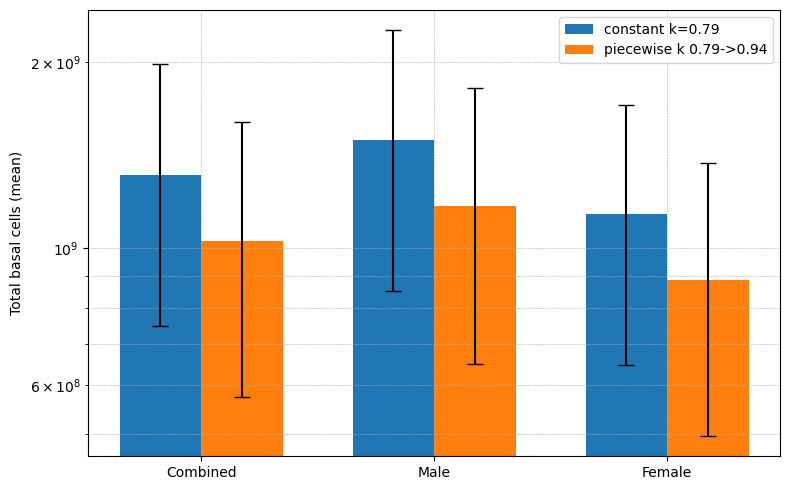

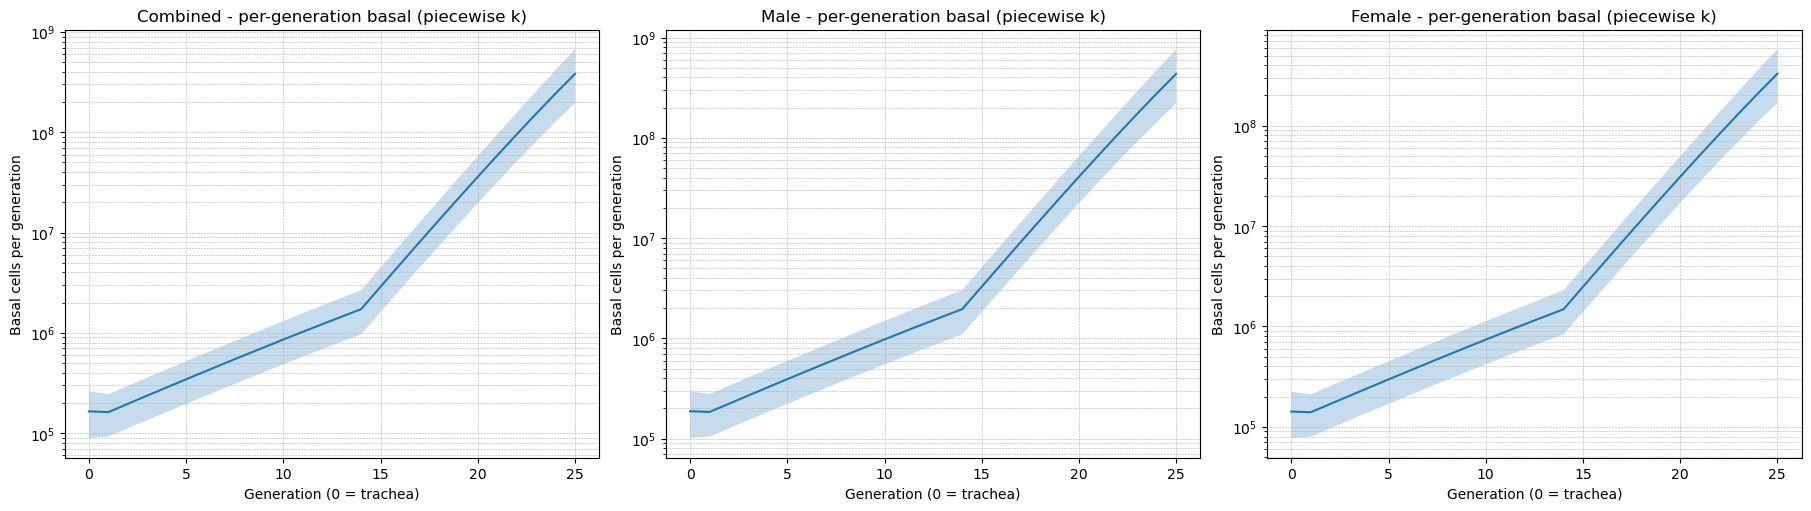

In [5]:
"""
Jupyter-compatible script: Monte Carlo estimation of airway basal-cell carrying capacity K
- Sex-specific geometry interacts with epithelial density (TLV scaling per sample)
- Two k-variants: constant (k=0.79) and piecewise (k=0.79 -> 0.94 from generation 15)
- Uses scipy.stats.truncnorm for truncated-normal sampling (vectorized)
- Computes K for both models; plots per-generation basal counts for the piecewise model
- Vectorized; no python-level loops over samples/generations

To run in a notebook: place this code in a cell or save as .py and run. Requires: numpy, pandas, matplotlib, scipy
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
from scipy.stats import truncnorm

# -------------------- Anchors / Inputs --------------------
# Mercer et al. anchors (paper-provided)
mercer_area_mean_cm2 = 2471.0
mercer_area_sd_cm2   = 320.0
epi_cells_mean = 10.5e9
# scale epi_cells sd with Mercer area CV
epi_cells_sd = epi_cells_mean * (mercer_area_sd_cm2 / mercer_area_mean_cm2)

# Sex-stratified geometry anchors (Kamel et al. CT)
sex_params = {
    'male': {
        'L_mean_mm': 105.1, 'L_sd_mm': 9.8,
        'V_mean_cm3': 35.6, 'V_sd_cm3': 6.8,
        'TLV_mean_L': 6.2, 'TLV_sd_L': 1.2
    },
    'female': {
        'L_mean_mm': 98.3, 'L_sd_mm': 8.7,
        'V_mean_cm3': 24.7, 'V_sd_cm3': 6.1,
        'TLV_mean_L': 4.7, 'TLV_sd_L': 0.9
    },
    'combined': {
        'L_mean_mm': 102.8, 'L_sd_mm': 9.9,
        'V_mean_cm3': 32.0, 'V_sd_cm3': 8.3,
        'TLV_mean_L': 0.5*(6.2 + 4.7), 'TLV_sd_L': 1.05
    }
}
TLV_ref_mean = 0.5*(6.2 + 4.7)

# Weibel-style and basal fraction anchors
k_before = 0.79
k_after  = 0.94  # piecewise change starting at gen 15
LD_mean, LD_sd = 1.46, 0.15
p0_mean, p0_sd = 0.40, 0.05    # tracheal basal fraction (murine anchor used per user)
p1_mean = 0.31
pN_mean = 0.06
p_gen_sd = 0.03

G_max = 25
gens = np.arange(0, G_max + 1)

# Monte Carlo settings
N_SAMPLES = 500000
SEED_BASE = 42

# -------------------- helpers: truncated normal sampling --------------------
def truncnorm_a_b(lower, upper, loc, scale):
    """Return (a, b) parameters for scipy.stats.truncnorm given bounds, loc, scale."""
    a, b = (lower - loc) / scale, (upper - loc) / scale
    return a, b

def sample_truncnorm(loc, scale, lower, upper, size, random_state=None):
    """Vectorized truncated normal sampling wrapper using scipy.stats.truncnorm.rvs."""
    if scale == 0:
        return np.full(size, loc)
    a, b = truncnorm_a_b(lower, upper, loc, scale)
    return truncnorm.rvs(a, b, loc=loc, scale=scale, size=size, random_state=random_state)

# -------------------- main simulation function (vectorized) --------------------
def run_pipeline(sex='combined', n_samples=N_SAMPLES, k_variant='constant', seed=0):
    rng = np.random.default_rng(seed)

    # truncated draws for Mercer area and epithelial counts
    mercer_area = sample_truncnorm(mercer_area_mean_cm2, mercer_area_sd_cm2, lower=500.0, upper=1e5, size=n_samples, random_state=rng)
    epi_cells = sample_truncnorm(epi_cells_mean, epi_cells_sd, lower=1e7, upper=1e12, size=n_samples, random_state=rng)

    # sex-specific geometry
    sp = sex_params[sex]
    L_mm = sample_truncnorm(sp['L_mean_mm'], sp['L_sd_mm'], lower=10.0, upper=300.0, size=n_samples, random_state=rng)
    L_cm = L_mm / 10.0
    V_cm3 = sample_truncnorm(sp['V_mean_cm3'], sp['V_sd_cm3'], lower=1.0, upper=500.0, size=n_samples, random_state=rng)
    TLV_L = sample_truncnorm(sp['TLV_mean_L'], sp['TLV_sd_L'], lower=0.5, upper=12.0, size=n_samples, random_state=rng)

    # D0 from tracheal lumen geometry
    D0_cm = np.sqrt(4.0 * (V_cm3 / L_cm) / pi)

    # LD per sample
    LD = sample_truncnorm(LD_mean, LD_sd, lower=0.2, upper=5.0, size=n_samples, random_state=rng)

    # epithelial counts scaled by subject TLV relative to reference (sex-specific density coupling)
    epi_cells_scaled = epi_cells * (TLV_L / TLV_ref_mean)

    # build per-generation diameters
    if k_variant == 'constant':
        Dg = D0_cm[:, None] * (k_before ** gens)[None, :]
    elif k_variant == 'piecewise':
        g_counts_before = np.minimum(gens, 14)
        g_counts_after = np.maximum(gens - 14, 0)
        Dg = D0_cm[:, None] * (k_before ** g_counts_before[None, :]) * (k_after ** g_counts_after[None, :])
    else:
        raise ValueError("k_variant must be 'constant' or 'piecewise'")

    # lengths and raw areas per airway
    Lg = LD[:, None] * Dg  # airway length per airway (cm)
    Ag_per_airway = pi * Dg * Lg  # lateral area per airway (cm^2)
    total_Ag_raw = Ag_per_airway * (2 ** gens)[None, :]  # raw total area per gen (cm^2)
    A_model_total = np.sum(total_Ag_raw, axis=1)

    # scalar to enforce Mercer's measured total area
    scalar = mercer_area / A_model_total
    scalar = scalar[:, None]
    total_area_g = total_Ag_raw * scalar  # scaled areas per generation

    # epithelial cell density (cells/cm^2) for each sample
    cells_per_cm2 = epi_cells_scaled / mercer_area

    # basal fraction p_g: gen0 sampled; gens 1..G linear interpolation between p1 and pN
    linear_values = np.zeros_like(gens, dtype=float)
    linear_values[0] = np.nan
    linear_values[1:] = p1_mean + (pN_mean - p1_mean) * (gens[1:] - 1) / (G_max - 1)
    p0 = sample_truncnorm(p0_mean, p0_sd, lower=0.0, upper=1.0, size=n_samples, random_state=rng)
    p_base = np.tile(linear_values[None, :], (n_samples, 1))
    p_base[:, 0] = p0

    # per-generation noise (truncated so stays in [0,1])
    noise = truncnorm.rvs(*truncnorm_a_b(0 - 0.0, 1 - 0.0, loc=0.0, scale=p_gen_sd), loc=0.0, scale=p_gen_sd, size=(n_samples, gens.size), random_state=rng)
    p_g = p_base + noise
    p_g = np.clip(p_g, 0.0, 1.0)  # numerical safety

    # basal counts per generation and totals
    basal_cells_g = total_area_g * cells_per_cm2[:, None] * p_g
    basal_total = np.sum(basal_cells_g, axis=1)
    basal_cumulative = np.cumsum(basal_cells_g, axis=1)

    # summary statistics
    summary = {
        'mean_total_basal': np.mean(basal_total),
        'median_total_basal': np.median(basal_total),
        'ci_2.5': np.percentile(basal_total, 2.5),
        'ci_97.5': np.percentile(basal_total, 97.5),
        'per_gen_mean': np.mean(basal_cells_g, axis=0),
        'per_gen_ci_lower': np.percentile(basal_cells_g, 2.5, axis=0),
        'per_gen_ci_upper': np.percentile(basal_cells_g, 97.5, axis=0),
        'gens': gens
    }

    return {
        'summary': summary,
        'basal_total_samples': basal_total,
        'basal_cumulative': basal_cumulative,
        'basal_cells_g': basal_cells_g,
        'total_area_g': total_area_g,
        'cells_per_cm2': cells_per_cm2,
        'p_g': p_g,
        'Dg': Dg,
        'Lg': Lg,
        'scalar': scalar
    }

# -------------------- run for sexes and both variants --------------------
results = {}
for sex in ['combined', 'male', 'female']:
    results[(sex, 'constant')] = run_pipeline(sex=sex, n_samples=N_SAMPLES, k_variant='constant', seed=SEED_BASE + hash(sex) % 1000)
    results[(sex, 'piecewise')] = run_pipeline(sex=sex, n_samples=N_SAMPLES, k_variant='piecewise', seed=SEED_BASE + 1000 + hash(sex) % 1000)

# -------------------- assemble summary table --------------------
rows = []
for (sex, kv), out in results.items():
    s = out['summary']
    rows.append({
        'sex': sex,
        'k_variant': kv,
        'mean_total_basal': s['mean_total_basal'],
        'CI_2.5': s['ci_2.5'],
        'CI_97.5': s['ci_97.5']
    })

df_summary = pd.DataFrame(rows)
# format for readability
for c in ['mean_total_basal','CI_2.5','CI_97.5']:
    df_summary[c] = df_summary[c].map(lambda x: f"{x:,.2e}")

# -------------------- plots --------------------
# 1) Bar chart: K (mean) for both variants by sex with error bars
fig1, ax1 = plt.subplots(figsize=(8,5))
bar_width = 0.35
sex_order = ['combined','male','female']
inds = np.arange(len(sex_order))
means_const = [results[(s,'constant')]['summary']['mean_total_basal'] for s in sex_order]
means_pw = [results[(s,'piecewise')]['summary']['mean_total_basal'] for s in sex_order]
ci_lo_const = [results[(s,'constant')]['summary']['mean_total_basal'] - results[(s,'constant')]['summary']['ci_2.5'] for s in sex_order]
ci_hi_const = [results[(s,'constant')]['summary']['ci_97.5'] - results[(s,'constant')]['summary']['mean_total_basal'] for s in sex_order]
ci_lo_pw = [results[(s,'piecewise')]['summary']['mean_total_basal'] - results[(s,'piecewise')]['summary']['ci_2.5'] for s in sex_order]
ci_hi_pw = [results[(s,'piecewise')]['summary']['ci_97.5'] - results[(s,'piecewise')]['summary']['mean_total_basal'] for s in sex_order]

ax1.bar(inds - bar_width/2, means_const, bar_width, label='constant k=0.79', yerr=[ci_lo_const, ci_hi_const], capsize=6)
ax1.bar(inds + bar_width/2, means_pw, bar_width, label='piecewise k 0.79->0.94', yerr=[ci_lo_pw, ci_hi_pw], capsize=6)
ax1.set_xticks(inds)
ax1.set_xticklabels([s.capitalize() for s in sex_order])
ax1.set_ylabel('Total basal cells (mean)')
ax1.set_yscale('log')
ax1.legend()
ax1.grid(True, which='both', linestyle='--', linewidth=0.4)
fig1.tight_layout()
fig1.savefig('K_comparison_bar.png', dpi=200)

# 2) Per-generation plot only for the piecewise model (three subplots: combined, male, female)
fig2, axes = plt.subplots(1, 3, figsize=(18,5), constrained_layout=True)
for ax, sex in zip(axes, sex_order):
    out = results[(sex, 'piecewise')]
    gens = out['summary']['gens']
    mean_per_gen = out['summary']['per_gen_mean']
    lower = out['summary']['per_gen_ci_lower']
    upper = out['summary']['per_gen_ci_upper']

    ax.plot(gens, mean_per_gen, linewidth=1.5)
    ax.fill_between(gens, lower, upper, alpha=0.25)
    ax.set_yscale('log')
    ax.set_xlabel('Generation (0 = trachea)')
    ax.set_title(f'{sex.capitalize()} - per-generation basal (piecewise k)')
    ax.set_ylabel('Basal cells per generation')
    ax.grid(True, which='both', linestyle='--', linewidth=0.4)

fig2.savefig('per_gen_piecewise.png', dpi=200)

# 3) save per-gen numeric table for piecewise combined
per_gen_table = pd.DataFrame({
    'gen': results[('combined','piecewise')]['summary']['gens'],
    'mean_basal': results[('combined','piecewise')]['summary']['per_gen_mean'],
    'ci_lower': results[('combined','piecewise')]['summary']['per_gen_ci_lower'],
    'ci_upper': results[('combined','piecewise')]['summary']['per_gen_ci_upper']
})
per_gen_table.to_csv('per_gen_basal_combined_piecewise.csv', index=False)

# 4) save summary
df_summary.to_csv('K_summary_by_sex_and_model.csv', index=False)

# Print short textual summaries
print('Summary table (saved to K_summary_by_sex_and_model.csv):')
print(df_summary.to_string(index=False))
print('\nPer-generation table (combined, piecewise) saved to per_gen_basal_combined_piecewise.csv')
print('Plots saved: K_comparison_bar.png and per_gen_piecewise.png')


/tmp/ipykernel_316236/768187125.py:179: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_display[['mean_total_basal','median_total_basal','CI_2.5','CI_97.5']] = df_display[['mean_total_basal','median_total_basal','CI_2.5','CI_97.5']].applymap(lambda x: f"{x:,.2e}")


done


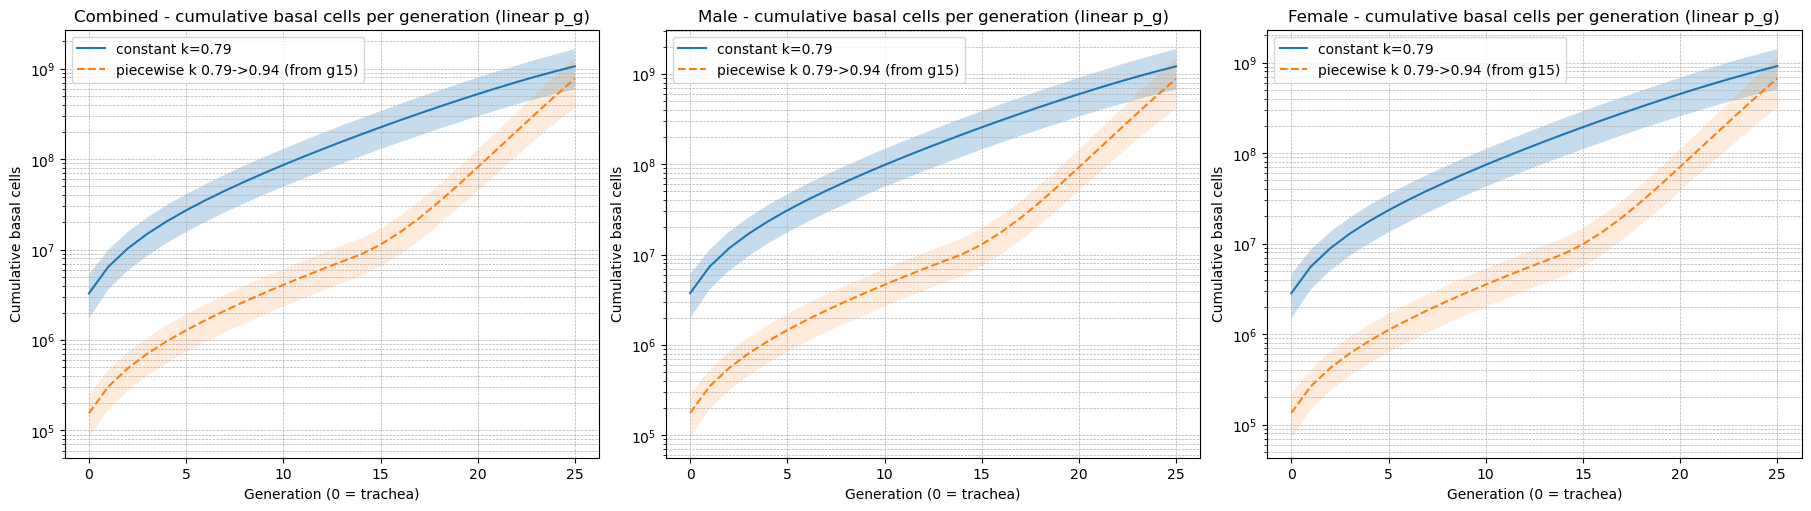

In [6]:
# Updated Monte Carlo with requested changes:
# 1) linear interpolation for basal fraction p_g (gen0 uses sampled p0; g>=1 linear between p1 at g=1 and pN at g=25)
# 2) truncated normal sampling (vectorized rejection sampling)
# 3) apply scaling factor scalar = mercer_area / sum(A_g) to force modeled total area to measured Mercer area
#
# Outputs: summary table and cumulative plots (constant k and piecewise k).

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi, sqrt
import io, base64
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# --------------------------- Anchors (user-provided) ---------------------------
mercer_area_mean_cm2 = 2471.0
mercer_area_sd_cm2   = 320.0
epi_cells_mean = 10.5e9
# epi_cells_sd scales with Mercer area CV
epi_cells_sd = epi_cells_mean * (mercer_area_sd_cm2 / mercer_area_mean_cm2)

sex_params = {
    'male': {
        'L_mean_mm': 105.1, 'L_sd_mm': 9.8,
        'V_mean_cm3': 35.6, 'V_sd_cm3': 6.8,
        'TLV_mean_L': 6.2, 'TLV_sd_L': 1.2
    },
    'female': {
        'L_mean_mm': 98.3, 'L_sd_mm': 8.7,
        'V_mean_cm3': 24.7, 'V_sd_cm3': 6.1,
        'TLV_mean_L': 4.7, 'TLV_sd_L': 0.9
    },
    'combined': { 
        'L_mean_mm': 102.8, 'L_sd_mm': 9.9,
        'V_mean_cm3': 32.0,  'V_sd_cm3': 8.3,
        'TLV_mean_L': 0.5*(6.2 + 4.7), 'TLV_sd_L': 1.05
    }
}
TLV_ref_mean = 0.5*(6.2 + 4.7)

k_before = 0.79
k_after  = 0.94
LD_mean, LD_sd = 1.46, 0.15

p0_mean, p0_sd = 0.40, 0.05
p1_mean = 0.31
pN_mean = 0.06
p_gen_sd = 0.03

G_max = 25
gens = np.arange(0, G_max + 1)
n_g = 2 ** gens

# --------------------------- helper: truncated normal sampling ---------------------------
def truncnorm_sample(rng, mean, sd, lower, upper, size):
    """Truncated normal sampling via rejection sampling. Returns array of shape (size,)."""
    if sd == 0:
        return np.full(size, mean)
    samples = rng.normal(mean, sd, size=size)
    mask = (samples < lower) | (samples > upper)
    # Iteratively resample where out-of-bounds
    while mask.any():
        ns = mask.sum()
        samples[mask] = rng.normal(mean, sd, size=ns)
        mask = (samples < lower) | (samples > upper)
    return samples

# --------------------------- Monte Carlo function (vectorized) ---------------------------
def run_sim_trunc(sex='combined', n_samples=20000, k_variant='constant', seed=12345):
    rng = np.random.default_rng(seed)
    # Truncated samples for mercer area and epi_cells (positive)
    mercer_area = truncnorm_sample(rng, mercer_area_mean_cm2, mercer_area_sd_cm2, lower=500.0, upper=1e5, size=n_samples)
    epi_cells = truncnorm_sample(rng, epi_cells_mean, epi_cells_sd, lower=1e7, upper=1e12, size=n_samples)
    
    sp = sex_params[sex]
    L_mm = truncnorm_sample(rng, sp['L_mean_mm'], sp['L_sd_mm'], lower=10.0, upper=300.0, size=n_samples)
    L_cm = L_mm / 10.0
    V_cm3 = truncnorm_sample(rng, sp['V_mean_cm3'], sp['V_sd_cm3'], lower=1.0, upper=500.0, size=n_samples)
    TLV_L = truncnorm_sample(rng, sp['TLV_mean_L'], sp['TLV_sd_L'], lower=0.5, upper=12.0, size=n_samples)
    
    # D0
    D0_cm = np.sqrt(4.0 * (V_cm3 / L_cm) / pi)
    
    # LD
    LD = truncnorm_sample(rng, LD_mean, LD_sd, lower=0.2, upper=5.0, size=n_samples)
    
    # epi_cells scaled by TLV relative to ref
    epi_cells_scaled = epi_cells * (TLV_L / TLV_ref_mean)
    
    # diameter per generation
    if k_variant == 'constant':
        Dg = D0_cm[:, None] * (k_before ** gens)[None, :]
    else:
        g_counts_before = np.minimum(gens, 14)
        g_counts_after = np.maximum(gens - 14, 0)
        Dg = D0_cm[:, None] * (k_before ** g_counts_before[None, :]) * (k_after ** g_counts_after[None, :])
    
    # length per airway and raw area per airway
    Lg = LD[:, None] * Dg  # cm
    Ag_per_airway = pi * Dg * Lg  # cm^2
    total_Ag_raw = Ag_per_airway * n_g[None, :]  # cm^2 per gen for each sample
    A_model_total = np.sum(total_Ag_raw, axis=1)
    
    # scalar to enforce measured Mercer area
    scalar = mercer_area / A_model_total
    scalar = scalar[:, None]  # broadcast
    
    # scaled areas per gen
    total_area_g = total_Ag_raw * scalar  # now sum across gens equals mercer_area per sample
    
    # cells per cm2 based on epi_cells_scaled and mercer_area (consistent)
    cells_per_cm2 = epi_cells_scaled / mercer_area
    
    # basal fraction p_g: linear interpolation for g>=1; g=0 uses sampled p0
    # linear for g>=1: p1 at g=1, pN at g=25
    linear_g = np.zeros_like(gens, dtype=float)
    linear_g[0] = np.nan  # placeholder
    linear_g[1:] = p1_mean + (pN_mean - p1_mean) * (gens[1:] - 1) / (G_max - 1)
    # Expand to samples and set gen0 = sampled p0 (truncated between 0 and 1)
    p0 = truncnorm_sample(rng, p0_mean, p0_sd, lower=0.0, upper=1.0, size=n_samples)
    p_base = np.tile(linear_g[None, :], (n_samples, 1))
    p_base[:, 0] = p0
    
    # add per-gen noise (truncated so stays within [0,1])
    noise = rng.normal(0.0, p_gen_sd, size=p_base.shape)
    p_g = p_base + noise
    # enforce [0,1] via clipping (since p_gen_sd small); but user requested truncated normals for draws — this is per-gen noise, we'll clip
    p_g = np.clip(p_g, 0.0, 1.0)
    
    # basal cells per generation and totals
    basal_cells_g = total_area_g * (cells_per_cm2[:, None]) * p_g
    basal_total = np.sum(basal_cells_g, axis=1)
    basal_cumulative = np.cumsum(basal_cells_g, axis=1)
    
    # summary
    summary = {
        'mean_total_basal': np.mean(basal_total),
        'median_total_basal': np.median(basal_total),
        'ci_2.5': np.percentile(basal_total, 2.5),
        'ci_97.5': np.percentile(basal_total, 97.5)
    }
    results = {
        'summary': summary,
        'basal_total_samples': basal_total,
        'basal_cumulative': basal_cumulative,
        'per_gen_mean': np.mean(basal_cells_g, axis=0),
        'per_gen_ci_lower': np.percentile(basal_cells_g, 2.5, axis=0),
        'per_gen_ci_upper': np.percentile(basal_cells_g, 97.5, axis=0),
        'gens': gens,
        'total_area_per_gen_mean': np.mean(total_area_g, axis=0),
        'total_area_per_gen_ci_lower': np.percentile(total_area_g, 2.5, axis=0),
        'total_area_per_gen_ci_upper': np.percentile(total_area_g, 97.5, axis=0)
    }
    return results

# --------------------------- run sims ---------------------------
n_samples = 20000
out = {}
for sex in ['combined', 'male', 'female']:
    out[(sex, 'constant')] = run_sim_trunc(sex=sex, n_samples=n_samples, k_variant='constant', seed=100 + (0 if sex=='combined' else (1 if sex=='male' else 2)))
    out[(sex, 'piecewise')] = run_sim_trunc(sex=sex, n_samples=n_samples, k_variant='piecewise', seed=200 + (0 if sex=='combined' else (1 if sex=='male' else 2)))

# --------------------------- Summarize numeric results ---------------------------
rows = []
for (sex, kv), res in out.items():
    s = res['summary']
    rows.append({
        'sex': sex,
        'k_variant': kv,
        'mean_total_basal': s['mean_total_basal'],
        'median_total_basal': s['median_total_basal'],
        'CI_2.5': s['ci_2.5'],
        'CI_97.5': s['ci_97.5']
    })

df_results = pd.DataFrame(rows)
df_display = df_results.copy()
df_display[['mean_total_basal','median_total_basal','CI_2.5','CI_97.5']] = df_display[['mean_total_basal','median_total_basal','CI_2.5','CI_97.5']].applymap(lambda x: f"{x:,.2e}")

# import caas_jupyter_tools as cjt
# cjt.display_dataframe_to_user("Basal cell capacity (linear p_g, truncated normals, area-scaled) - summary", df_results)

# --------------------------- Plot cumulative basal population ---------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)
for ax, sex in zip(axes, ['combined', 'male', 'female']):
    r_const = out[(sex, 'constant')]
    r_pw = out[(sex, 'piecewise')]
    gens = r_const['gens']
    
    mean_const = np.mean(r_const['basal_cumulative'], axis=0)
    lower_const = np.percentile(r_const['basal_cumulative'], 2.5, axis=0)
    upper_const = np.percentile(r_const['basal_cumulative'], 97.5, axis=0)
    
    mean_pw = np.mean(r_pw['basal_cumulative'], axis=0)
    lower_pw = np.percentile(r_pw['basal_cumulative'], 2.5, axis=0)
    upper_pw = np.percentile(r_pw['basal_cumulative'], 97.5, axis=0)
    
    ax.plot(gens, mean_const, linewidth=1.5, label='constant k=0.79')
    ax.fill_between(gens, lower_const, upper_const, alpha=0.25)
    
    ax.plot(gens, mean_pw, linestyle='--', linewidth=1.5, label='piecewise k 0.79->0.94 (from g15)')
    ax.fill_between(gens, lower_pw, upper_pw, alpha=0.15)
    
    ax.set_title(f"{sex.capitalize()} - cumulative basal cells per generation (linear p_g)")
    ax.set_xlabel("Generation (0 = trachea)")
    ax.set_ylabel("Cumulative basal cells")
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
# buf = io.BytesIO()
# plt.savefig(buf, format='png', bbox_inches='tight', dpi=150)
# buf.seek(0)
# img_b64 = base64.b64encode(buf.read()).decode('utf-8')
# buf.close()

# per-generation table for combined, piecewise example
per_gen_table = pd.DataFrame({
    'gen': gens,
    'mean_basal_combined_piecewise': out[('combined','piecewise')]['per_gen_mean'],
    'ci_lower': out[('combined','piecewise')]['per_gen_ci_lower'],
    'ci_upper': out[('combined','piecewise')]['per_gen_ci_upper'],
    'mean_area_cm2': out[('combined','piecewise')]['total_area_per_gen_mean']
})
# cjt.display_dataframe_to_user("Per-generation basal (combined, piecewise k) - mean ± 95% CI", per_gen_table)

print("done")
# img_b64[:120]



## BBC critical threshold

In [86]:
b_crit_lb = (60e+06) / (1.03e+09)
print(b_crit_lb)

b_crit_ub = 0.90

b_crit_mean = st.gmean([0.058, 0.90])
print(b_crit_mean)

0.05825242718446602
0.22847319317591724


## Replication rate $r_b$

In [10]:
# r_b | lower

r_b_lower_per_day = {'mean': 1/11, 'range_low': 1/(11+4.4), 'range_high': 1/(11-4.4)}
r_b_lower_per_year = {k:v*DAYS_PER_YEAR for k,v in r_b_lower_per_day.items()}

print(r_b_lower_per_day)
print(r_b_lower_per_year)

{'mean': 0.09090909090909091, 'ci_low': 0.06493506493506493, 'ci_high': 0.15151515151515152}
{'mean': 33.203863636363636, 'ci_low': 23.717045454545453, 'ci_high': 55.33977272727273}


In [3]:
# Digitized points from Peters-Hall et al., 2019
bbc_pd_digitized_2019 = pd.DataFrame(data=[
    # [50, 25],
    [100, 75],
    [150, 105],
    [200, 125],
    [250, 155],
    [300, 165],
    [400, 200]
], columns=['day', 'PD'])

# Digitized points from Peters-Hall et al., 2018
bbc_pd_digitized_2018 = pd.DataFrame(data=[
    [48, 26],
    [60, 34],
    [66, 41],
    [69, 44],
    [74, 48],
    [80, 52],
    [90, 60]
], columns=['day', 'PD'])

# Function to estimate r from PD data
def r_estimation_from_pd(pd_digitized, DAYS_PER_YEAR):
    days = pd_digitized['day']
    doublings = pd_digitized['PD']
    slope, intercept, r_value, p_value, std_err = st.linregress(days, doublings)
    log2e = np.log2(np.e)
    r_per_day = slope / log2e
    r_per_year = r_per_day * DAYS_PER_YEAR
    return {
        'r_per_day': r_per_day,
        'r_per_year': r_per_year,
        'slope_doublings_per_day': slope,
        'intercept': intercept,
        'r_squared': r_value**2
    }

# Perform estimation for both datasets
est_2019 = r_estimation_from_pd(bbc_pd_digitized_2019, DAYS_PER_YEAR)
est_2018 = r_estimation_from_pd(bbc_pd_digitized_2018, DAYS_PER_YEAR)

# Combine results into a DataFrame
bbc_growth_summary = pd.DataFrame([
    {'Dataset': 'Peters-Hall et al. 2019', **est_2019},
    {'Dataset': 'Peters-Hall et al. 2018', **est_2018}
])
bbc_growth_summary

,Dataset,r_per_day,r_per_year,slope_doublings_per_day,intercept,r_squared
0,Peters-Hall et al. 2019,0.285181,104.160059,0.411429,41.500000,0.978864
1,Peters-Hall et al. 2018,0.573244,209.373165,0.827017,-13.965301,0.993990


In [4]:
# r_b_upper = 
bbc_growth_summary['r_per_day'].mean(), bbc_growth_summary['r_per_year'].mean()

(np.float64(0.42921240513586567), np.float64(156.7666118828364))

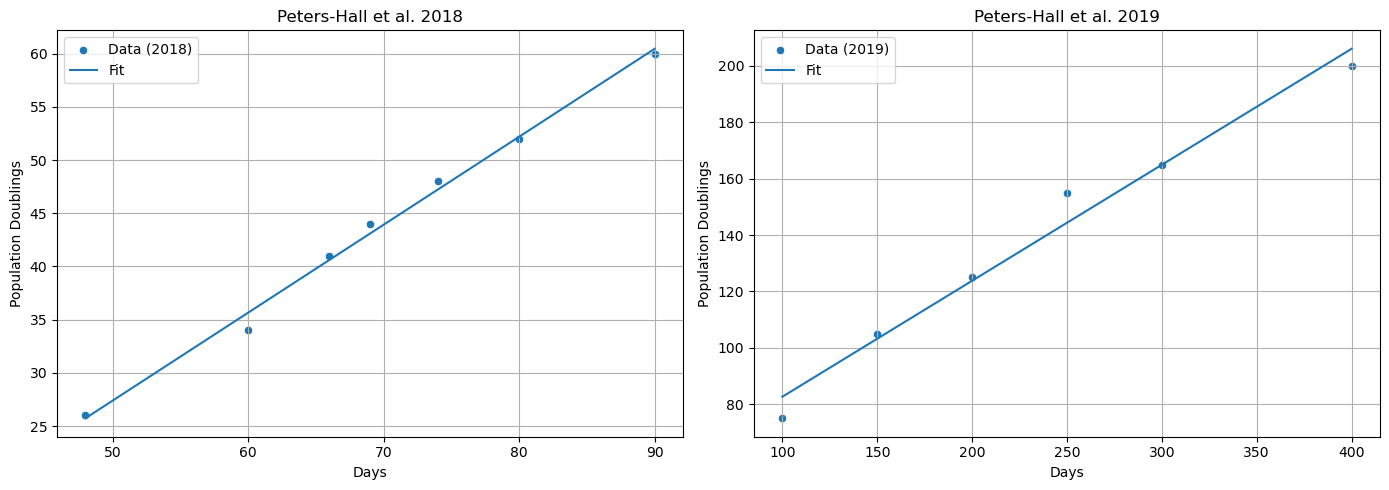

In [5]:
# Plotting both datasets in subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, ax in enumerate(axes):
    if i == 0: 
        data = bbc_pd_digitized_2018
        data_est = est_2018
        year = '2018'
    elif i == 1:
        data = bbc_pd_digitized_2019
        data_est = est_2019
        year = '2019'

    sns.scatterplot(data=data, x='day', y='PD', ax=ax, label=f'Data ({year})')
    sns.lineplot(x=data['day'], y=data_est['slope_doublings_per_day'] * data['day'] + data_est['intercept'], ax=ax, label='Fit')
    
    ax.set_title(f'Peters-Hall et al. {year}')
    ax.set_xlabel('Days')
    ax.set_ylabel('Population Doublings')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


In [11]:
# r_b | mean

r_b_mean = st.gmean([r_b_lower_per_day['mean']] + bbc_growth_summary['r_per_day'].tolist())
r_b_mean

np.float64(0.24586062338360715)

In [17]:
# import numpy as np
# import pandas as pd
# from scipy import stats
# from scipy.stats import truncnorm, t

# ---------------------------
# 1) User-provided digitized data
# ---------------------------
bbc_pd_digitized_2019 = pd.DataFrame([
    [100, 75],
    [150, 105],
    [200, 125],
    [250, 155],
    [300, 165],
    [400, 200]
], columns=['day', 'PD'])

bbc_pd_digitized_2018 = pd.DataFrame([
    [48, 26],
    [60, 34],
    [66, 41],
    [69, 44],
    [74, 48],
    [80, 52],
    [90, 60]
], columns=['day', 'PD'])

DAYS_PER_YEAR = 365.2425
r_b_lower_per_day = {'mean': 1/11, 'range_low': 1/(11+4.4), 'range_high': 1/(11-4.4)}

# ---------------------------
# 2) Fit slopes (doublings/day) and compute r_per_day (+ stderr)
# ---------------------------
def r_estimation_from_pd(pd_digitized, DAYS_PER_YEAR=365.2425):
    days = pd_digitized['day'].values
    doublings = pd_digitized['PD'].values
    res = st.linregress(days, doublings)  # slope, intercept, rvalue, pvalue, stderr
    slope = float(res.slope)
    intercept = float(res.intercept)
    slope_stderr = float(res.stderr) if res.stderr is not None else np.nan
    log2e = np.log2(np.e)
    r_per_day = slope / log2e
    r_per_year = r_per_day * DAYS_PER_YEAR
    return {
        'slope_doublings_per_day': slope,
        'slope_stderr': slope_stderr,
        'intercept': intercept,
        'r_per_day': r_per_day,
        'r_per_year': r_per_year,
        'r_squared': float(res.rvalue**2)
    }

est_2019 = r_estimation_from_pd(bbc_pd_digitized_2019, DAYS_PER_YEAR)
est_2018 = r_estimation_from_pd(bbc_pd_digitized_2018, DAYS_PER_YEAR)

bbc_growth_summary = pd.DataFrame([
    {'Dataset': 'Peters-Hall et al. 2019', **est_2019},
    {'Dataset': 'Peters-Hall et al. 2018', **est_2018}
])

# ---------------------------
# 3) Measurement-aware pipeline: Monte Carlo propagate uncertainties -> geometric mean + 95% CI
# ---------------------------
rng = np.random.default_rng(0)
N_MC = 10000
log2e = np.log2(np.e)

# sample lower-period: period ~ Normal(11, 4.4) truncated at >0, then r = 1/period
period_mean = 11.0
period_sd = 4.4
a_period, b_period = (1e-9 - period_mean) / period_sd, np.inf
period_samples = st.truncnorm.rvs(a_period, b_period, loc=period_mean, scale=period_sd, size=N_MC, random_state=rng)
r_lower_samples = 1.0 / period_samples  # shape (N_MC,)

# prepare slope means and stderrs for uppers
slope_means = bbc_growth_summary['slope_doublings_per_day'].values
slope_ses = bbc_growth_summary['slope_stderr'].values  # may contain nan

# vectorized sampling of slopes: for each slope i, create N_MC samples (truncated at 0)
k = slope_means.size
slopes_samples = np.empty((N_MC, k), dtype=float)
for i in range(k):
    mu = float(slope_means[i])
    se = float(slope_ses[i]) if not np.isnan(slope_ses[i]) else 0.0
    if se <= 0:
        slopes_samples[:, i] = mu
    else:
        a, b = (0.0 - mu) / se, np.inf
        slopes_samples[:, i] = st.truncnorm.rvs(a, b, loc=mu, scale=se, size=N_MC, random_state=rng)

# convert sampled slopes -> r_per_day
r_uppers_samples = slopes_samples / log2e  # shape (N_MC, k)

# assemble full r matrix (lower + all uppers) and compute geometric mean per MC draw
r_all_samples = np.concatenate([r_lower_samples.reshape(N_MC, 1), r_uppers_samples], axis=1)  # (N_MC, 1+k)
# guard against non-positive by small floor
r_all_samples[r_all_samples <= 0] = 1e-15
log_r = np.log(r_all_samples)
mc_geom_means = np.exp(log_r.mean(axis=1))  # geometric mean per MC draw, shape (N_MC,)

# summarize MC
gm_median_per_day = np.median(mc_geom_means)
gm_mean_per_day = np.mean(mc_geom_means)
gm_ci_low_per_day, gm_ci_high_per_day = np.percentile(mc_geom_means, [2.5, 97.5])

# analytic log-t CI on observed point estimates (lower mean + point slope means -> r_obs)
obs_r_values = np.concatenate(([r_b_lower_per_day['mean']], (slope_means / log2e)))
def geom_mean_logt_ci(r_values, alpha=0.05):
    r = np.asarray(r_values, dtype=float)
    if np.any(r <= 0):
        raise ValueError("r must be positive")
    n = r.size
    if n == 1:
        return {'gm': float(r[0]), 'ci_low': float(r[0]), 'ci_high': float(r[0])}
    logr = np.log(r)
    mean_log = logr.mean()
    sd_log = logr.std(ddof=1)
    se_log = sd_log / np.sqrt(n)
    tcrit = st.t.ppf(1 - alpha/2, df=n-1)
    ci_log = (mean_log - tcrit*se_log, mean_log + tcrit*se_log)
    return {'gm': float(np.exp(mean_log)), 'ci_low': float(np.exp(ci_log[0])), 'ci_high': float(np.exp(ci_log[1]))}

analytic = geom_mean_logt_ci(obs_r_values, alpha=0.05)

# ---------------------------
# 4) Print concise results
# ---------------------------
print("bbc_growth_summary:")
print(bbc_growth_summary[['Dataset','slope_doublings_per_day','slope_stderr','r_per_day','r_per_year','r_squared']].to_string(index=False))
print("\nLower-rate (period 11±4.4 days):", r_b_lower_per_day)
print("\nMonte Carlo (measurement-propagated) geometric mean (per day):")
print(f"  median GM = {gm_median_per_day:.9e} day^-1")
print(f"  mean   GM = {gm_mean_per_day:.9e} day^-1")
print(f"  95% CI = [{gm_ci_low_per_day:.9e}, {gm_ci_high_per_day:.9e}] day^-1")

print("\nMonte Carlo (per year):")
print(f"  median GM = {gm_median_per_day * DAYS_PER_YEAR:.6e} year^-1")
print(f"  95% CI = [{gm_ci_low_per_day * DAYS_PER_YEAR:.6e}, {gm_ci_high_per_day * DAYS_PER_YEAR:.6e}] year^-1")

print("\nAnalytic log-t geometric mean (point estimates only) per day:")
print(f"  GM = {analytic['gm']:.9e} day^-1")
print(f"  95% CI = [{analytic['ci_low']:.9e}, {analytic['ci_high']:.9e}] day^-1")


bbc_growth_summary:
                Dataset  slope_doublings_per_day  slope_stderr  r_per_day  r_per_year  r_squared
Peters-Hall et al. 2019                 0.411429      0.030229   0.285181  104.160059   0.978864
Peters-Hall et al. 2018                 0.827017      0.028760   0.573244  209.373165   0.993990

Lower-rate (period 11±4.4 days): {'mean': 0.09090909090909091, 'range_low': 0.06493506493506493, 'range_high': 0.15151515151515152}

Monte Carlo (measurement-propagated) geometric mean (per day):
  median GM = 2.456261163e-01 day^-1
  mean   GM = 2.583321815e-01 day^-1
  95% CI = [2.010931244e-01, 3.894767072e-01] day^-1

Monte Carlo (per year):
  median GM = 8.971310e+01 year^-1
  95% CI = [7.344776e+01, 1.422534e+02] year^-1

Analytic log-t geometric mean (point estimates only) per day:
  GM = 2.458606234e-01 day^-1
  95% CI = [2.441977667e-02, 2.475348033e+00] day^-1


## Proliferation limit $H$

In [28]:
# Linear interpolation of PD vs O2 endpoints

# endpoints: (O2 pct, PD count)
o2_21, pd_21 = 21, 40
o2_2,  pd_2  = 2,  220

# compute slope (m) and intercept (b) for PD = m*O2 + b
m = (pd_2 - pd_21) / (o2_2 - o2_21)
b = pd_21 - m * o2_21

# evaluate at 7% O2
o2_target = 7
pd_target = m * o2_target + b

# print exact fractional values and float approximations
print("slope m =", m, "≈", m)
print("intercept b =", b, "≈", b)
print(f"PD at {o2_target}% O2 = {pd_target} ≈ {pd_target:.0f}")

slope m = -9.473684210526315 ≈ -9.473684210526315
intercept b = 238.9473684210526 ≈ 238.9473684210526
PD at 7% O2 = 172.63157894736838 ≈ 173


In [35]:
60e6/(10e9)*100

0.6

### BBC division types

In [91]:
# Lower bounds for basal cell loss at influenza-caused injury from Fujino et al. (2019)
0.5/4.2, 0.005/0.024

(0.11904761904761904, 0.20833333333333334)

Parameters: a = 3.561990, q_small = -3.444682, q_xb = 0.000000
B/K=0.00 -> f_bb=0.3461, f_xb=0.3078, f_xx=0.3461, f_sym=0.6922
B/K=0.25 -> f_bb=0.2400, f_xb=0.5200, f_xx=0.2400, f_sym=0.4800
B/K=1.00 -> f_bb=0.0300, f_xb=0.9400, f_xx=0.0300, f_sym=0.0600


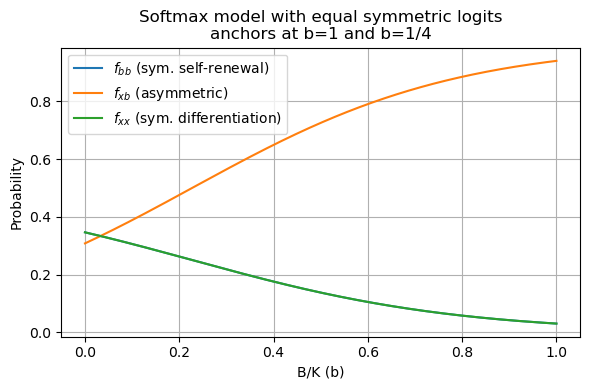

In [94]:
from scipy.special import logsumexp

# Anchors
b1, fsym1 = 1.0, 0.06    # homeostasis: f_sym = 2*0.03 = 0.06 at B/K = 1
b2, fsym2 = 1/4, 0.48   # injury:    f_sym = 0.48  at B/K = 1/4

# baseline asymmetric logit (arbitrary reference; shifting q_xb shifts symmetric logits similarly)
q_xb = 0.0

# helper: r = exp(h - q_xb) from f_sym = 2 r / (1 + 2 r) -> r = f_sym/(2 (1-f_sym))
def r_from_fsym(f):
    return f / (2.0 * (1.0 - f))

r1 = r_from_fsym(fsym1)
r2 = r_from_fsym(fsym2)

# Solve for linear logit h(b) = a*(1-b) + q_small
# h(b1) = ln r1 + q_xb, h(b2) = ln r2 + q_xb
h1 = np.log(r1) + q_xb
h2 = np.log(r2) + q_xb
a = (h2 - h1) / (1.0 - b2)
q_small = h1   # h(b=1)

# vectorised functions
def h_of_b(b):
    return a * (1.0 - b) + q_small

def probs_for_b_array(bs):
    h = h_of_b(bs)
    # logits order: [l_bb, l_xb, l_xx] with l_bb = l_xx = h(b)
    logits = np.vstack((h, np.full_like(h, q_xb), h))
    denom = logsumexp(logits, axis=0)
    probs = np.exp(logits - denom)   # shape (3, N)
    return probs

# compute and plot for B/K in [0,1]
bs = np.linspace(0.0, 1.0, 501)
probs = probs_for_b_array(bs)  # rows: f_bb, f_xb, f_xx

# print parameters + sample values
print("Parameters: a = {:.6f}, q_small = {:.6f}, q_xb = {:.6f}".format(a, q_small, q_xb))
for s in (0.0, 0.25, 1.0):
    i = np.argmin(np.abs(bs - s))
    print(f"B/K={bs[i]:.2f} -> f_bb={probs[0,i]:.4f}, f_xb={probs[1,i]:.4f}, f_xx={probs[2,i]:.4f}, f_sym={probs[0,i]+probs[2,i]:.4f}")

plt.figure(figsize=(6,4))
plt.plot(bs, probs[0,:], label=r'$f_{bb}$ (sym. self-renewal)')
plt.plot(bs, probs[1,:], label=r'$f_{xb}$ (asymmetric)')
plt.plot(bs, probs[2,:], label=r'$f_{xx}$ (sym. differentiation)')
plt.xlabel('B/K (b)')
plt.ylabel('Probability')
plt.title('Softmax model with equal symmetric logits\nanchors at b=1 and b=1/4')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()